In [2]:
#!kill -9 -1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from astropy.units import one

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, precision_recall_curve, average_precision_score, roc_auc_score, roc_curve, auc

from tensorflow.keras.layers import Conv1D, Conv2D,Dense, MaxPooling1D,MaxPooling2D,Flatten,Dropout,Activation,BatchNormalization,Input
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import LSTM, GRU, CuDNNLSTM, CuDNNGRU
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import concatenate as Concatenate
from tensorflow.keras.models import Model
from tensorflow.contrib.opt import MomentumWOptimizer, AdamWOptimizer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
#from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
#from tensorflow.keras.engine.topology import Layer


import itertools
import random
import math

# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

import os
# from keras.models import Sequential
# from keras.layers import Activation, Dropout, Flatten, Dense
#from keras.preprocessing.image import ImageDataGenerator
# from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
# from keras import optimizers


from IPython.display import clear_output



In [3]:
from tensorflow.keras.layers import Layer 
from tensorflow.keras import initializers as initializers, regularizers, constraints
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, SpatialDropout1D, Bidirectional, concatenate, InputSpec


In [4]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize

In [5]:

is_on_colab = False

is_show_colab_env_info = False



if(is_on_colab):

    if(is_show_colab_env_info):
        import psutil
        import humanize
        import os
        import GPUtil as GPU
        GPUs = GPU.getGPUs()
        # XXX: only one GPU on Colab and isn’t guaranteed
        gpu = GPUs[0]
        
    def printm():
        process = psutil.Process(os.getpid())
        print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

    #GPU count and name
    !lscpu |grep 'Model name'
    !nvidia-smi -L
    printm()
  
  
    from google.colab import drive
    drive.mount('/content/drive')

    gdrive_home_dir = '/content/drive/My Drive/'

    project_dir = f'{gdrive_home_dir}DeepCNC/'
    ds_dir = f'{project_dir}data/'
    snapshot_dir = f'{project_dir}snapshots/'

    !ls '{ds_dir}'

else:
    project_dir = f'/disks/data/paper_projects/DeepCNC/'
    ds_dir = f'{project_dir}data/'
    snapshot_dir = f'{project_dir}snapshots/'


  

In [6]:
# fnmInput = f'{ds_dir}inputSeq_N_ReplacedBy_C.txt';

# fnmLabel = f'{ds_dir}inputLabel.txt'

# print(fnmInput)

In [7]:
# with open(fnmInput,'r') as f:
#     print("# of lines in the input file:",len(f.readlines()))
    
    
# with open(fnmLabel,'r') as f:
#     print("# of lines in the label file:",len(f.readlines()))

In [8]:
# import glob

# files = glob.glob(f'{project_dir}data/imdata/*.bmp')
# print(len(files))
# # !ls "{project_dir}data/imdata" -l |wc -l

In [9]:
k_folds=  10 # 10 # 2
hyper_epoch=  300 #50 # 5
class_weight = {0: 1., 1: 1.} # 10 

#class_weight = {0: ratio_High_Low, 1: 1.} # 10 
#print(ratio_High_Low)

hyper_classes=2

hyper_validation_split = 0.20
#hyper_test_split=0.10
#hyper_pool_size = (1,2)
hyper_batch_size = 256
# hyper_optimizer = 'Adadelta'
# hyper_init_mode = 'zero'
# hyper_activation = 'tanh'
# hyper_filter = 50
# hyper_filterL = 30
# hyper_filterW = 32
# hyper_neurons = 32
# hyper_dropout_rate = 0.1


model_history = []
dfHistory = pd.DataFrame( columns=['Precsion' , 'Recall' , 'Specificity' , 'Accuracy'])


In [10]:
# updatable plot

# https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        #clear_output(wait=True)
        plt.cla()
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();

        

In [11]:
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K
import numpy as np

class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())
    
    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

        #clear_output(wait=True)
        plt.cla()
        plt.plot(self.history['lr'], label="learning rate")
        plt.legend()
        plt.show();   
        
        
    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)


In [12]:
# def perform_test( mdl, features, labels, cm_df, roc_df, dpr_df ):
    
#     predicted_labels = mdl.predict(np.stack(features))
#     cm = confusion_matrix(np.argmax(labels, axis=1), np.argmax(predicted_labels, axis=1))
#     output = ""
#     output = output + 'Confusion matrix:\n' + str(cm) 
#     output += "\n"
    
#     print('Confusion matrix:\n' ,cm)
#     # cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
#     total1=sum(sum(cm))
#     tp=cm[0,0];fn=cm[0,1];fp=cm[1,0];tn=cm[1,1];
    
#     accuracy1=(tp+tn)/total1
#     sensitivity1 = tp/(tp+fn)
#     specificity1 = tn/(fp+tn)
#     if (tp)==0:
#         precision1 = 0
#     else:
#         precision1 = tp / (tp + fp)

#     MCC = (tp*tn - fp*fn) / np.sqrt(  (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)  )    
#     print( "Precision : " + str(precision1) + " Sensitivity/Recall: " + str (sensitivity1) + " Specificity: " + str(specificity1 )  + " Accuracy: " + str(accuracy1 ) + " MCC: " + str(MCC )) 

#     output = output + "Precision : " + str(precision1) + " Sensitivity/Recall: " + str (sensitivity1) + " Specificity: " + str(specificity1 )  + " Accuracy: " + str(accuracy1 ) + " MCC: " + str(MCC )
#     output += "\n"
    
#     cm_df =  dfCM.append( {  'tp': tp , 'fn' : fn , 'fp': fp  , 'tn' : tn  } , ignore_index=True)   
    
#     auc_roc           = roc_auc_score( np.argmax(labels, axis=1), np.argmax(predicted_labels, axis=1) )  
#     average_precision = average_precision_score(np.argmax(labels, axis=1), np.argmax(predicted_labels, axis=1))
#     print( "area ROC : " , auc_roc ,  " area PR " , average_precision)
#     output = output + " area ROC : " + str(auc_roc) +  " area PR " + str(average_precision)
#     output += "\n"

#     roc_df =  roc_df.append( {  'AREA_ROC': auc_roc  } , ignore_index=True) 
#     dpr_df  =  dpr_df.append( {  'AREA_PR': average_precision  } , ignore_index=True) 
    
#     return output

In [13]:
def perform_test( mdl, features, labels, cm_df, roc_df, dpr_df ):
    
    #model.evaluate_generator(validation_generator, num_val_batches)	
    predictions = mdl.predict_generator(validation_generator, num_val_batches)

    #predicted_labels = mdl.predict(np.stack(features))
    cm = confusion_matrix(np.argmax(labels, axis=1), np.argmax(predicted_labels, axis=1))
    output = ""
    output = output + 'Confusion matrix:\n' + str(cm) 
    output += "\n"
    
    print('Confusion matrix:\n' ,cm)
    # cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    total1=sum(sum(cm))
    tp=cm[0,0];fn=cm[0,1];fp=cm[1,0];tn=cm[1,1];
    
    accuracy1=(tp+tn)/total1
    sensitivity1 = tp/(tp+fn)
    specificity1 = tn/(fp+tn)
    if (tp)==0:
        precision1 = 0
    else:
        precision1 = tp / (tp + fp)

    MCC = (tp*tn - fp*fn) / np.sqrt(  (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)  )    
    print( "Precision : " + str(precision1) + " Sensitivity/Recall: " + str (sensitivity1) + " Specificity: " + str(specificity1 )  + " Accuracy: " + str(accuracy1 ) + " MCC: " + str(MCC )) 

    output = output + "Precision : " + str(precision1) + " Sensitivity/Recall: " + str (sensitivity1) + " Specificity: " + str(specificity1 )  + " Accuracy: " + str(accuracy1 ) + " MCC: " + str(MCC )
    output += "\n"
    
    cm_df =  dfCM.append( {  'tp': tp , 'fn' : fn , 'fp': fp  , 'tn' : tn  } , ignore_index=True)   
    
    auc_roc           = roc_auc_score( np.argmax(labels, axis=1), np.argmax(predicted_labels, axis=1) )  
    average_precision = average_precision_score(np.argmax(labels, axis=1), np.argmax(predicted_labels, axis=1))
    print( "area ROC : " , auc_roc ,  " area PR " , average_precision)
    output = output + " area ROC : " + str(auc_roc) +  " area PR " + str(average_precision)
    output += "\n"

    roc_df =  roc_df.append( {  'AREA_ROC': auc_roc  } , ignore_index=True) 
    dpr_df  =  dpr_df.append( {  'AREA_PR': average_precision  } , ignore_index=True) 
    
    return output

In [14]:
def make_model_2DConv(input_shape):

    
    def keras_example():
        # # Model architecture definition		
        model = Sequential()
        model.add(Convolution2D(32,( 3, 3), input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Convolution2D(64, (3, 3) ) )
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Flatten())
        model.add(Dense(64))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1))
        model.add(Activation('sigmoid'))	
        
        
        SGDRScheduler_config = { 'min_lr':.5e-4,
                                 'max_lr':1e-4,
                                 'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
                                 'lr_decay':0.95,
                                 'cycle_length': 5,
                                 'mult_factor': 1.5}
        
        config = {'learning_rate':0.002, 'SGDRScheduler_config': SGDRScheduler_config}
        
        return [model, config]          
    # -------------------------------------------------------------------------------------------------------------------------------------
    # ------------------------------------------ sequential definition --------------------------------------------------------------------
    # -------------------------------------------------------------------------------------------------------------------------------------

    def make_seq_cnn_3mer():
        
        model = Sequential()

        model.add(Convolution2D(filters = 32, kernel_size=(3,3), input_shape=input_shape)  )    
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(rate = 0.3)) # input = 129 * 32
        
        
        model.add(Convolution2D(filters = 64, kernel_size=(3,3))  )    
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(rate = 0.3)) # input = 129 * 32

        model.add(Convolution2D(filters = 128, kernel_size=(3,3))  )    
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(rate = 0.3)) # input = 129 * 32
        
        model.add(Flatten())

        model.add(Dense(16, kernel_regularizer=l2(0.02)) )
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, kernel_regularizer=l2(0.01)))        
        model.add(Activation('sigmoid'))
        
        SGDRScheduler_config = { 'min_lr':.5e-4,
                                 'max_lr':1e-4,
                                 'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
                                 'lr_decay':0.95,
                                 'cycle_length': 5,
                                 'mult_factor': 1.5}
        
        config = {'learning_rate':0.002, 'SGDRScheduler_config': SGDRScheduler_config}
        
        return [model, config]  
  
  
    
    return make_seq_cnn_3mer()

In [22]:
train_data_dir      = '/disks/data/paper_projects/DeepCNC/data/imdata_split_90_10/train/'  # 'D:/STC_Projects/ImageRecognition/mytrainingset' # 'data/train'
validation_data_dir = '/disks/data/paper_projects/DeepCNC/data/imdata_split_90_10/val/' # 'D:/STC_Projects/ImageRecognition/myvalidationset' # 'data/validation'


# used to rescale the pixel values from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator()

img_width = 64
img_height = 1998
num_channels = 3


if K.image_data_format() == 'channels_first':
    input_shape = (num_channels, img_width, img_height)
else:
    input_shape = (img_width, img_height, num_channels)

# automagically retrieve images and their classes for train and validation sets
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=64,
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=64,
        class_mode='binary')
		
    
num_training_batches = len(train_generator)
num_val_batches = len(validation_generator)


for img, labels in train_generator:
    print(img.shape)
    break

Found 33548 images belonging to 2 classes.
Found 3726 images belonging to 2 classes.
(64, 64, 1998, 3)


In [23]:
all_training_labels  = []
i = 0
for img, labels in train_generator:
    all_training_labels.append(labels)
    i +=1
    if i%(num_training_batches//10) ==0:
        print(i)
    if(i > num_training_batches):
        break
all_training_labels

In [24]:
# from tensorflow.keras import backend as K
# K.tensorflow_backend._get_available_gpus()



 --------------- Fold: 1  ---------------
Building model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 1996, 32)      896       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 62, 1996, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 62, 1996, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 998, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 998, 32)       0         
____________________________

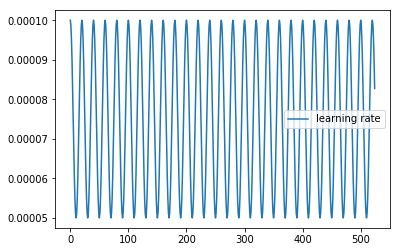


Epoch 00001: val_loss improved from inf to 0.81479, saving model to /disks/data/paper_projects/DeepCNC/snapshots/1_Weights_bestModel.h5


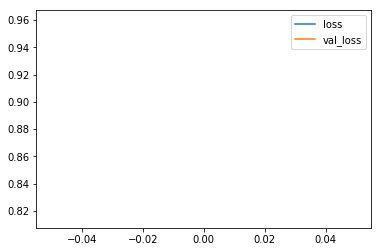

525/525 [==============================] - 185s 352ms/step - loss: 0.9605 - binary_accuracy: 0.6333 - val_loss: 0.8148 - val_binary_accuracy: 0.7077
Epoch 2/300
59/59 [==============================] - 7s 121ms/step - loss: 0.7217 - binary_accuracy: 0.6790


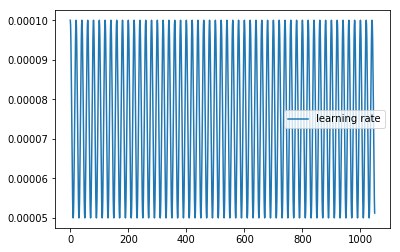


Epoch 00002: val_loss improved from 0.81479 to 0.72173, saving model to /disks/data/paper_projects/DeepCNC/snapshots/1_Weights_bestModel.h5


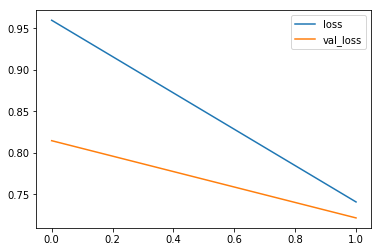

525/525 [==============================] - 182s 346ms/step - loss: 0.7408 - binary_accuracy: 0.6615 - val_loss: 0.7217 - val_binary_accuracy: 0.6790
Epoch 3/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6821 - binary_accuracy: 0.7228


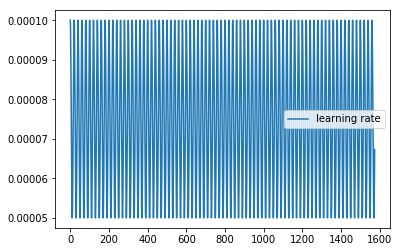


Epoch 00003: val_loss improved from 0.72173 to 0.68206, saving model to /disks/data/paper_projects/DeepCNC/snapshots/1_Weights_bestModel.h5


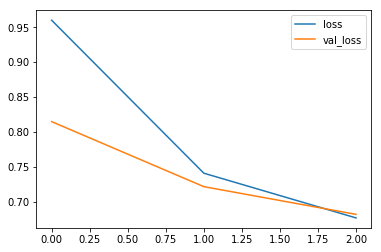

525/525 [==============================] - 183s 349ms/step - loss: 0.6767 - binary_accuracy: 0.6829 - val_loss: 0.6821 - val_binary_accuracy: 0.7228
Epoch 4/300
59/59 [==============================] - 7s 124ms/step - loss: 0.6692 - binary_accuracy: 0.7284


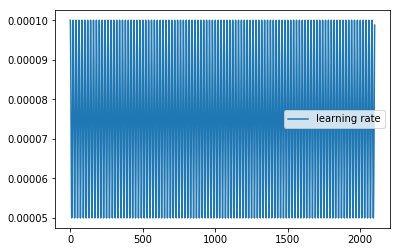


Epoch 00004: val_loss improved from 0.68206 to 0.66915, saving model to /disks/data/paper_projects/DeepCNC/snapshots/1_Weights_bestModel.h5


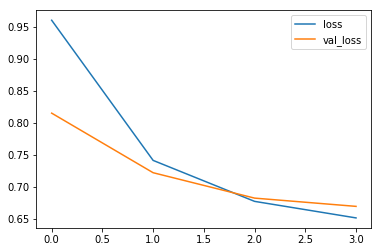

525/525 [==============================] - 183s 349ms/step - loss: 0.6512 - binary_accuracy: 0.6889 - val_loss: 0.6692 - val_binary_accuracy: 0.7284
Epoch 5/300
59/59 [==============================] - 7s 123ms/step - loss: 0.6544 - binary_accuracy: 0.7214


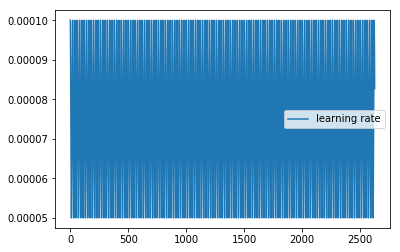


Epoch 00005: val_loss improved from 0.66915 to 0.65442, saving model to /disks/data/paper_projects/DeepCNC/snapshots/1_Weights_bestModel.h5


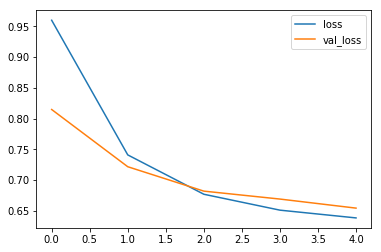

525/525 [==============================] - 184s 350ms/step - loss: 0.6386 - binary_accuracy: 0.6873 - val_loss: 0.6544 - val_binary_accuracy: 0.7214
Epoch 6/300
59/59 [==============================] - 7s 124ms/step - loss: 0.6511 - binary_accuracy: 0.7163


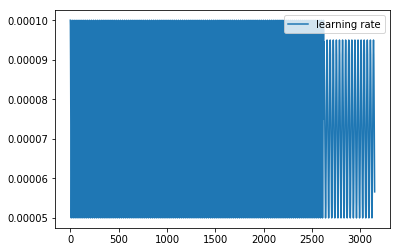


Epoch 00006: val_loss improved from 0.65442 to 0.65110, saving model to /disks/data/paper_projects/DeepCNC/snapshots/1_Weights_bestModel.h5


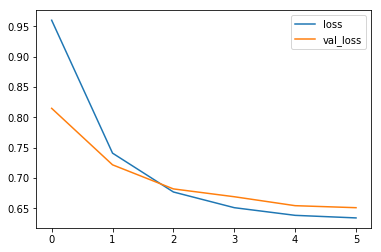

525/525 [==============================] - 187s 356ms/step - loss: 0.6342 - binary_accuracy: 0.6926 - val_loss: 0.6511 - val_binary_accuracy: 0.7163
Epoch 7/300
59/59 [==============================] - 7s 126ms/step - loss: 0.6325 - binary_accuracy: 0.7254


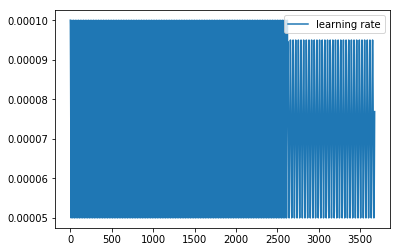


Epoch 00007: val_loss improved from 0.65110 to 0.63249, saving model to /disks/data/paper_projects/DeepCNC/snapshots/1_Weights_bestModel.h5


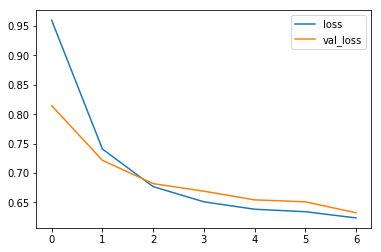

525/525 [==============================] - 184s 351ms/step - loss: 0.6235 - binary_accuracy: 0.7010 - val_loss: 0.6325 - val_binary_accuracy: 0.7254
Epoch 8/300
59/59 [==============================] - 7s 122ms/step - loss: 0.6362 - binary_accuracy: 0.7236


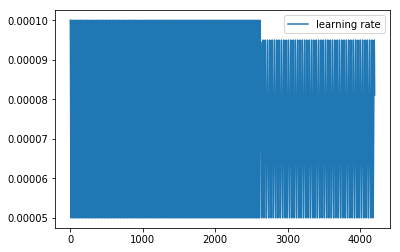


Epoch 00008: val_loss did not improve from 0.63249


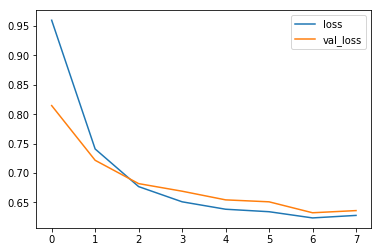

525/525 [==============================] - 184s 350ms/step - loss: 0.6278 - binary_accuracy: 0.7019 - val_loss: 0.6362 - val_binary_accuracy: 0.7236
Epoch 9/300
59/59 [==============================] - 7s 123ms/step - loss: 0.6165 - binary_accuracy: 0.7271


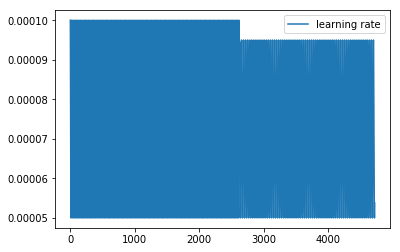


Epoch 00009: val_loss improved from 0.63249 to 0.61646, saving model to /disks/data/paper_projects/DeepCNC/snapshots/1_Weights_bestModel.h5


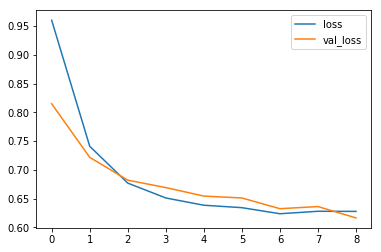

525/525 [==============================] - 184s 351ms/step - loss: 0.6277 - binary_accuracy: 0.7022 - val_loss: 0.6165 - val_binary_accuracy: 0.7271
Epoch 10/300
59/59 [==============================] - 7s 122ms/step - loss: 0.6282 - binary_accuracy: 0.7268


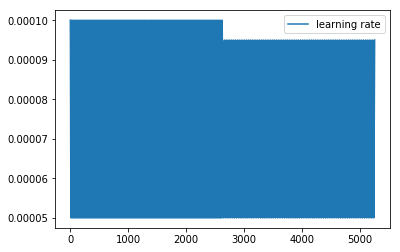


Epoch 00010: val_loss did not improve from 0.61646


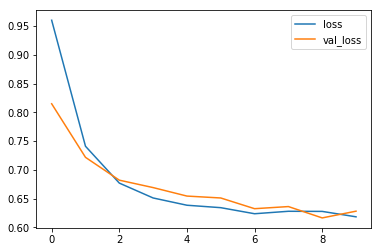

525/525 [==============================] - 185s 353ms/step - loss: 0.6182 - binary_accuracy: 0.7051 - val_loss: 0.6282 - val_binary_accuracy: 0.7268
Epoch 11/300
59/59 [==============================] - 7s 123ms/step - loss: 0.6135 - binary_accuracy: 0.7262


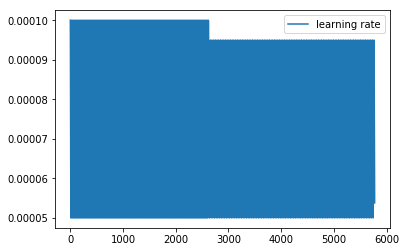


Epoch 00011: val_loss improved from 0.61646 to 0.61351, saving model to /disks/data/paper_projects/DeepCNC/snapshots/1_Weights_bestModel.h5


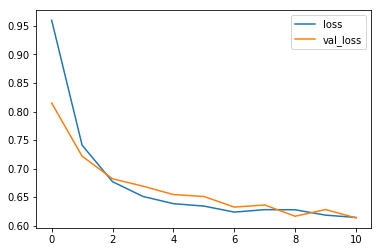

525/525 [==============================] - 183s 349ms/step - loss: 0.6145 - binary_accuracy: 0.7107 - val_loss: 0.6135 - val_binary_accuracy: 0.7262
Epoch 12/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6150 - binary_accuracy: 0.7107


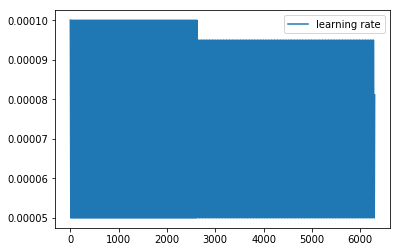


Epoch 00012: val_loss did not improve from 0.61351


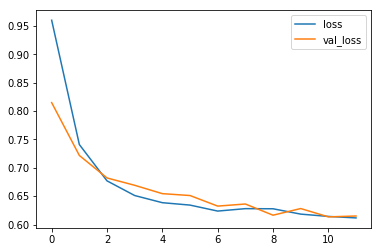

525/525 [==============================] - 184s 350ms/step - loss: 0.6117 - binary_accuracy: 0.7084 - val_loss: 0.6150 - val_binary_accuracy: 0.7107
Epoch 13/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6231 - binary_accuracy: 0.7010


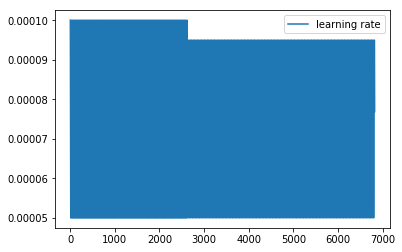


Epoch 00013: val_loss did not improve from 0.61351


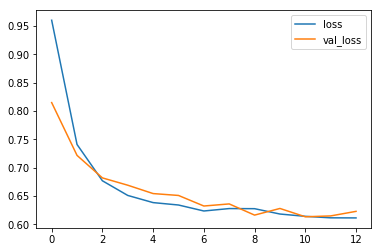

525/525 [==============================] - 184s 351ms/step - loss: 0.6116 - binary_accuracy: 0.7067 - val_loss: 0.6231 - val_binary_accuracy: 0.7010
Epoch 14/300
59/59 [==============================] - 7s 123ms/step - loss: 0.6163 - binary_accuracy: 0.7136


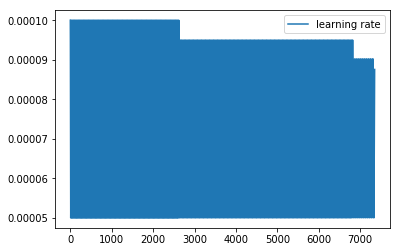


Epoch 00014: val_loss did not improve from 0.61351


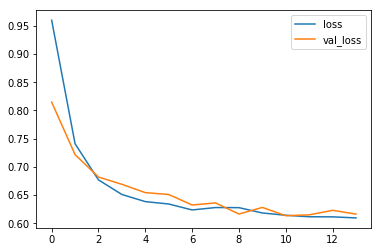

525/525 [==============================] - 183s 349ms/step - loss: 0.6098 - binary_accuracy: 0.7063 - val_loss: 0.6163 - val_binary_accuracy: 0.7136
Epoch 15/300
59/59 [==============================] - 7s 123ms/step - loss: 0.5971 - binary_accuracy: 0.7271


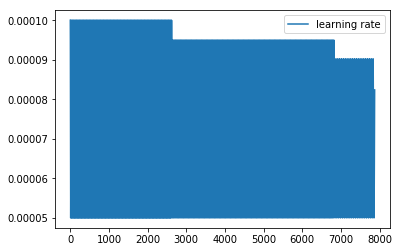


Epoch 00015: val_loss improved from 0.61351 to 0.59710, saving model to /disks/data/paper_projects/DeepCNC/snapshots/1_Weights_bestModel.h5


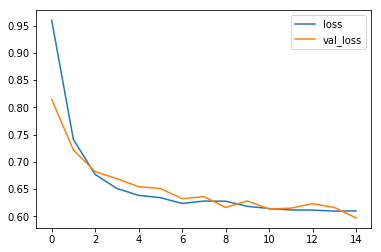

525/525 [==============================] - 183s 349ms/step - loss: 0.6099 - binary_accuracy: 0.7106 - val_loss: 0.5971 - val_binary_accuracy: 0.7271
Epoch 16/300
59/59 [==============================] - 7s 122ms/step - loss: 0.6091 - binary_accuracy: 0.7268


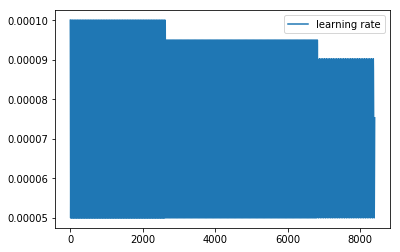


Epoch 00016: val_loss did not improve from 0.59710


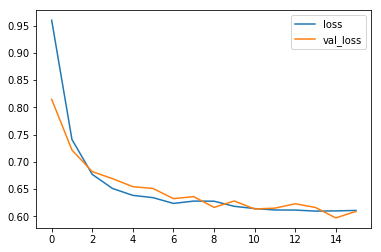

525/525 [==============================] - 184s 350ms/step - loss: 0.6106 - binary_accuracy: 0.7075 - val_loss: 0.6091 - val_binary_accuracy: 0.7268
Epoch 17/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6159 - binary_accuracy: 0.7126


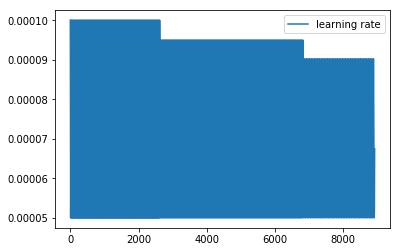


Epoch 00017: val_loss did not improve from 0.59710


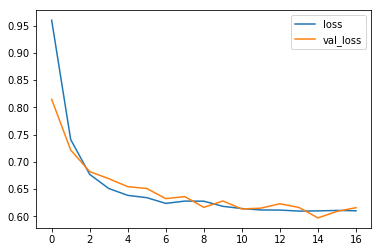

525/525 [==============================] - 184s 351ms/step - loss: 0.6104 - binary_accuracy: 0.7100 - val_loss: 0.6159 - val_binary_accuracy: 0.7126
Epoch 18/300
59/59 [==============================] - 7s 123ms/step - loss: 0.6132 - binary_accuracy: 0.7211


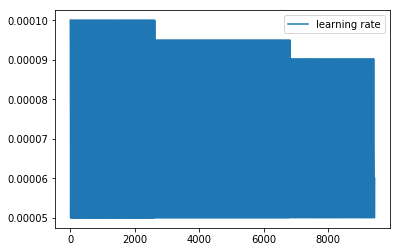


Epoch 00018: val_loss did not improve from 0.59710


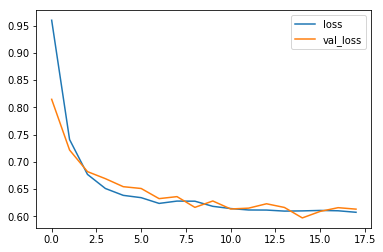

525/525 [==============================] - 184s 350ms/step - loss: 0.6074 - binary_accuracy: 0.7107 - val_loss: 0.6132 - val_binary_accuracy: 0.7211
Epoch 19/300
59/59 [==============================] - 7s 122ms/step - loss: 0.6069 - binary_accuracy: 0.7236


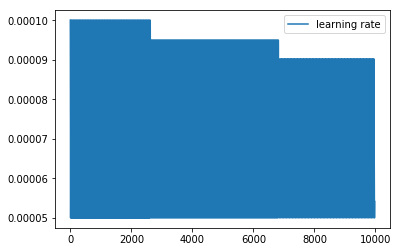


Epoch 00019: val_loss did not improve from 0.59710


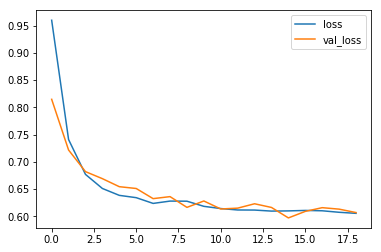

525/525 [==============================] - 183s 349ms/step - loss: 0.6060 - binary_accuracy: 0.7149 - val_loss: 0.6069 - val_binary_accuracy: 0.7236
Epoch 20/300
59/59 [==============================] - 7s 123ms/step - loss: 0.6051 - binary_accuracy: 0.7225


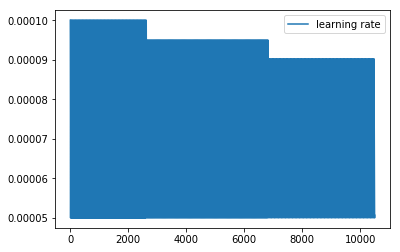


Epoch 00020: val_loss did not improve from 0.59710


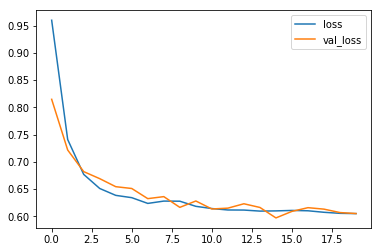

525/525 [==============================] - 183s 349ms/step - loss: 0.6051 - binary_accuracy: 0.7177 - val_loss: 0.6051 - val_binary_accuracy: 0.7225
Epoch 21/300
59/59 [==============================] - 7s 123ms/step - loss: 0.6079 - binary_accuracy: 0.7171


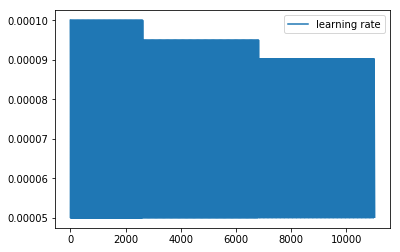


Epoch 00021: val_loss did not improve from 0.59710


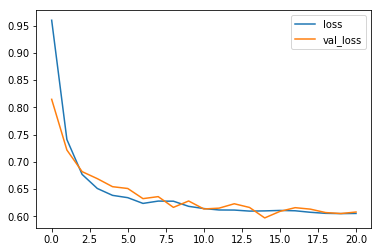

525/525 [==============================] - 183s 349ms/step - loss: 0.6054 - binary_accuracy: 0.7145 - val_loss: 0.6079 - val_binary_accuracy: 0.7171
Epoch 22/300
59/59 [==============================] - 7s 119ms/step - loss: 0.6064 - binary_accuracy: 0.7241


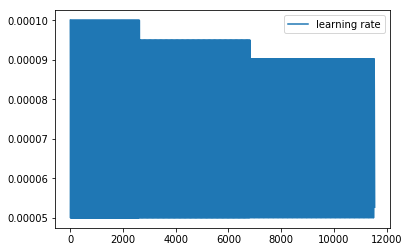


Epoch 00022: val_loss did not improve from 0.59710


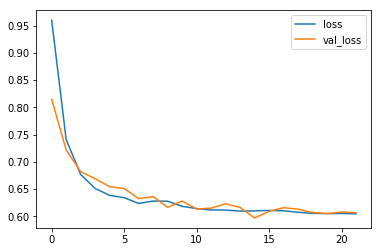

525/525 [==============================] - 177s 338ms/step - loss: 0.6049 - binary_accuracy: 0.7164 - val_loss: 0.6064 - val_binary_accuracy: 0.7241
Epoch 23/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6212 - binary_accuracy: 0.6986


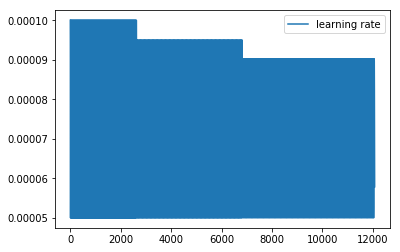


Epoch 00023: val_loss did not improve from 0.59710


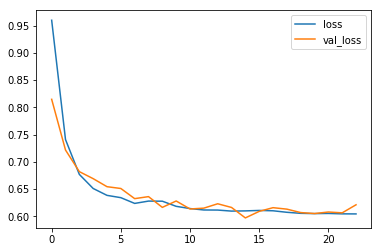

525/525 [==============================] - 177s 337ms/step - loss: 0.6042 - binary_accuracy: 0.7151 - val_loss: 0.6212 - val_binary_accuracy: 0.6986
Epoch 24/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6081 - binary_accuracy: 0.7203


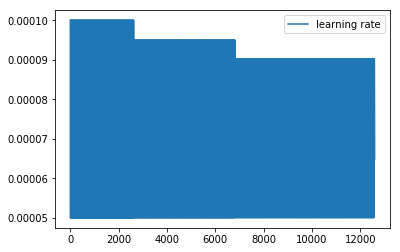


Epoch 00024: val_loss did not improve from 0.59710


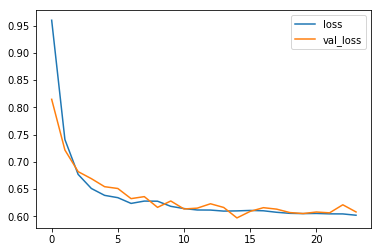

525/525 [==============================] - 177s 338ms/step - loss: 0.6022 - binary_accuracy: 0.7164 - val_loss: 0.6081 - val_binary_accuracy: 0.7203
Epoch 25/300
59/59 [==============================] - 7s 119ms/step - loss: 0.6107 - binary_accuracy: 0.7214


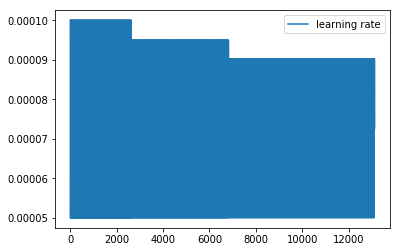


Epoch 00025: val_loss did not improve from 0.59710


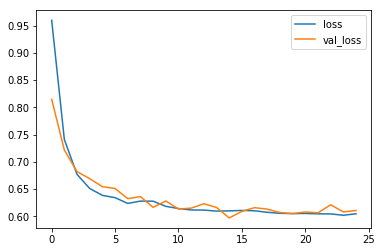

525/525 [==============================] - 177s 337ms/step - loss: 0.6047 - binary_accuracy: 0.7164 - val_loss: 0.6107 - val_binary_accuracy: 0.7214
Epoch 26/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6126 - binary_accuracy: 0.7131


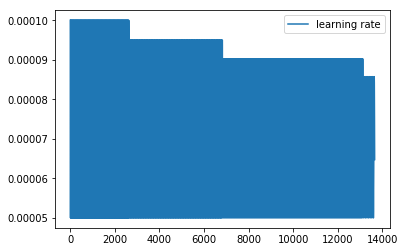


Epoch 00026: val_loss did not improve from 0.59710


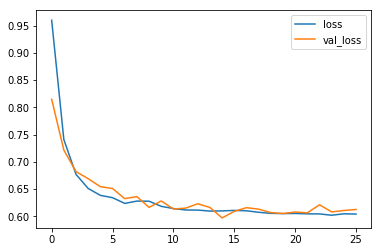

525/525 [==============================] - 177s 337ms/step - loss: 0.6040 - binary_accuracy: 0.7163 - val_loss: 0.6126 - val_binary_accuracy: 0.7131
Epoch 27/300
59/59 [==============================] - 7s 119ms/step - loss: 0.6051 - binary_accuracy: 0.7244


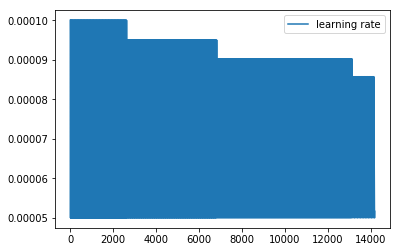


Epoch 00027: val_loss did not improve from 0.59710


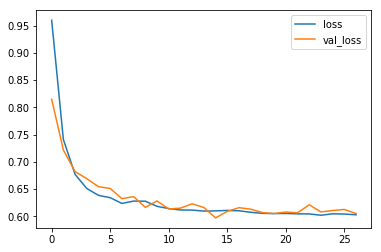

525/525 [==============================] - 177s 337ms/step - loss: 0.6029 - binary_accuracy: 0.7124 - val_loss: 0.6051 - val_binary_accuracy: 0.7244
Epoch 28/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6183 - binary_accuracy: 0.7120


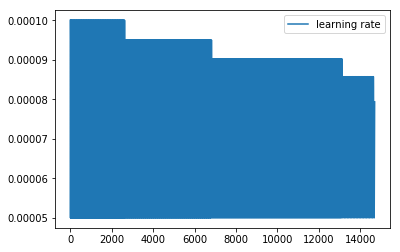


Epoch 00028: val_loss did not improve from 0.59710


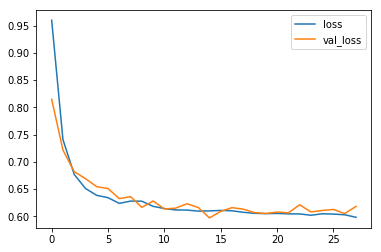

525/525 [==============================] - 177s 337ms/step - loss: 0.5980 - binary_accuracy: 0.7184 - val_loss: 0.6183 - val_binary_accuracy: 0.7120
Epoch 29/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6084 - binary_accuracy: 0.7120


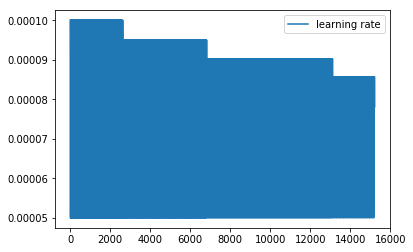


Epoch 00029: val_loss did not improve from 0.59710


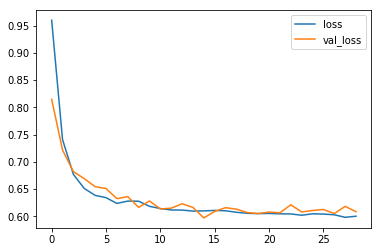

525/525 [==============================] - 177s 337ms/step - loss: 0.6004 - binary_accuracy: 0.7208 - val_loss: 0.6084 - val_binary_accuracy: 0.7120
Epoch 30/300
59/59 [==============================] - 7s 119ms/step - loss: 0.6070 - binary_accuracy: 0.7203


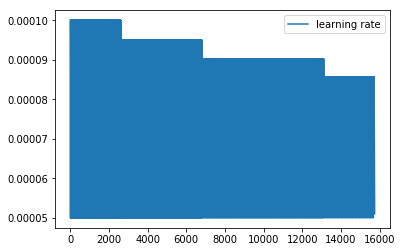


Epoch 00030: val_loss did not improve from 0.59710


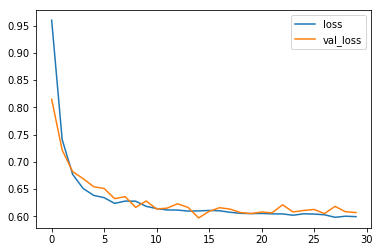

525/525 [==============================] - 177s 337ms/step - loss: 0.5992 - binary_accuracy: 0.7162 - val_loss: 0.6070 - val_binary_accuracy: 0.7203
Epoch 31/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6180 - binary_accuracy: 0.7072


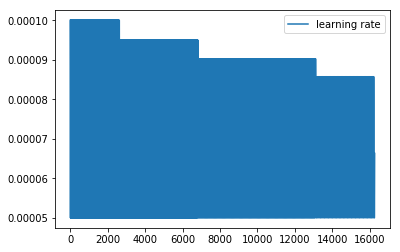


Epoch 00031: val_loss did not improve from 0.59710


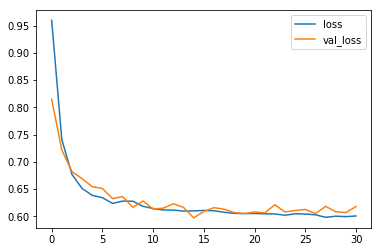

525/525 [==============================] - 177s 337ms/step - loss: 0.6007 - binary_accuracy: 0.7163 - val_loss: 0.6180 - val_binary_accuracy: 0.7072
Epoch 32/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6197 - binary_accuracy: 0.7104


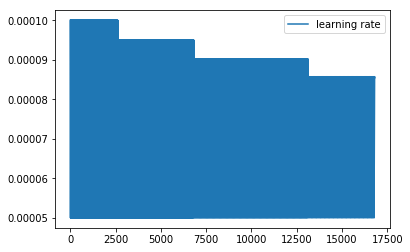


Epoch 00032: val_loss did not improve from 0.59710


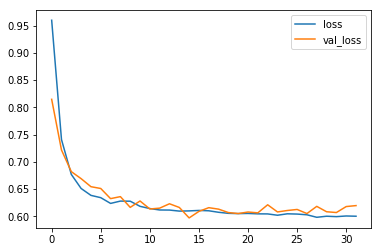

525/525 [==============================] - 177s 337ms/step - loss: 0.6002 - binary_accuracy: 0.7209 - val_loss: 0.6197 - val_binary_accuracy: 0.7104
Epoch 33/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6095 - binary_accuracy: 0.7118


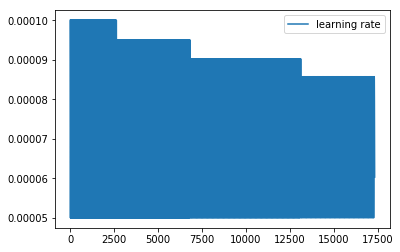


Epoch 00033: val_loss did not improve from 0.59710


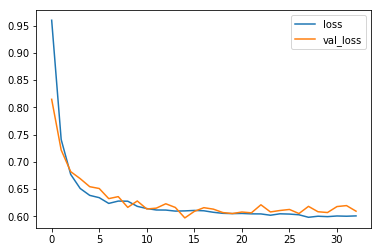

525/525 [==============================] - 177s 337ms/step - loss: 0.6010 - binary_accuracy: 0.7160 - val_loss: 0.6095 - val_binary_accuracy: 0.7118
Epoch 34/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6148 - binary_accuracy: 0.7107


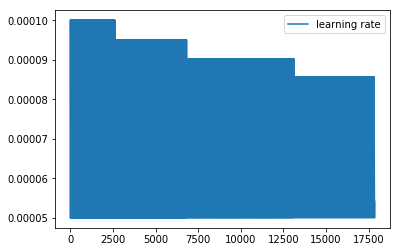


Epoch 00034: val_loss did not improve from 0.59710


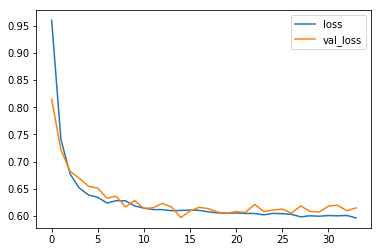

525/525 [==============================] - 177s 337ms/step - loss: 0.5963 - binary_accuracy: 0.7183 - val_loss: 0.6148 - val_binary_accuracy: 0.7107
Epoch 35/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6028 - binary_accuracy: 0.7252


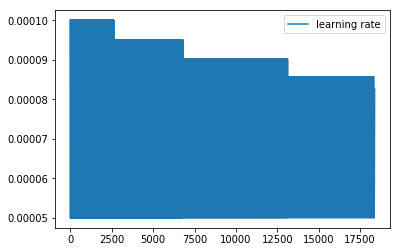


Epoch 00035: val_loss did not improve from 0.59710


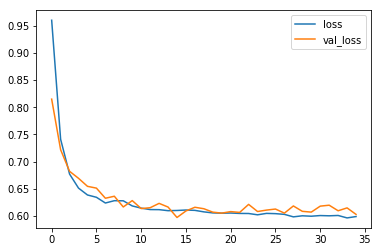

525/525 [==============================] - 177s 337ms/step - loss: 0.5990 - binary_accuracy: 0.7149 - val_loss: 0.6028 - val_binary_accuracy: 0.7252
Epoch 36/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6063 - binary_accuracy: 0.7254


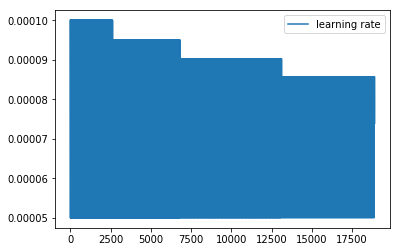


Epoch 00036: val_loss did not improve from 0.59710


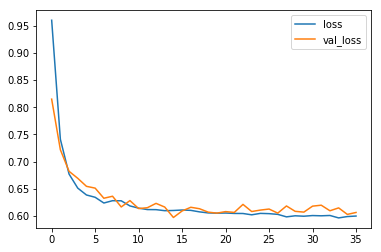

525/525 [==============================] - 177s 337ms/step - loss: 0.5996 - binary_accuracy: 0.7189 - val_loss: 0.6063 - val_binary_accuracy: 0.7254
Epoch 37/300
59/59 [==============================] - 7s 119ms/step - loss: 0.6049 - binary_accuracy: 0.7198


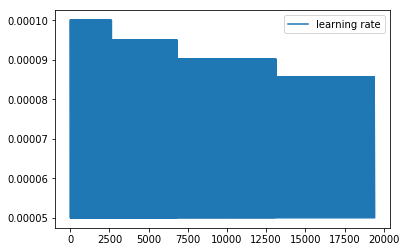


Epoch 00037: val_loss did not improve from 0.59710


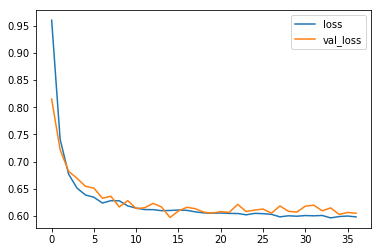

525/525 [==============================] - 177s 337ms/step - loss: 0.5986 - binary_accuracy: 0.7206 - val_loss: 0.6049 - val_binary_accuracy: 0.7198
Epoch 38/300
59/59 [==============================] - 7s 119ms/step - loss: 0.6254 - binary_accuracy: 0.6895


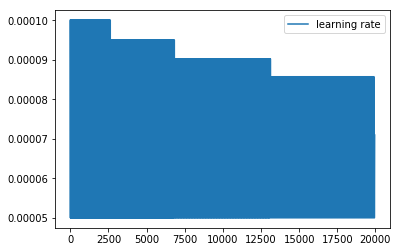


Epoch 00038: val_loss did not improve from 0.59710


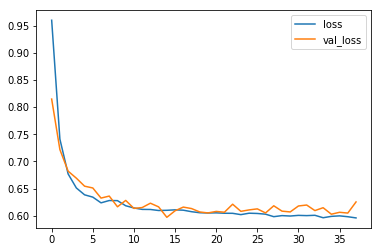

525/525 [==============================] - 177s 337ms/step - loss: 0.5960 - binary_accuracy: 0.7204 - val_loss: 0.6254 - val_binary_accuracy: 0.6895
Epoch 39/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6116 - binary_accuracy: 0.7085


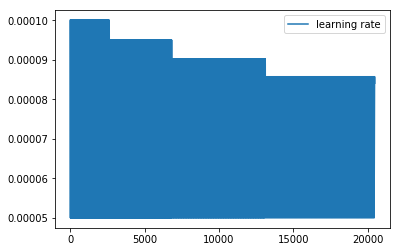


Epoch 00039: val_loss did not improve from 0.59710


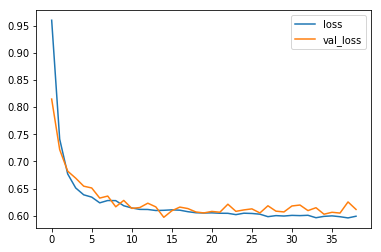

525/525 [==============================] - 177s 337ms/step - loss: 0.5989 - binary_accuracy: 0.7197 - val_loss: 0.6116 - val_binary_accuracy: 0.7085
Epoch 40/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6178 - binary_accuracy: 0.7016


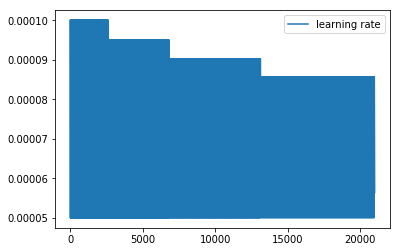


Epoch 00040: val_loss did not improve from 0.59710


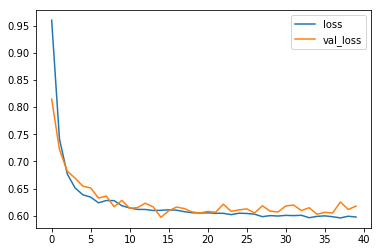

525/525 [==============================] - 177s 337ms/step - loss: 0.5974 - binary_accuracy: 0.7181 - val_loss: 0.6178 - val_binary_accuracy: 0.7016
Epoch 41/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6213 - binary_accuracy: 0.6911


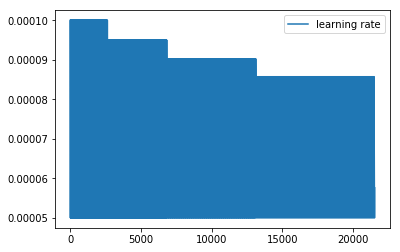


Epoch 00041: val_loss did not improve from 0.59710


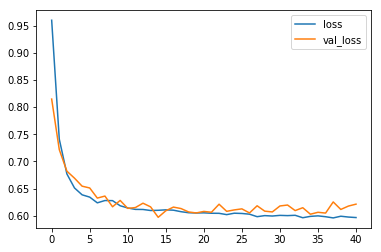

525/525 [==============================] - 177s 337ms/step - loss: 0.5966 - binary_accuracy: 0.7212 - val_loss: 0.6213 - val_binary_accuracy: 0.6911
Epoch 42/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6204 - binary_accuracy: 0.7024


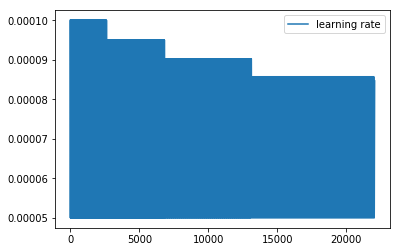


Epoch 00042: val_loss did not improve from 0.59710


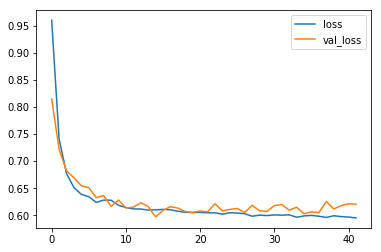

525/525 [==============================] - 177s 337ms/step - loss: 0.5947 - binary_accuracy: 0.7204 - val_loss: 0.6204 - val_binary_accuracy: 0.7024
Epoch 43/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6085 - binary_accuracy: 0.7152


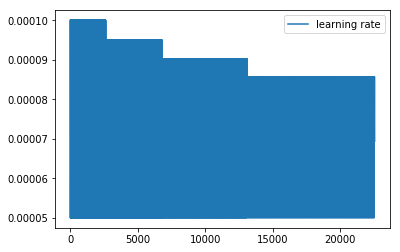


Epoch 00043: val_loss did not improve from 0.59710


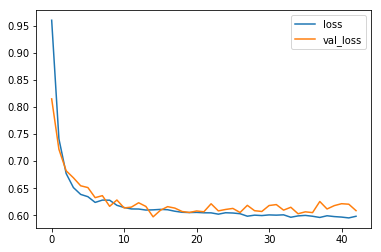

525/525 [==============================] - 177s 337ms/step - loss: 0.5981 - binary_accuracy: 0.7168 - val_loss: 0.6085 - val_binary_accuracy: 0.7152
Epoch 44/300
59/59 [==============================] - 7s 119ms/step - loss: 0.6133 - binary_accuracy: 0.7080


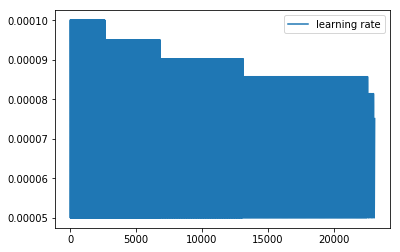


Epoch 00044: val_loss did not improve from 0.59710


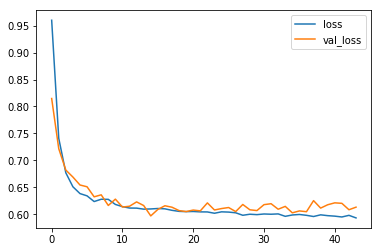

525/525 [==============================] - 177s 338ms/step - loss: 0.5935 - binary_accuracy: 0.7197 - val_loss: 0.6133 - val_binary_accuracy: 0.7080
Epoch 45/300
59/59 [==============================] - 7s 119ms/step - loss: 0.6165 - binary_accuracy: 0.6951


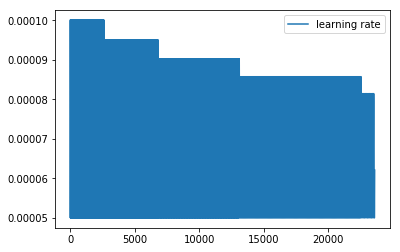


Epoch 00045: val_loss did not improve from 0.59710


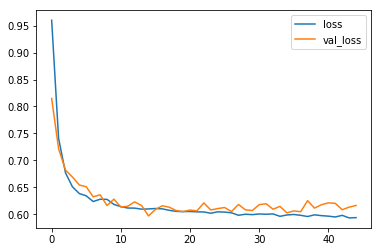

525/525 [==============================] - 177s 337ms/step - loss: 0.5941 - binary_accuracy: 0.7222 - val_loss: 0.6165 - val_binary_accuracy: 0.6951
Epoch 46/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6185 - binary_accuracy: 0.6975


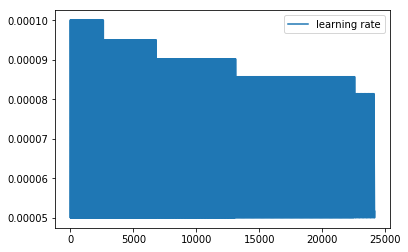


Epoch 00046: val_loss did not improve from 0.59710


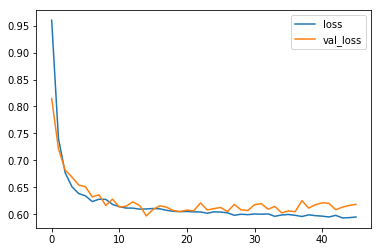

525/525 [==============================] - 177s 338ms/step - loss: 0.5952 - binary_accuracy: 0.7233 - val_loss: 0.6185 - val_binary_accuracy: 0.6975
Epoch 47/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6197 - binary_accuracy: 0.7059


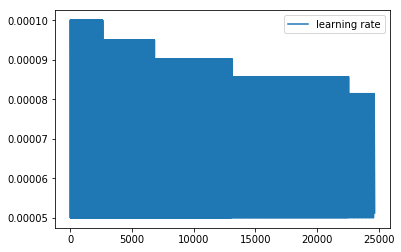


Epoch 00047: val_loss did not improve from 0.59710


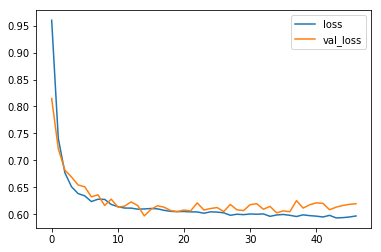

525/525 [==============================] - 177s 337ms/step - loss: 0.5968 - binary_accuracy: 0.7188 - val_loss: 0.6197 - val_binary_accuracy: 0.7059
Epoch 48/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6287 - binary_accuracy: 0.6940


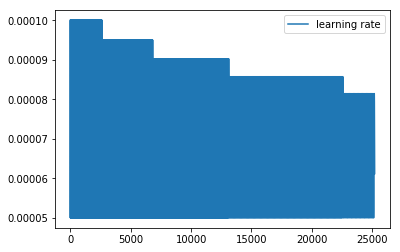


Epoch 00048: val_loss did not improve from 0.59710


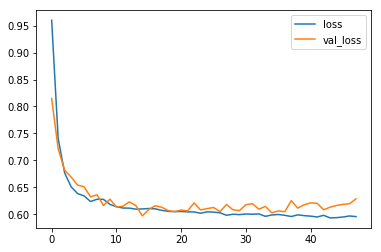

525/525 [==============================] - 177s 337ms/step - loss: 0.5959 - binary_accuracy: 0.7198 - val_loss: 0.6287 - val_binary_accuracy: 0.6940
Epoch 49/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6206 - binary_accuracy: 0.6959


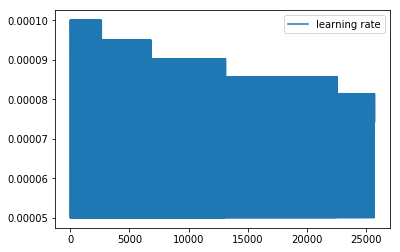


Epoch 00049: val_loss did not improve from 0.59710


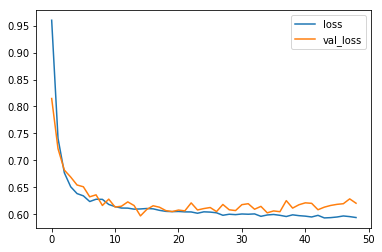

525/525 [==============================] - 177s 337ms/step - loss: 0.5942 - binary_accuracy: 0.7203 - val_loss: 0.6206 - val_binary_accuracy: 0.6959
Epoch 50/300
59/59 [==============================] - 7s 119ms/step - loss: 0.6248 - binary_accuracy: 0.6897


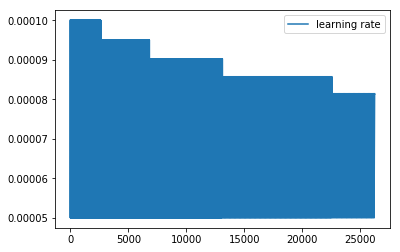


Epoch 00050: val_loss did not improve from 0.59710


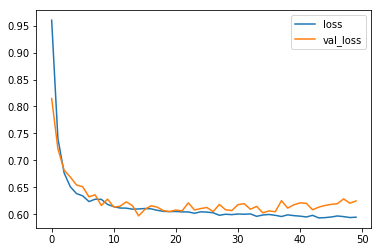

525/525 [==============================] - 177s 337ms/step - loss: 0.5945 - binary_accuracy: 0.7187 - val_loss: 0.6248 - val_binary_accuracy: 0.6897
Epoch 51/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6194 - binary_accuracy: 0.7101


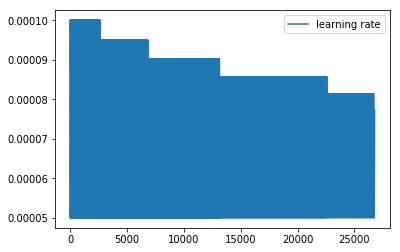


Epoch 00051: val_loss did not improve from 0.59710


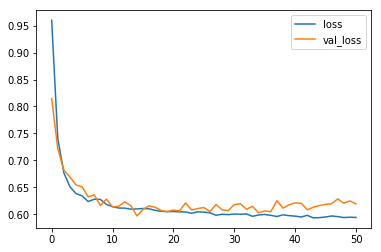

525/525 [==============================] - 177s 338ms/step - loss: 0.5942 - binary_accuracy: 0.7194 - val_loss: 0.6194 - val_binary_accuracy: 0.7101
Epoch 52/300
59/59 [==============================] - 7s 119ms/step - loss: 0.6217 - binary_accuracy: 0.6986


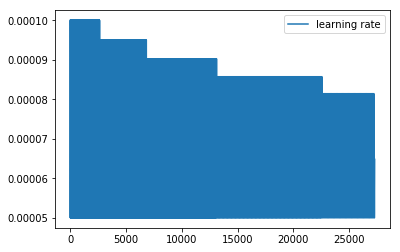


Epoch 00052: val_loss did not improve from 0.59710


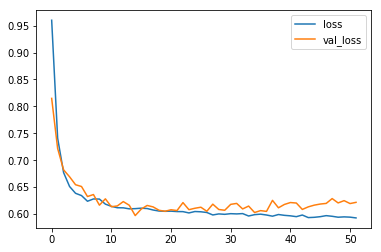

525/525 [==============================] - 177s 337ms/step - loss: 0.5929 - binary_accuracy: 0.7231 - val_loss: 0.6217 - val_binary_accuracy: 0.6986
Epoch 53/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6068 - binary_accuracy: 0.7101


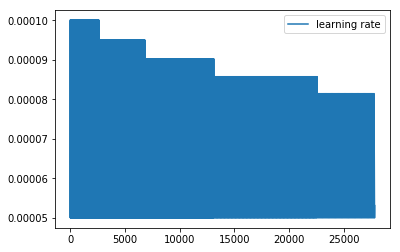


Epoch 00053: val_loss did not improve from 0.59710


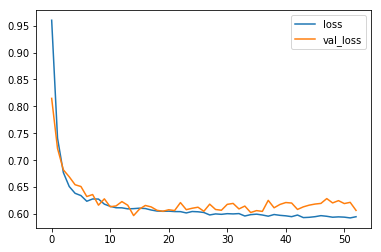

525/525 [==============================] - 177s 337ms/step - loss: 0.5955 - binary_accuracy: 0.7200 - val_loss: 0.6068 - val_binary_accuracy: 0.7101
Epoch 54/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6082 - binary_accuracy: 0.7144


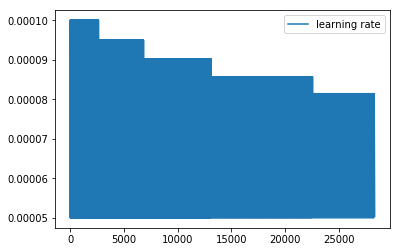


Epoch 00054: val_loss did not improve from 0.59710


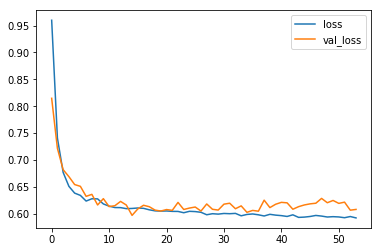

525/525 [==============================] - 177s 337ms/step - loss: 0.5923 - binary_accuracy: 0.7210 - val_loss: 0.6082 - val_binary_accuracy: 0.7144
Epoch 55/300
59/59 [==============================] - 7s 119ms/step - loss: 0.6149 - binary_accuracy: 0.7142


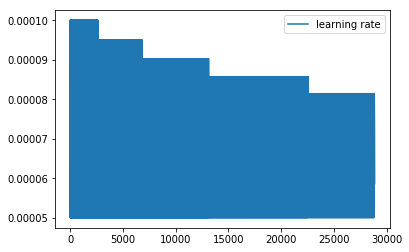


Epoch 00055: val_loss did not improve from 0.59710


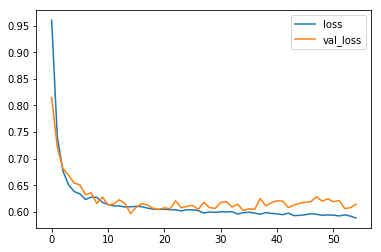

525/525 [==============================] - 177s 337ms/step - loss: 0.5889 - binary_accuracy: 0.7241 - val_loss: 0.6149 - val_binary_accuracy: 0.7142
Epoch 56/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6087 - binary_accuracy: 0.7093


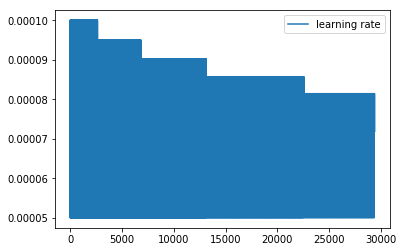


Epoch 00056: val_loss did not improve from 0.59710


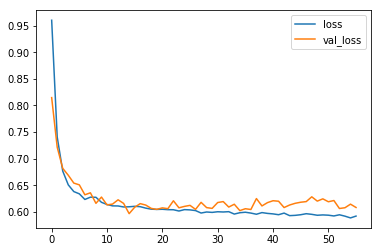

525/525 [==============================] - 177s 337ms/step - loss: 0.5923 - binary_accuracy: 0.7232 - val_loss: 0.6087 - val_binary_accuracy: 0.7093
Epoch 57/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6139 - binary_accuracy: 0.7034


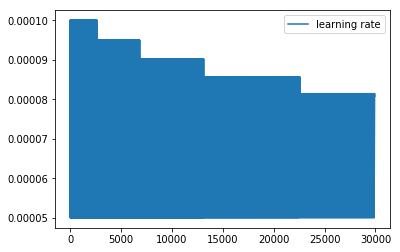


Epoch 00057: val_loss did not improve from 0.59710


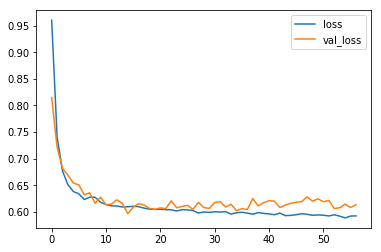

525/525 [==============================] - 177s 337ms/step - loss: 0.5929 - binary_accuracy: 0.7207 - val_loss: 0.6139 - val_binary_accuracy: 0.7034
Epoch 58/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6192 - binary_accuracy: 0.6978


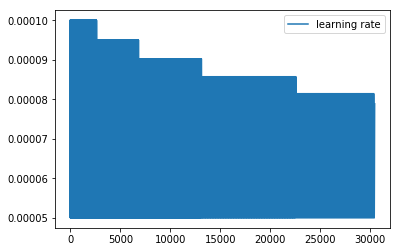


Epoch 00058: val_loss did not improve from 0.59710


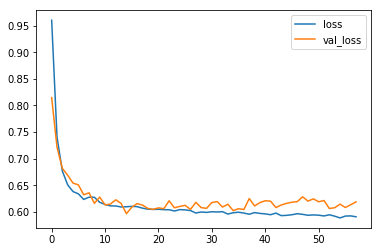

525/525 [==============================] - 178s 338ms/step - loss: 0.5910 - binary_accuracy: 0.7220 - val_loss: 0.6192 - val_binary_accuracy: 0.6978
Epoch 59/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6137 - binary_accuracy: 0.7064


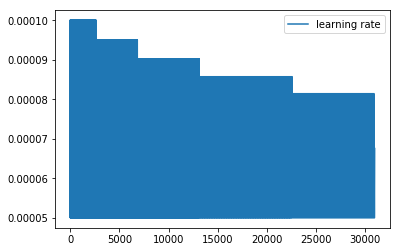


Epoch 00059: val_loss did not improve from 0.59710


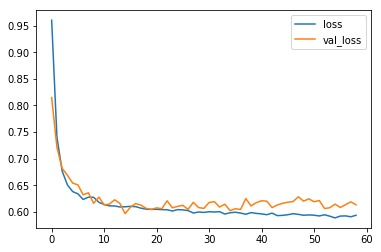

525/525 [==============================] - 177s 337ms/step - loss: 0.5940 - binary_accuracy: 0.7207 - val_loss: 0.6137 - val_binary_accuracy: 0.7064
Epoch 60/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6148 - binary_accuracy: 0.7056


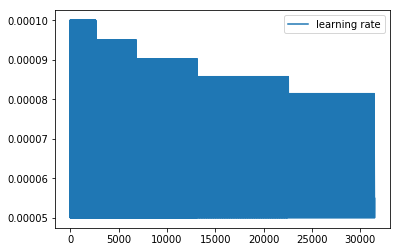


Epoch 00060: val_loss did not improve from 0.59710


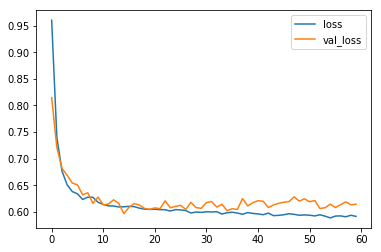

525/525 [==============================] - 177s 337ms/step - loss: 0.5921 - binary_accuracy: 0.7227 - val_loss: 0.6148 - val_binary_accuracy: 0.7056
Epoch 61/300
59/59 [==============================] - 7s 119ms/step - loss: 0.6151 - binary_accuracy: 0.7008


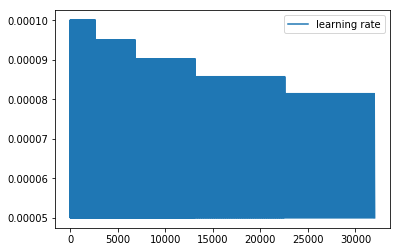


Epoch 00061: val_loss did not improve from 0.59710


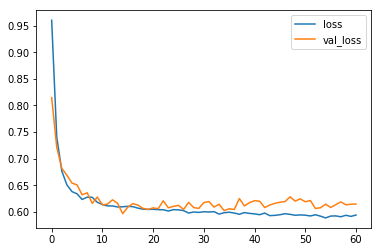

525/525 [==============================] - 177s 337ms/step - loss: 0.5945 - binary_accuracy: 0.7214 - val_loss: 0.6151 - val_binary_accuracy: 0.7008
Epoch 62/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6144 - binary_accuracy: 0.7059


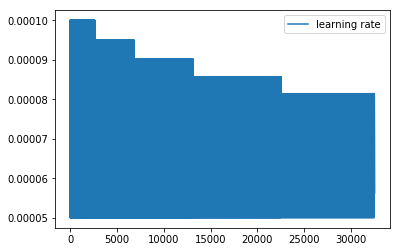


Epoch 00062: val_loss did not improve from 0.59710


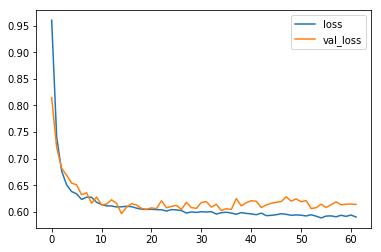

525/525 [==============================] - 177s 337ms/step - loss: 0.5911 - binary_accuracy: 0.7243 - val_loss: 0.6144 - val_binary_accuracy: 0.7059
Epoch 63/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6160 - binary_accuracy: 0.7034


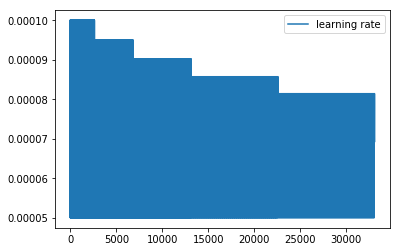


Epoch 00063: val_loss did not improve from 0.59710


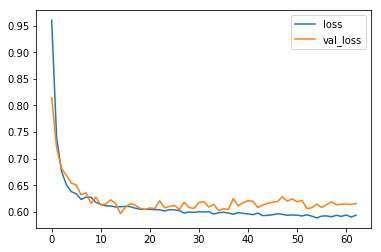

525/525 [==============================] - 177s 337ms/step - loss: 0.5939 - binary_accuracy: 0.7208 - val_loss: 0.6160 - val_binary_accuracy: 0.7034
Epoch 64/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6076 - binary_accuracy: 0.7112


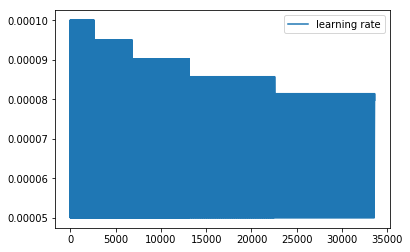


Epoch 00064: val_loss did not improve from 0.59710


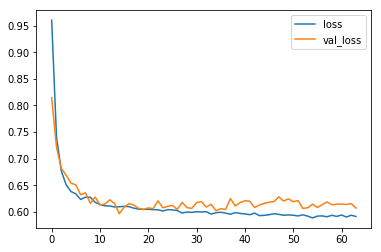

525/525 [==============================] - 177s 337ms/step - loss: 0.5916 - binary_accuracy: 0.7211 - val_loss: 0.6076 - val_binary_accuracy: 0.7112
Epoch 65/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6113 - binary_accuracy: 0.7077


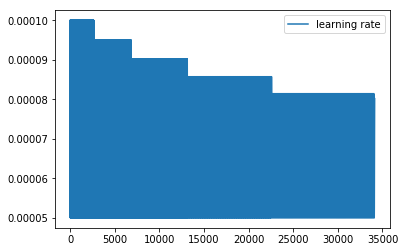


Epoch 00065: val_loss did not improve from 0.59710


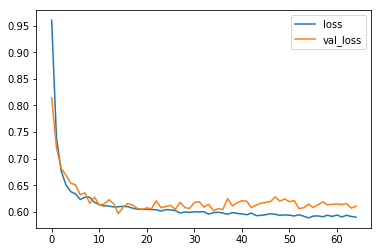

525/525 [==============================] - 177s 338ms/step - loss: 0.5907 - binary_accuracy: 0.7227 - val_loss: 0.6113 - val_binary_accuracy: 0.7077
Epoch 66/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6125 - binary_accuracy: 0.7018


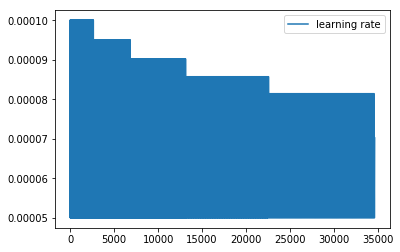


Epoch 00066: val_loss did not improve from 0.59710


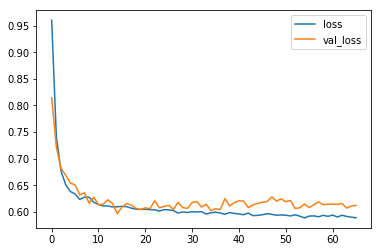

525/525 [==============================] - 177s 337ms/step - loss: 0.5893 - binary_accuracy: 0.7227 - val_loss: 0.6125 - val_binary_accuracy: 0.7018
Epoch 67/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6155 - binary_accuracy: 0.7112


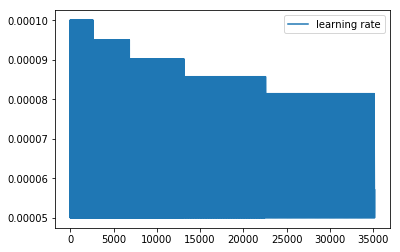


Epoch 00067: val_loss did not improve from 0.59710


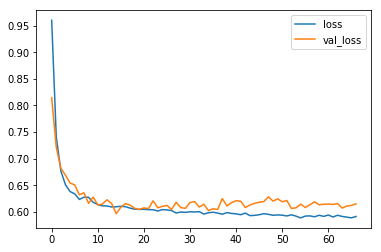

525/525 [==============================] - 177s 337ms/step - loss: 0.5916 - binary_accuracy: 0.7239 - val_loss: 0.6155 - val_binary_accuracy: 0.7112
Epoch 68/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6176 - binary_accuracy: 0.6991


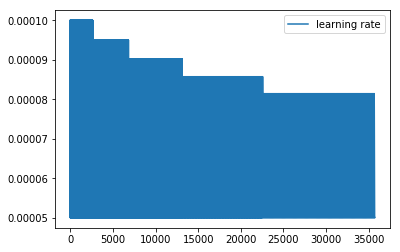


Epoch 00068: val_loss did not improve from 0.59710


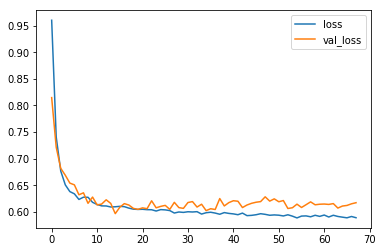

525/525 [==============================] - 177s 337ms/step - loss: 0.5895 - binary_accuracy: 0.7242 - val_loss: 0.6176 - val_binary_accuracy: 0.6991
Epoch 69/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6163 - binary_accuracy: 0.7136


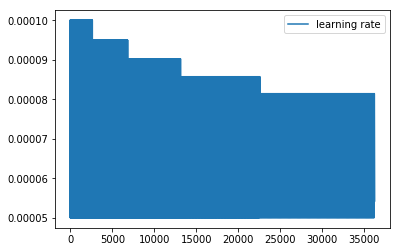


Epoch 00069: val_loss did not improve from 0.59710


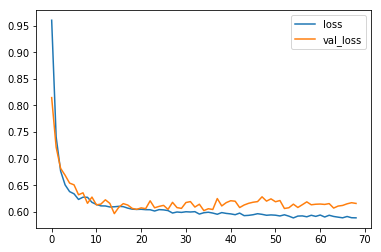

525/525 [==============================] - 177s 337ms/step - loss: 0.5890 - binary_accuracy: 0.7229 - val_loss: 0.6163 - val_binary_accuracy: 0.7136
Epoch 70/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6121 - binary_accuracy: 0.7072


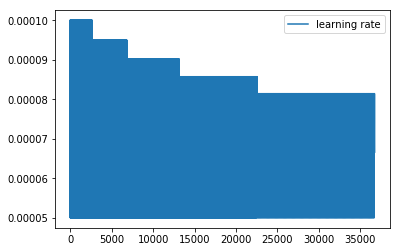


Epoch 00070: val_loss did not improve from 0.59710


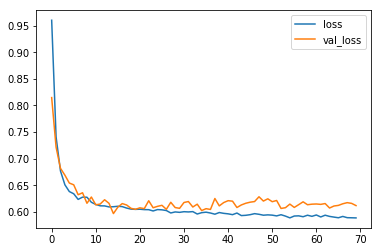

525/525 [==============================] - 177s 337ms/step - loss: 0.5887 - binary_accuracy: 0.7222 - val_loss: 0.6121 - val_binary_accuracy: 0.7072
Epoch 71/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6146 - binary_accuracy: 0.7061


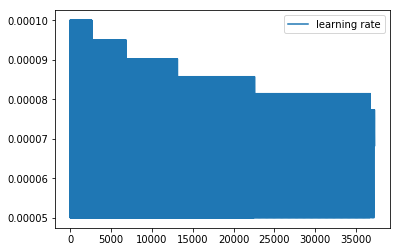


Epoch 00071: val_loss did not improve from 0.59710


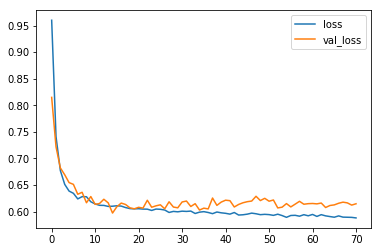

525/525 [==============================] - 177s 337ms/step - loss: 0.5879 - binary_accuracy: 0.7256 - val_loss: 0.6146 - val_binary_accuracy: 0.7061
Epoch 72/300
59/59 [==============================] - 7s 122ms/step - loss: 0.6159 - binary_accuracy: 0.7069


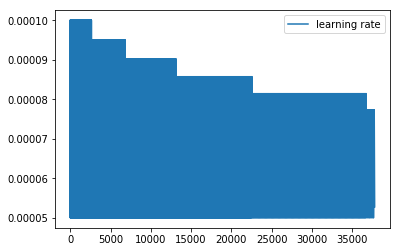


Epoch 00072: val_loss did not improve from 0.59710


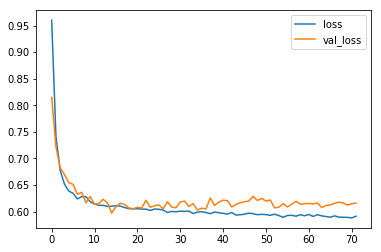

525/525 [==============================] - 177s 338ms/step - loss: 0.5913 - binary_accuracy: 0.7275 - val_loss: 0.6159 - val_binary_accuracy: 0.7069
Epoch 73/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6186 - binary_accuracy: 0.7034


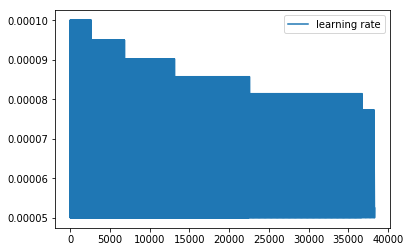


Epoch 00073: val_loss did not improve from 0.59710


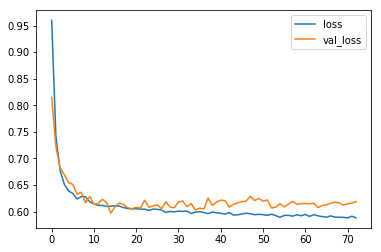

525/525 [==============================] - 177s 337ms/step - loss: 0.5882 - binary_accuracy: 0.7238 - val_loss: 0.6186 - val_binary_accuracy: 0.7034
Epoch 74/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6192 - binary_accuracy: 0.7016


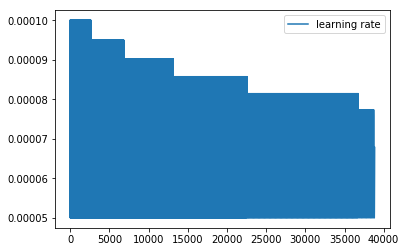


Epoch 00074: val_loss did not improve from 0.59710


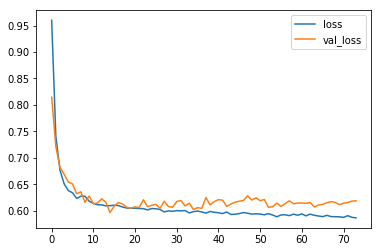

525/525 [==============================] - 177s 337ms/step - loss: 0.5868 - binary_accuracy: 0.7244 - val_loss: 0.6192 - val_binary_accuracy: 0.7016
Epoch 75/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6179 - binary_accuracy: 0.6948


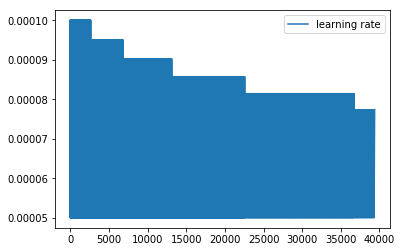


Epoch 00075: val_loss did not improve from 0.59710


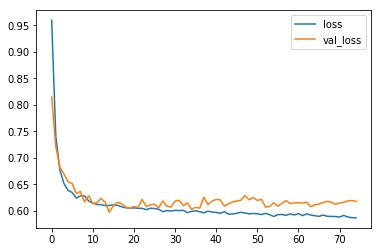

525/525 [==============================] - 177s 337ms/step - loss: 0.5863 - binary_accuracy: 0.7273 - val_loss: 0.6179 - val_binary_accuracy: 0.6948
Epoch 76/300
59/59 [==============================] - 7s 122ms/step - loss: 0.6287 - binary_accuracy: 0.6860


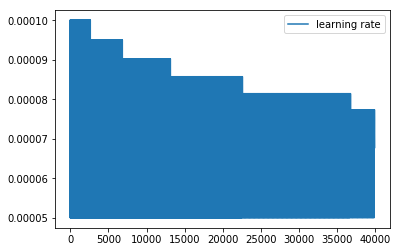


Epoch 00076: val_loss did not improve from 0.59710


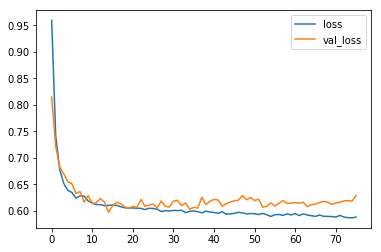

525/525 [==============================] - 177s 337ms/step - loss: 0.5878 - binary_accuracy: 0.7236 - val_loss: 0.6287 - val_binary_accuracy: 0.6860
Epoch 77/300
59/59 [==============================] - 7s 122ms/step - loss: 0.6220 - binary_accuracy: 0.6970


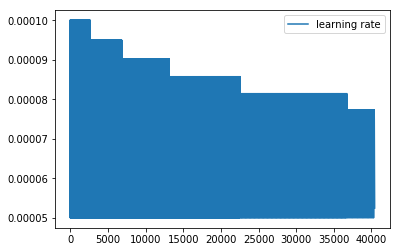


Epoch 00077: val_loss did not improve from 0.59710


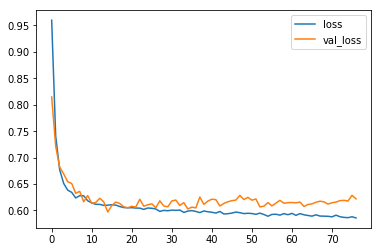

525/525 [==============================] - 177s 338ms/step - loss: 0.5858 - binary_accuracy: 0.7262 - val_loss: 0.6220 - val_binary_accuracy: 0.6970
Epoch 78/300
59/59 [==============================] - 7s 122ms/step - loss: 0.6189 - binary_accuracy: 0.6986


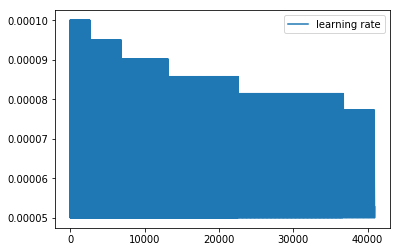


Epoch 00078: val_loss did not improve from 0.59710


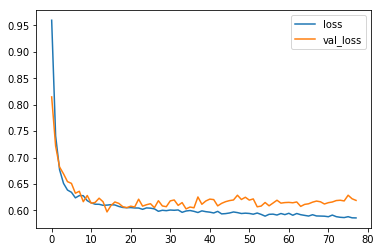

525/525 [==============================] - 177s 337ms/step - loss: 0.5859 - binary_accuracy: 0.7277 - val_loss: 0.6189 - val_binary_accuracy: 0.6986
Epoch 79/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6191 - binary_accuracy: 0.7040


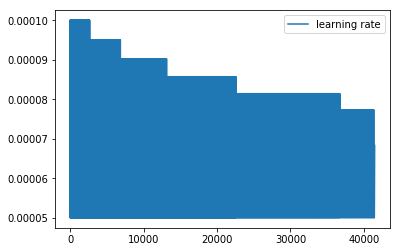


Epoch 00079: val_loss did not improve from 0.59710


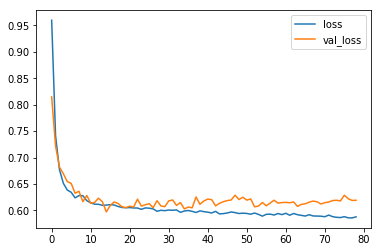

525/525 [==============================] - 177s 338ms/step - loss: 0.5879 - binary_accuracy: 0.7245 - val_loss: 0.6191 - val_binary_accuracy: 0.7040
Epoch 80/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6194 - binary_accuracy: 0.7053


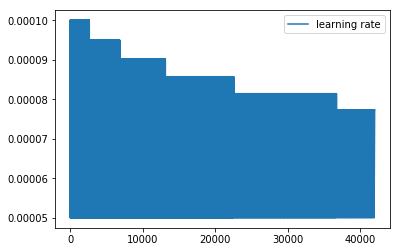


Epoch 00080: val_loss did not improve from 0.59710


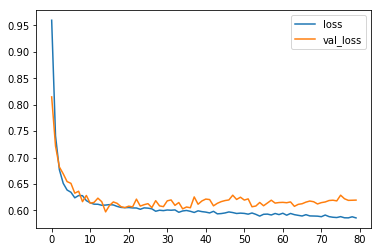

525/525 [==============================] - 177s 337ms/step - loss: 0.5853 - binary_accuracy: 0.7240 - val_loss: 0.6194 - val_binary_accuracy: 0.7053
Epoch 81/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6262 - binary_accuracy: 0.6943


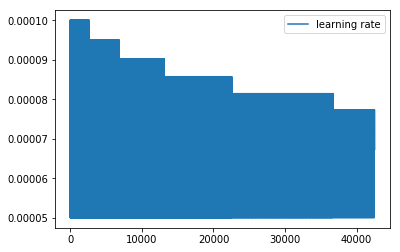


Epoch 00081: val_loss did not improve from 0.59710


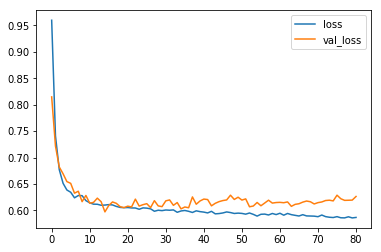

525/525 [==============================] - 177s 337ms/step - loss: 0.5863 - binary_accuracy: 0.7244 - val_loss: 0.6262 - val_binary_accuracy: 0.6943
Epoch 82/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6190 - binary_accuracy: 0.6951


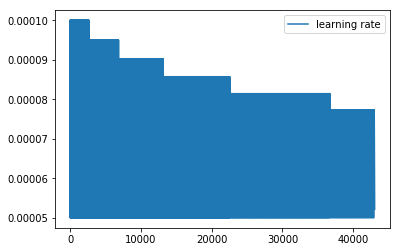


Epoch 00082: val_loss did not improve from 0.59710


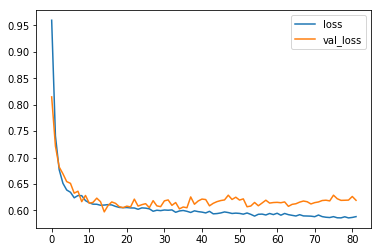

525/525 [==============================] - 177s 337ms/step - loss: 0.5882 - binary_accuracy: 0.7234 - val_loss: 0.6190 - val_binary_accuracy: 0.6951
Epoch 83/300
59/59 [==============================] - 7s 119ms/step - loss: 0.6303 - binary_accuracy: 0.6828


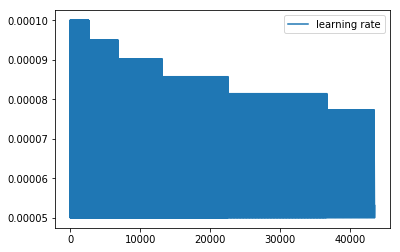


Epoch 00083: val_loss did not improve from 0.59710


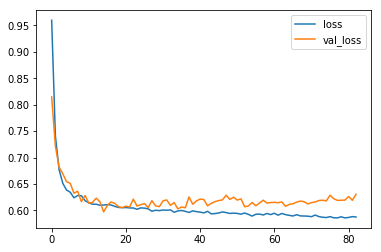

525/525 [==============================] - 177s 337ms/step - loss: 0.5871 - binary_accuracy: 0.7247 - val_loss: 0.6303 - val_binary_accuracy: 0.6828
Epoch 84/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6152 - binary_accuracy: 0.6973


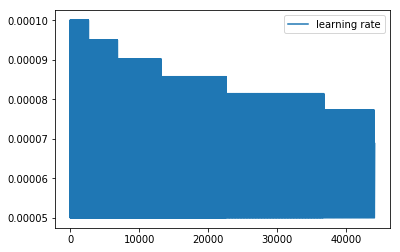


Epoch 00084: val_loss did not improve from 0.59710


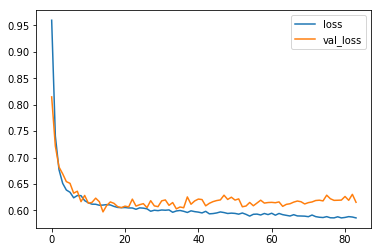

525/525 [==============================] - 177s 337ms/step - loss: 0.5856 - binary_accuracy: 0.7215 - val_loss: 0.6152 - val_binary_accuracy: 0.6973
Epoch 85/300
59/59 [==============================] - 7s 122ms/step - loss: 0.6427 - binary_accuracy: 0.6656


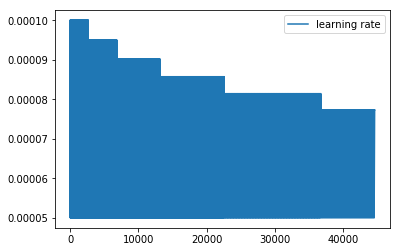


Epoch 00085: val_loss did not improve from 0.59710


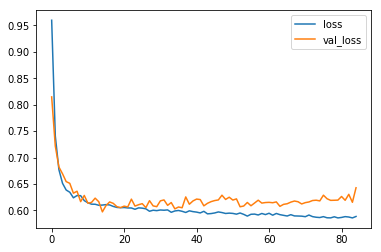

525/525 [==============================] - 177s 338ms/step - loss: 0.5887 - binary_accuracy: 0.7237 - val_loss: 0.6427 - val_binary_accuracy: 0.6656
Epoch 86/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6211 - binary_accuracy: 0.7005


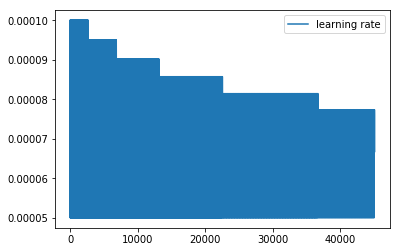


Epoch 00086: val_loss did not improve from 0.59710


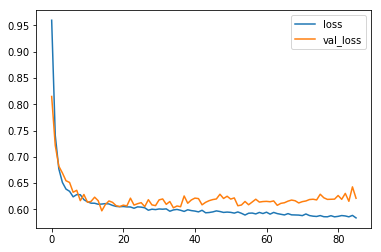

525/525 [==============================] - 177s 337ms/step - loss: 0.5838 - binary_accuracy: 0.7274 - val_loss: 0.6211 - val_binary_accuracy: 0.7005
Epoch 87/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6188 - binary_accuracy: 0.7029


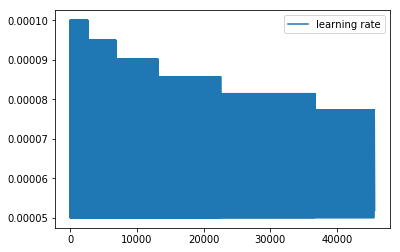


Epoch 00087: val_loss did not improve from 0.59710


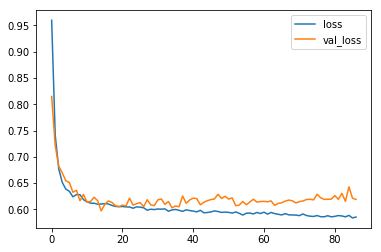

525/525 [==============================] - 177s 337ms/step - loss: 0.5850 - binary_accuracy: 0.7254 - val_loss: 0.6188 - val_binary_accuracy: 0.7029
Epoch 88/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6122 - binary_accuracy: 0.7104


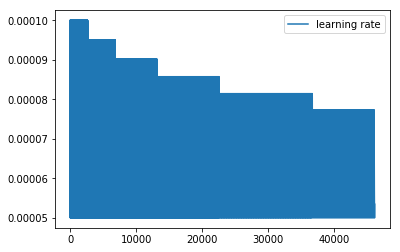


Epoch 00088: val_loss did not improve from 0.59710


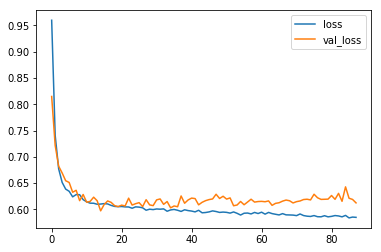

525/525 [==============================] - 177s 337ms/step - loss: 0.5846 - binary_accuracy: 0.7277 - val_loss: 0.6122 - val_binary_accuracy: 0.7104
Epoch 89/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6228 - binary_accuracy: 0.7037


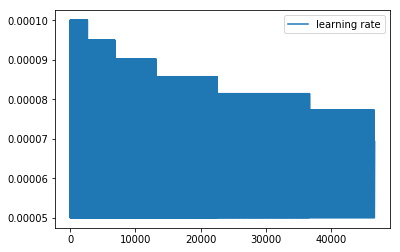


Epoch 00089: val_loss did not improve from 0.59710


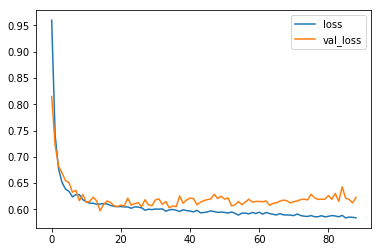

525/525 [==============================] - 177s 337ms/step - loss: 0.5835 - binary_accuracy: 0.7262 - val_loss: 0.6228 - val_binary_accuracy: 0.7037
Epoch 90/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6195 - binary_accuracy: 0.7037


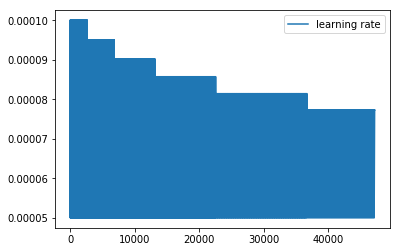


Epoch 00090: val_loss did not improve from 0.59710


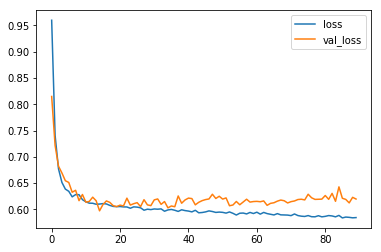

525/525 [==============================] - 177s 337ms/step - loss: 0.5840 - binary_accuracy: 0.7266 - val_loss: 0.6195 - val_binary_accuracy: 0.7037
Epoch 91/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6240 - binary_accuracy: 0.7008


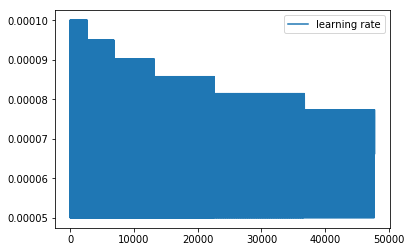


Epoch 00091: val_loss did not improve from 0.59710


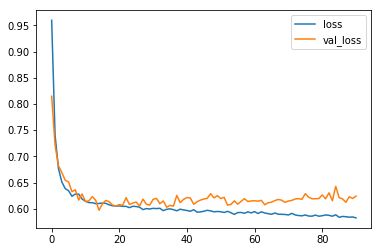

525/525 [==============================] - 177s 337ms/step - loss: 0.5825 - binary_accuracy: 0.7289 - val_loss: 0.6240 - val_binary_accuracy: 0.7008
Epoch 92/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6198 - binary_accuracy: 0.7083


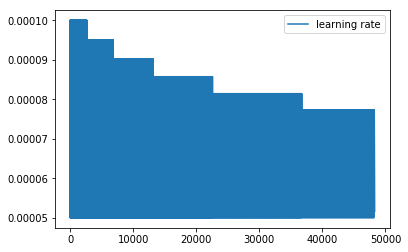


Epoch 00092: val_loss did not improve from 0.59710


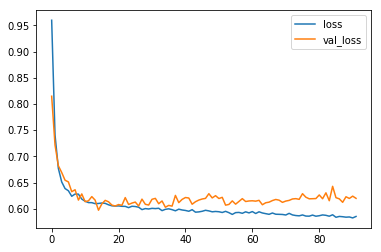

525/525 [==============================] - 177s 338ms/step - loss: 0.5851 - binary_accuracy: 0.7264 - val_loss: 0.6198 - val_binary_accuracy: 0.7083
Epoch 93/300
59/59 [==============================] - 7s 119ms/step - loss: 0.6327 - binary_accuracy: 0.6836


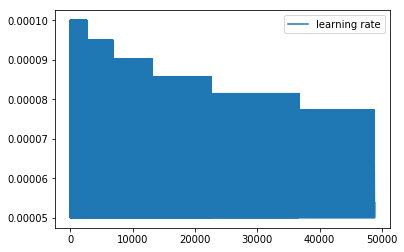


Epoch 00093: val_loss did not improve from 0.59710


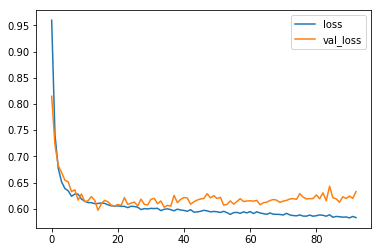

525/525 [==============================] - 177s 337ms/step - loss: 0.5831 - binary_accuracy: 0.7281 - val_loss: 0.6327 - val_binary_accuracy: 0.6836
Epoch 94/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6232 - binary_accuracy: 0.7037


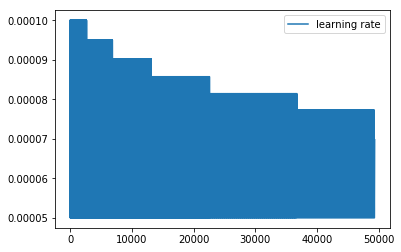


Epoch 00094: val_loss did not improve from 0.59710


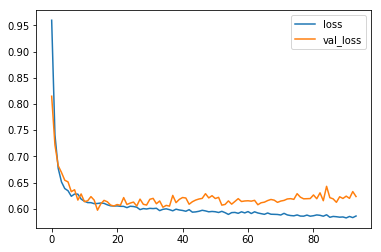

525/525 [==============================] - 177s 337ms/step - loss: 0.5861 - binary_accuracy: 0.7284 - val_loss: 0.6232 - val_binary_accuracy: 0.7037
Epoch 95/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6243 - binary_accuracy: 0.6999


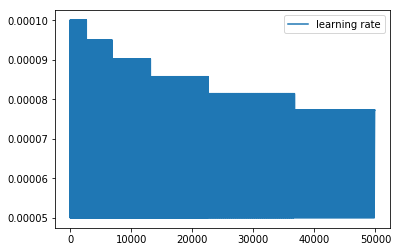


Epoch 00095: val_loss did not improve from 0.59710


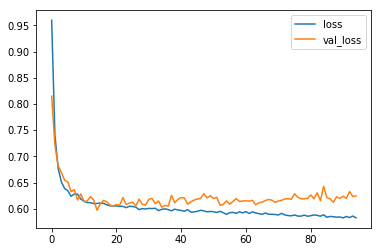

525/525 [==============================] - 177s 337ms/step - loss: 0.5826 - binary_accuracy: 0.7289 - val_loss: 0.6243 - val_binary_accuracy: 0.6999
Epoch 96/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6241 - binary_accuracy: 0.6973


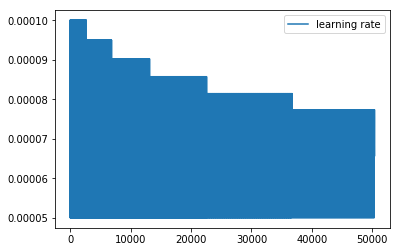


Epoch 00096: val_loss did not improve from 0.59710


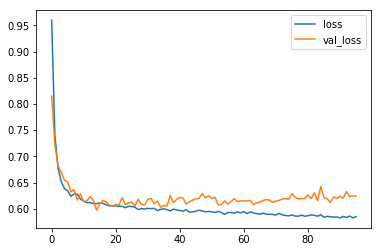

525/525 [==============================] - 177s 337ms/step - loss: 0.5846 - binary_accuracy: 0.7279 - val_loss: 0.6241 - val_binary_accuracy: 0.6973
Epoch 97/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6319 - binary_accuracy: 0.6830


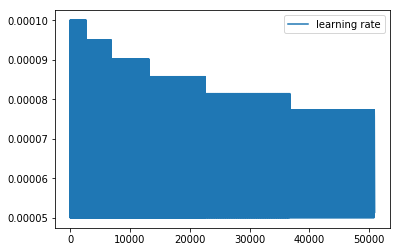


Epoch 00097: val_loss did not improve from 0.59710


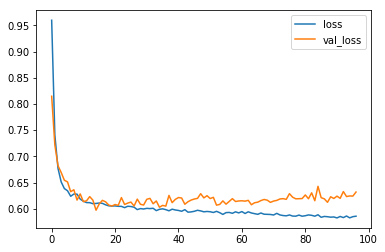

525/525 [==============================] - 177s 337ms/step - loss: 0.5855 - binary_accuracy: 0.7260 - val_loss: 0.6319 - val_binary_accuracy: 0.6830
Epoch 98/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6282 - binary_accuracy: 0.6914


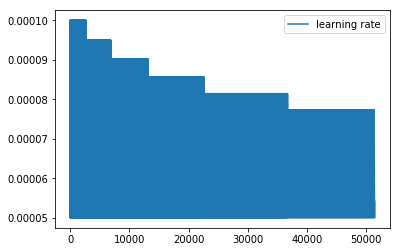


Epoch 00098: val_loss did not improve from 0.59710


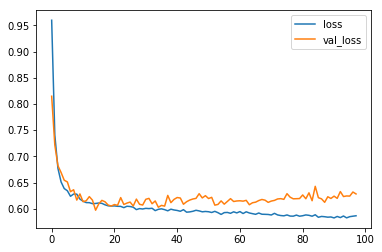

525/525 [==============================] - 177s 337ms/step - loss: 0.5863 - binary_accuracy: 0.7258 - val_loss: 0.6282 - val_binary_accuracy: 0.6914
Epoch 99/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6260 - binary_accuracy: 0.6871


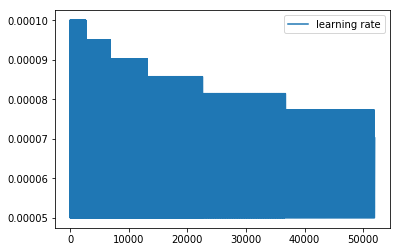


Epoch 00099: val_loss did not improve from 0.59710


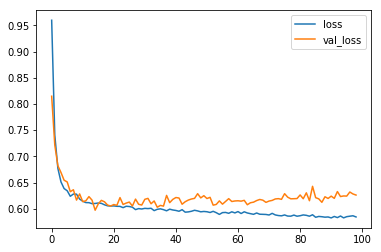

525/525 [==============================] - 178s 338ms/step - loss: 0.5840 - binary_accuracy: 0.7250 - val_loss: 0.6260 - val_binary_accuracy: 0.6871
Epoch 100/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6441 - binary_accuracy: 0.6551


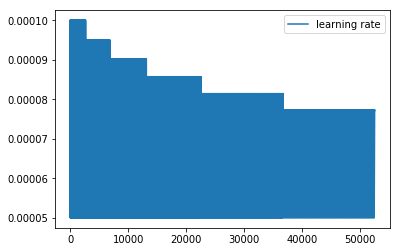


Epoch 00100: val_loss did not improve from 0.59710


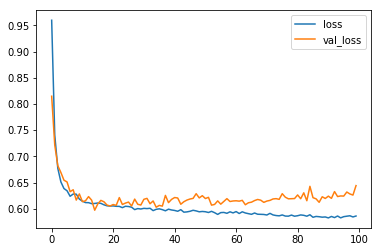

525/525 [==============================] - 177s 337ms/step - loss: 0.5861 - binary_accuracy: 0.7274 - val_loss: 0.6441 - val_binary_accuracy: 0.6551
Epoch 101/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6245 - binary_accuracy: 0.6897


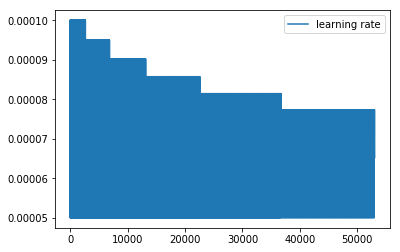


Epoch 00101: val_loss did not improve from 0.59710


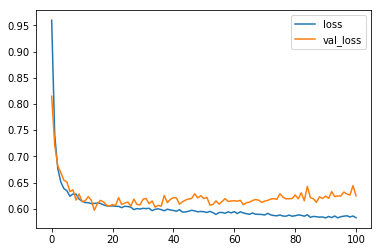

525/525 [==============================] - 177s 337ms/step - loss: 0.5831 - binary_accuracy: 0.7271 - val_loss: 0.6245 - val_binary_accuracy: 0.6897
Epoch 102/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6256 - binary_accuracy: 0.6997


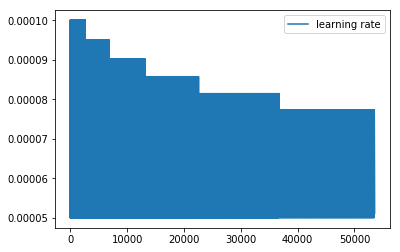


Epoch 00102: val_loss did not improve from 0.59710


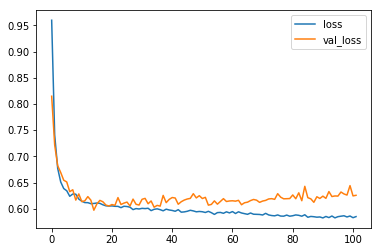

525/525 [==============================] - 177s 337ms/step - loss: 0.5847 - binary_accuracy: 0.7253 - val_loss: 0.6256 - val_binary_accuracy: 0.6997
Epoch 103/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6291 - binary_accuracy: 0.6916


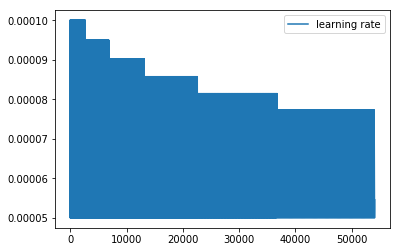


Epoch 00103: val_loss did not improve from 0.59710


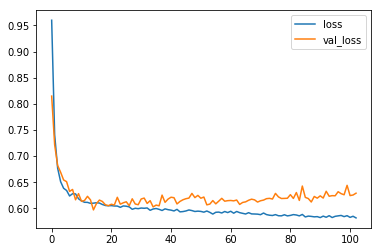

525/525 [==============================] - 177s 337ms/step - loss: 0.5818 - binary_accuracy: 0.7293 - val_loss: 0.6291 - val_binary_accuracy: 0.6916
Epoch 104/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6232 - binary_accuracy: 0.7075


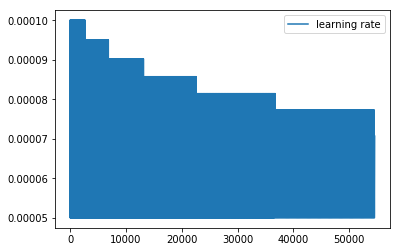


Epoch 00104: val_loss did not improve from 0.59710


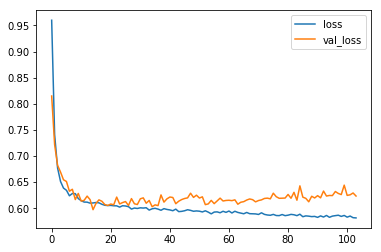

525/525 [==============================] - 177s 337ms/step - loss: 0.5811 - binary_accuracy: 0.7296 - val_loss: 0.6232 - val_binary_accuracy: 0.7075
Epoch 105/300
59/59 [==============================] - 7s 122ms/step - loss: 0.6295 - binary_accuracy: 0.6965


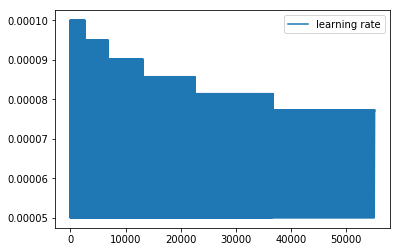


Epoch 00105: val_loss did not improve from 0.59710


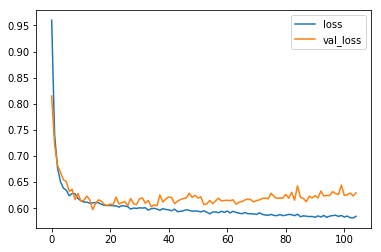

525/525 [==============================] - 177s 337ms/step - loss: 0.5848 - binary_accuracy: 0.7238 - val_loss: 0.6295 - val_binary_accuracy: 0.6965
Epoch 106/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6229 - binary_accuracy: 0.7064


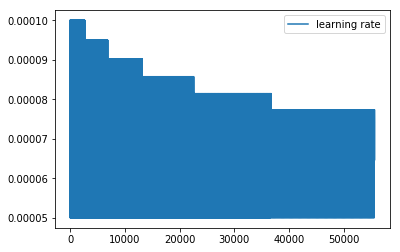


Epoch 00106: val_loss did not improve from 0.59710


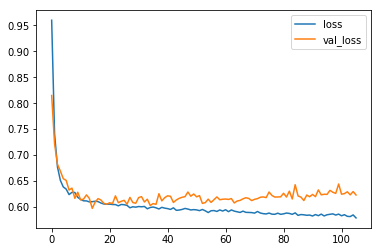

525/525 [==============================] - 178s 338ms/step - loss: 0.5786 - binary_accuracy: 0.7295 - val_loss: 0.6229 - val_binary_accuracy: 0.7064
Epoch 107/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6237 - binary_accuracy: 0.7008


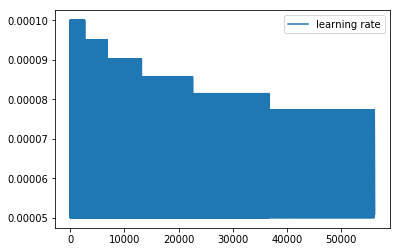


Epoch 00107: val_loss did not improve from 0.59710


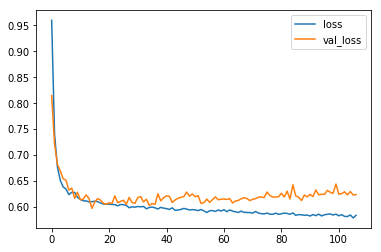

525/525 [==============================] - 177s 337ms/step - loss: 0.5836 - binary_accuracy: 0.7270 - val_loss: 0.6237 - val_binary_accuracy: 0.7008
Epoch 108/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6313 - binary_accuracy: 0.6897


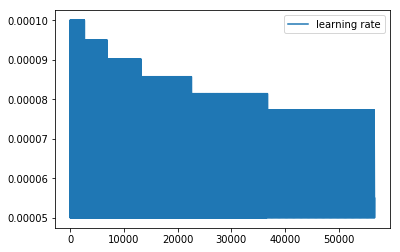


Epoch 00108: val_loss did not improve from 0.59710


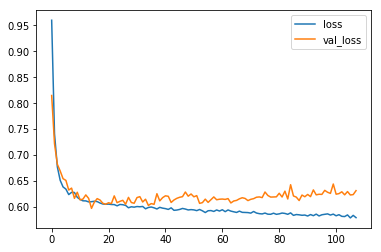

525/525 [==============================] - 177s 337ms/step - loss: 0.5792 - binary_accuracy: 0.7313 - val_loss: 0.6313 - val_binary_accuracy: 0.6897
Epoch 109/300
59/59 [==============================] - 7s 119ms/step - loss: 0.6302 - binary_accuracy: 0.6983


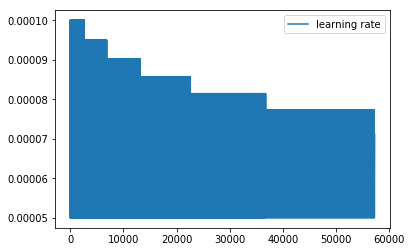


Epoch 00109: val_loss did not improve from 0.59710


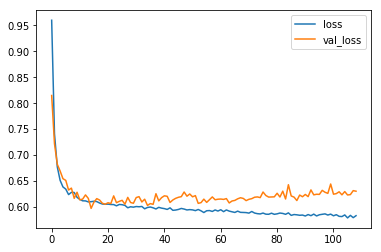

525/525 [==============================] - 177s 337ms/step - loss: 0.5828 - binary_accuracy: 0.7269 - val_loss: 0.6302 - val_binary_accuracy: 0.6983
Epoch 110/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6258 - binary_accuracy: 0.6994


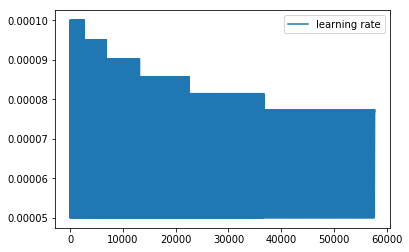


Epoch 00110: val_loss did not improve from 0.59710


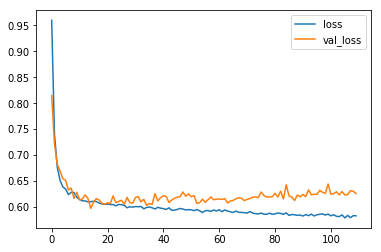

525/525 [==============================] - 177s 337ms/step - loss: 0.5829 - binary_accuracy: 0.7313 - val_loss: 0.6258 - val_binary_accuracy: 0.6994
Epoch 111/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6244 - binary_accuracy: 0.6975


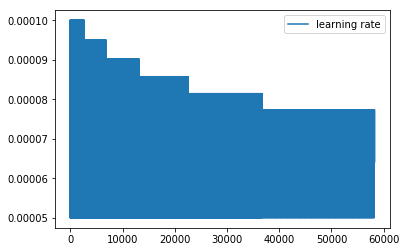


Epoch 00111: val_loss did not improve from 0.59710


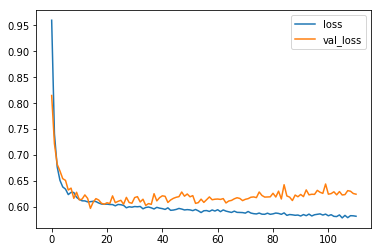

525/525 [==============================] - 177s 337ms/step - loss: 0.5819 - binary_accuracy: 0.7264 - val_loss: 0.6244 - val_binary_accuracy: 0.6975
Epoch 112/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6265 - binary_accuracy: 0.6940


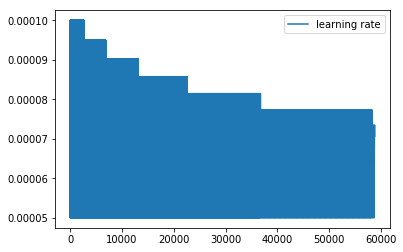


Epoch 00112: val_loss did not improve from 0.59710


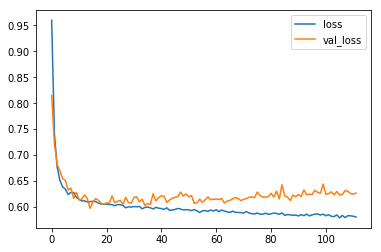

525/525 [==============================] - 177s 337ms/step - loss: 0.5805 - binary_accuracy: 0.7322 - val_loss: 0.6265 - val_binary_accuracy: 0.6940
Epoch 113/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6233 - binary_accuracy: 0.7002


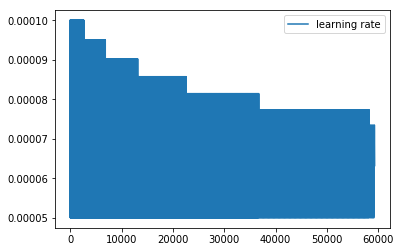


Epoch 00113: val_loss did not improve from 0.59710


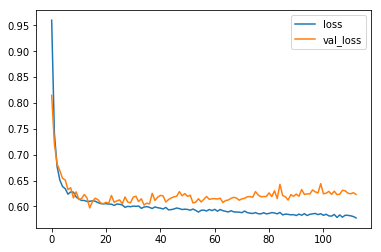

525/525 [==============================] - 177s 338ms/step - loss: 0.5782 - binary_accuracy: 0.7342 - val_loss: 0.6233 - val_binary_accuracy: 0.7002
Epoch 114/300
59/59 [==============================] - 7s 122ms/step - loss: 0.6253 - binary_accuracy: 0.6967


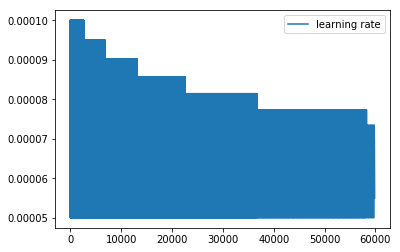


Epoch 00114: val_loss did not improve from 0.59710


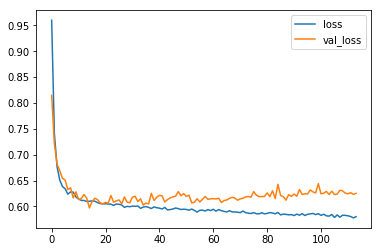

525/525 [==============================] - 177s 337ms/step - loss: 0.5801 - binary_accuracy: 0.7287 - val_loss: 0.6253 - val_binary_accuracy: 0.6967
Epoch 115/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6234 - binary_accuracy: 0.6973


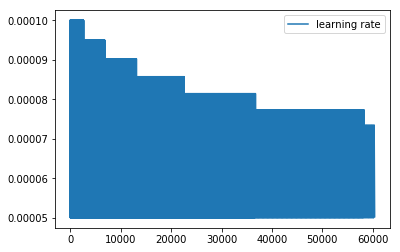


Epoch 00115: val_loss did not improve from 0.59710


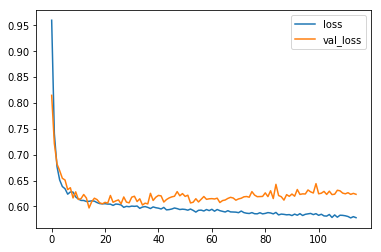

525/525 [==============================] - 177s 337ms/step - loss: 0.5783 - binary_accuracy: 0.7324 - val_loss: 0.6234 - val_binary_accuracy: 0.6973
Epoch 116/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6278 - binary_accuracy: 0.6981


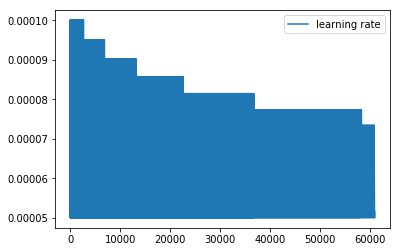


Epoch 00116: val_loss did not improve from 0.59710


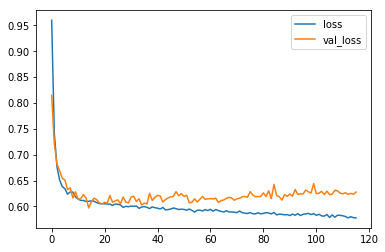

525/525 [==============================] - 177s 337ms/step - loss: 0.5782 - binary_accuracy: 0.7355 - val_loss: 0.6278 - val_binary_accuracy: 0.6981
Epoch 117/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6215 - binary_accuracy: 0.7077


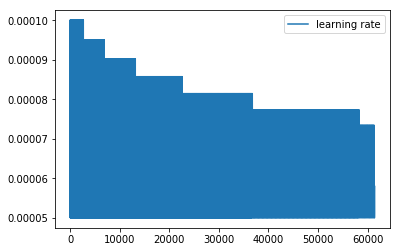


Epoch 00117: val_loss did not improve from 0.59710


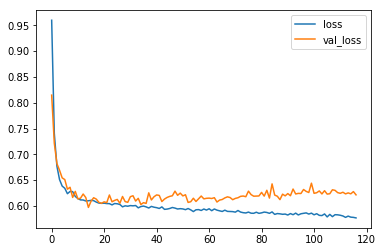

525/525 [==============================] - 177s 337ms/step - loss: 0.5775 - binary_accuracy: 0.7316 - val_loss: 0.6215 - val_binary_accuracy: 0.7077
Epoch 118/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6245 - binary_accuracy: 0.6981


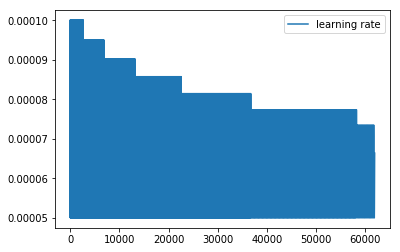


Epoch 00118: val_loss did not improve from 0.59710


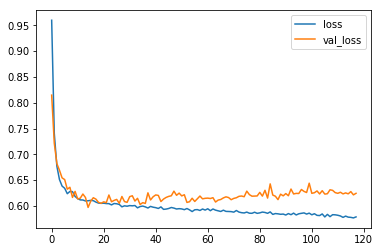

525/525 [==============================] - 177s 337ms/step - loss: 0.5790 - binary_accuracy: 0.7296 - val_loss: 0.6245 - val_binary_accuracy: 0.6981
Epoch 119/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6323 - binary_accuracy: 0.6975


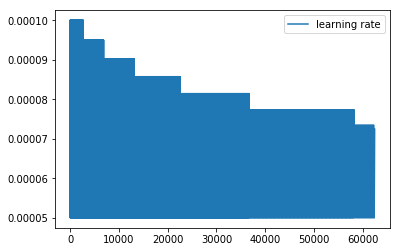


Epoch 00119: val_loss did not improve from 0.59710


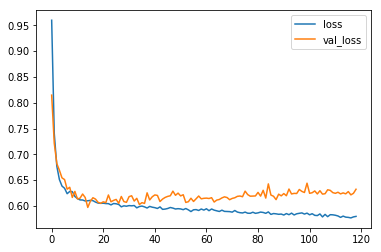

525/525 [==============================] - 177s 337ms/step - loss: 0.5795 - binary_accuracy: 0.7306 - val_loss: 0.6323 - val_binary_accuracy: 0.6975
Epoch 120/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6335 - binary_accuracy: 0.6865


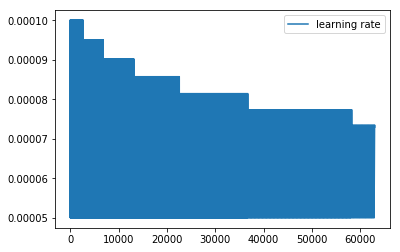


Epoch 00120: val_loss did not improve from 0.59710


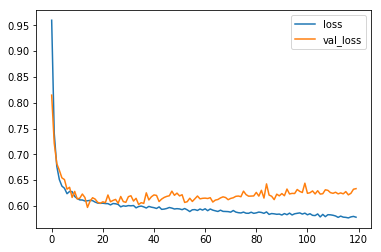

525/525 [==============================] - 177s 338ms/step - loss: 0.5779 - binary_accuracy: 0.7311 - val_loss: 0.6335 - val_binary_accuracy: 0.6865
Epoch 121/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6364 - binary_accuracy: 0.6940


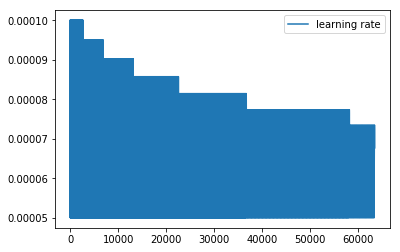


Epoch 00121: val_loss did not improve from 0.59710


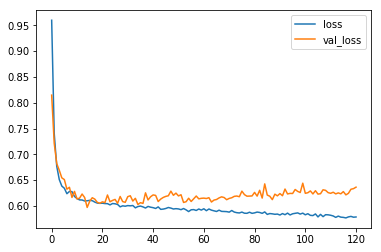

525/525 [==============================] - 177s 337ms/step - loss: 0.5787 - binary_accuracy: 0.7298 - val_loss: 0.6364 - val_binary_accuracy: 0.6940
Epoch 122/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6336 - binary_accuracy: 0.6855


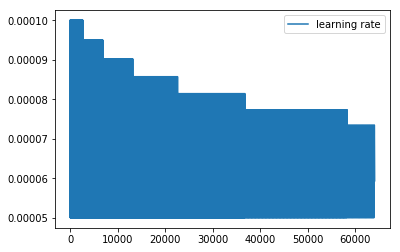


Epoch 00122: val_loss did not improve from 0.59710


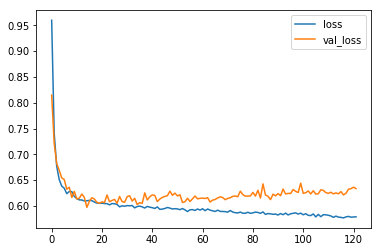

525/525 [==============================] - 177s 337ms/step - loss: 0.5790 - binary_accuracy: 0.7293 - val_loss: 0.6336 - val_binary_accuracy: 0.6855
Epoch 123/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6367 - binary_accuracy: 0.6906


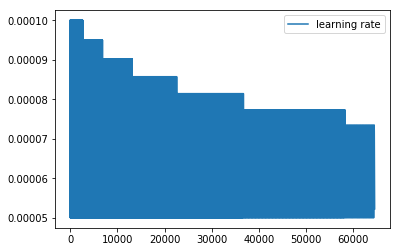


Epoch 00123: val_loss did not improve from 0.59710


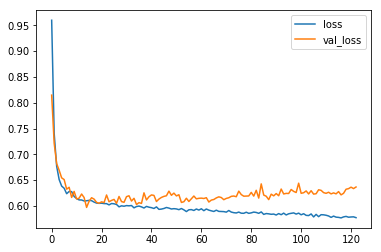

525/525 [==============================] - 177s 337ms/step - loss: 0.5774 - binary_accuracy: 0.7321 - val_loss: 0.6367 - val_binary_accuracy: 0.6906
Epoch 124/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6341 - binary_accuracy: 0.6889


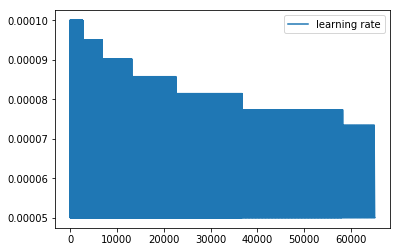


Epoch 00124: val_loss did not improve from 0.59710


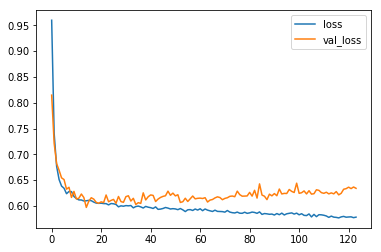

525/525 [==============================] - 177s 337ms/step - loss: 0.5784 - binary_accuracy: 0.7324 - val_loss: 0.6341 - val_binary_accuracy: 0.6889
Epoch 125/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6343 - binary_accuracy: 0.6903


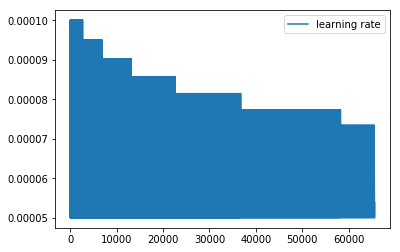


Epoch 00125: val_loss did not improve from 0.59710


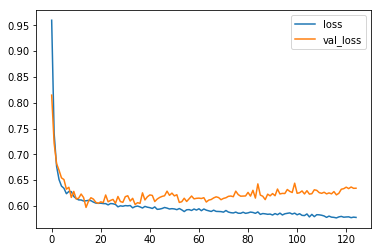

525/525 [==============================] - 177s 337ms/step - loss: 0.5777 - binary_accuracy: 0.7296 - val_loss: 0.6343 - val_binary_accuracy: 0.6903
Epoch 126/300
59/59 [==============================] - 7s 124ms/step - loss: 0.6258 - binary_accuracy: 0.6997


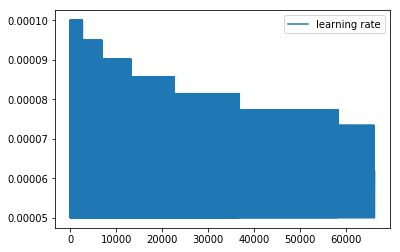


Epoch 00126: val_loss did not improve from 0.59710


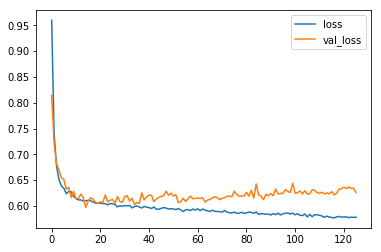

525/525 [==============================] - 177s 338ms/step - loss: 0.5781 - binary_accuracy: 0.7321 - val_loss: 0.6258 - val_binary_accuracy: 0.6997
Epoch 127/300
59/59 [==============================] - 7s 124ms/step - loss: 0.6269 - binary_accuracy: 0.6983


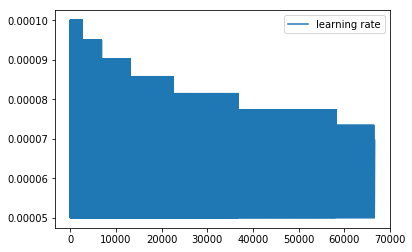


Epoch 00127: val_loss did not improve from 0.59710


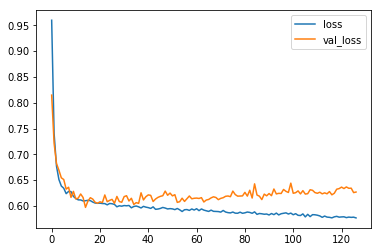

525/525 [==============================] - 183s 349ms/step - loss: 0.5766 - binary_accuracy: 0.7314 - val_loss: 0.6269 - val_binary_accuracy: 0.6983
Epoch 128/300
59/59 [==============================] - 7s 124ms/step - loss: 0.6273 - binary_accuracy: 0.6916


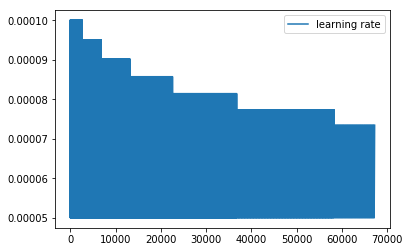


Epoch 00128: val_loss did not improve from 0.59710


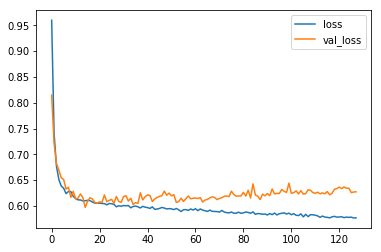

525/525 [==============================] - 183s 349ms/step - loss: 0.5767 - binary_accuracy: 0.7317 - val_loss: 0.6273 - val_binary_accuracy: 0.6916
Epoch 129/300
59/59 [==============================] - 7s 123ms/step - loss: 0.6278 - binary_accuracy: 0.6914


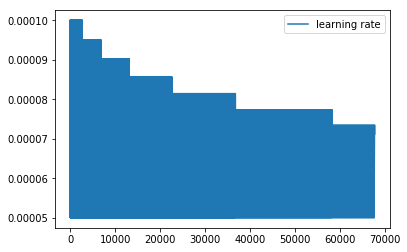


Epoch 00129: val_loss did not improve from 0.59710


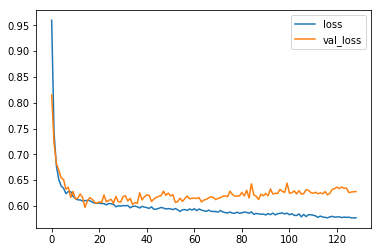

525/525 [==============================] - 183s 348ms/step - loss: 0.5769 - binary_accuracy: 0.7331 - val_loss: 0.6278 - val_binary_accuracy: 0.6914
Epoch 130/300
59/59 [==============================] - 7s 124ms/step - loss: 0.6338 - binary_accuracy: 0.6943


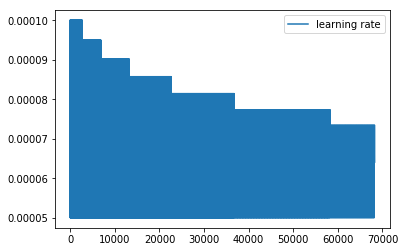


Epoch 00130: val_loss did not improve from 0.59710


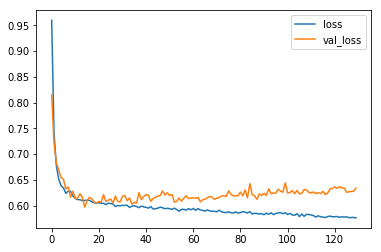

525/525 [==============================] - 183s 349ms/step - loss: 0.5761 - binary_accuracy: 0.7308 - val_loss: 0.6338 - val_binary_accuracy: 0.6943
Epoch 131/300
59/59 [==============================] - 7s 122ms/step - loss: 0.6296 - binary_accuracy: 0.6962


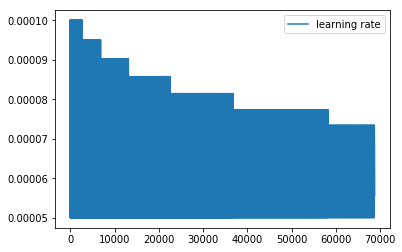


Epoch 00131: val_loss did not improve from 0.59710


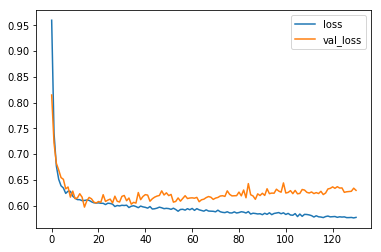

525/525 [==============================] - 183s 348ms/step - loss: 0.5770 - binary_accuracy: 0.7321 - val_loss: 0.6296 - val_binary_accuracy: 0.6962
Epoch 132/300
59/59 [==============================] - 7s 123ms/step - loss: 0.6288 - binary_accuracy: 0.6959


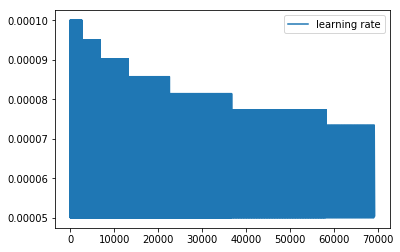


Epoch 00132: val_loss did not improve from 0.59710


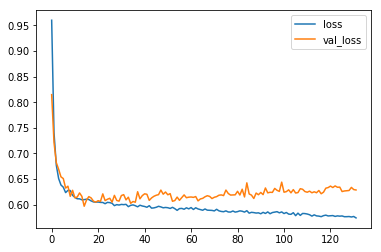

525/525 [==============================] - 183s 349ms/step - loss: 0.5742 - binary_accuracy: 0.7365 - val_loss: 0.6288 - val_binary_accuracy: 0.6959
Epoch 133/300
59/59 [==============================] - 7s 125ms/step - loss: 0.6302 - binary_accuracy: 0.6997


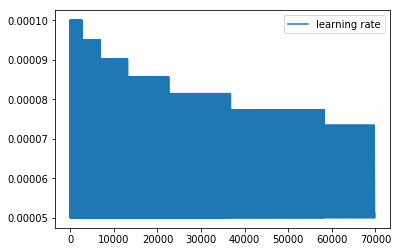


Epoch 00133: val_loss did not improve from 0.59710


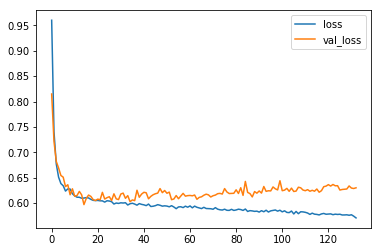

525/525 [==============================] - 183s 349ms/step - loss: 0.5708 - binary_accuracy: 0.7379 - val_loss: 0.6302 - val_binary_accuracy: 0.6997
Epoch 134/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6328 - binary_accuracy: 0.6970


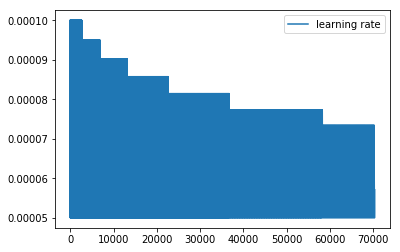


Epoch 00134: val_loss did not improve from 0.59710


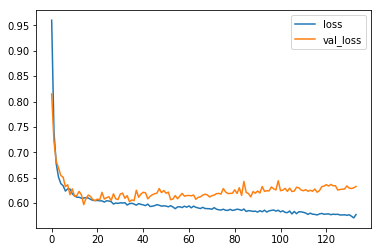

525/525 [==============================] - 182s 347ms/step - loss: 0.5774 - binary_accuracy: 0.7308 - val_loss: 0.6328 - val_binary_accuracy: 0.6970
Epoch 135/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6328 - binary_accuracy: 0.6981


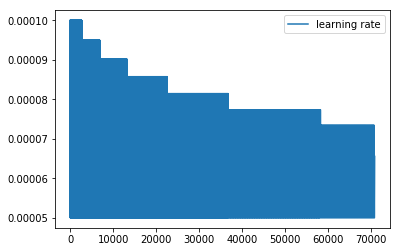


Epoch 00135: val_loss did not improve from 0.59710


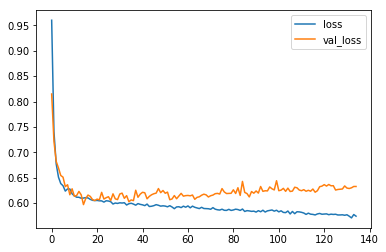

525/525 [==============================] - 177s 338ms/step - loss: 0.5743 - binary_accuracy: 0.7350 - val_loss: 0.6328 - val_binary_accuracy: 0.6981
Epoch 136/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6309 - binary_accuracy: 0.6943


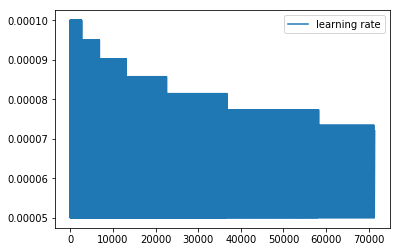


Epoch 00136: val_loss did not improve from 0.59710


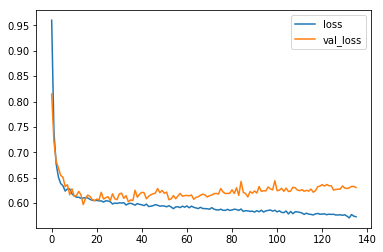

525/525 [==============================] - 177s 338ms/step - loss: 0.5733 - binary_accuracy: 0.7343 - val_loss: 0.6309 - val_binary_accuracy: 0.6943
Epoch 137/300
59/59 [==============================] - 7s 119ms/step - loss: 0.6337 - binary_accuracy: 0.6954


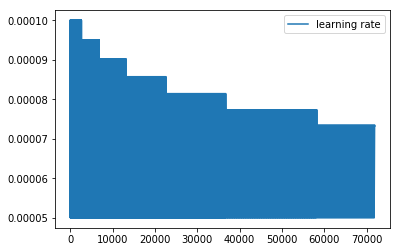


Epoch 00137: val_loss did not improve from 0.59710


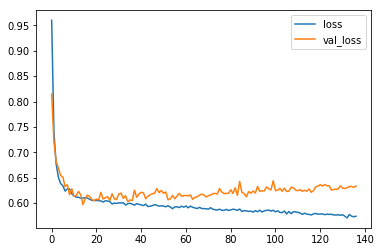

525/525 [==============================] - 177s 337ms/step - loss: 0.5741 - binary_accuracy: 0.7335 - val_loss: 0.6337 - val_binary_accuracy: 0.6954
Epoch 138/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6344 - binary_accuracy: 0.6804


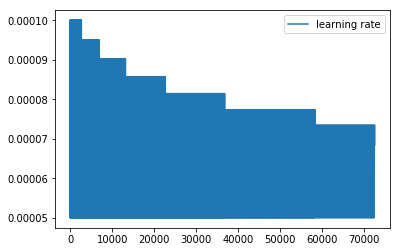


Epoch 00138: val_loss did not improve from 0.59710


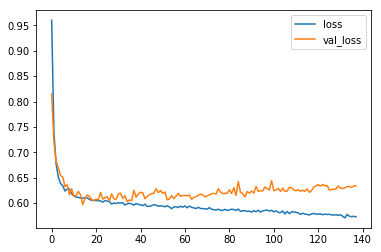

525/525 [==============================] - 177s 338ms/step - loss: 0.5725 - binary_accuracy: 0.7322 - val_loss: 0.6344 - val_binary_accuracy: 0.6804
Epoch 139/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6306 - binary_accuracy: 0.6916


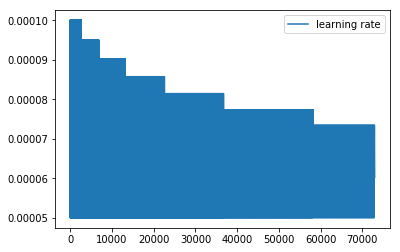


Epoch 00139: val_loss did not improve from 0.59710


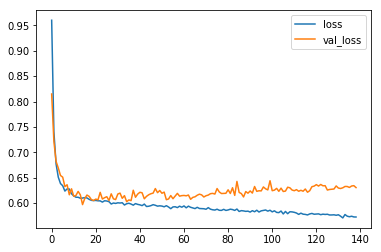

525/525 [==============================] - 177s 338ms/step - loss: 0.5729 - binary_accuracy: 0.7342 - val_loss: 0.6306 - val_binary_accuracy: 0.6916
Epoch 140/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6422 - binary_accuracy: 0.6849


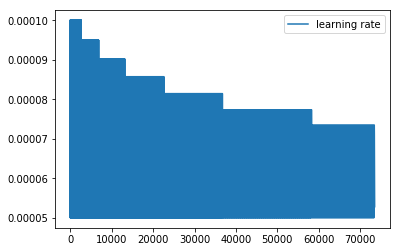


Epoch 00140: val_loss did not improve from 0.59710


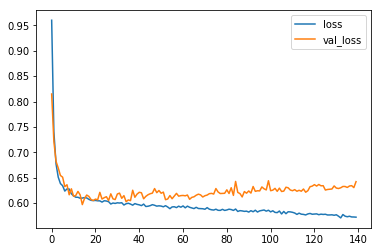

525/525 [==============================] - 178s 338ms/step - loss: 0.5727 - binary_accuracy: 0.7352 - val_loss: 0.6422 - val_binary_accuracy: 0.6849
Epoch 141/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6382 - binary_accuracy: 0.6841


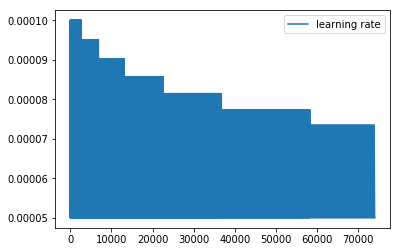


Epoch 00141: val_loss did not improve from 0.59710


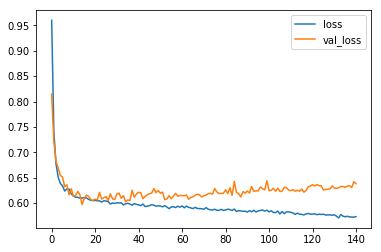

525/525 [==============================] - 178s 339ms/step - loss: 0.5733 - binary_accuracy: 0.7344 - val_loss: 0.6382 - val_binary_accuracy: 0.6841
Epoch 142/300
59/59 [==============================] - 7s 122ms/step - loss: 0.6331 - binary_accuracy: 0.6916


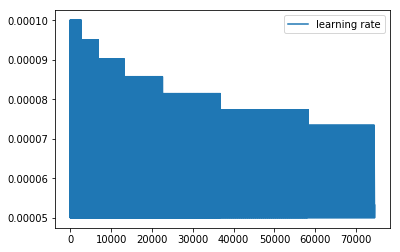


Epoch 00142: val_loss did not improve from 0.59710


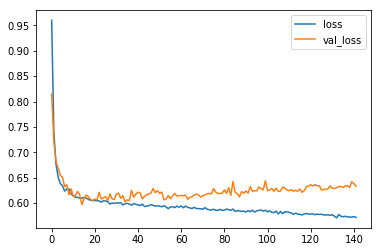

525/525 [==============================] - 177s 338ms/step - loss: 0.5721 - binary_accuracy: 0.7351 - val_loss: 0.6331 - val_binary_accuracy: 0.6916
Epoch 143/300
59/59 [==============================] - 7s 122ms/step - loss: 0.6320 - binary_accuracy: 0.7040


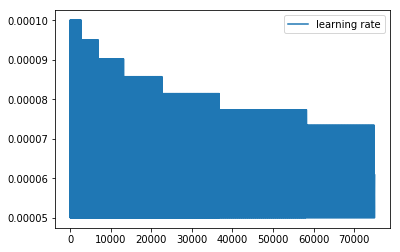


Epoch 00143: val_loss did not improve from 0.59710


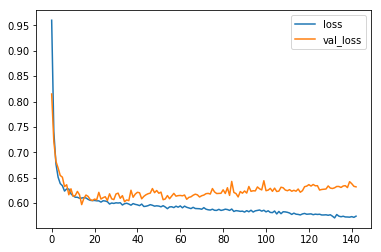

525/525 [==============================] - 177s 338ms/step - loss: 0.5750 - binary_accuracy: 0.7340 - val_loss: 0.6320 - val_binary_accuracy: 0.7040
Epoch 144/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6366 - binary_accuracy: 0.6951


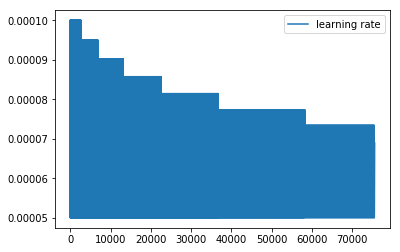


Epoch 00144: val_loss did not improve from 0.59710


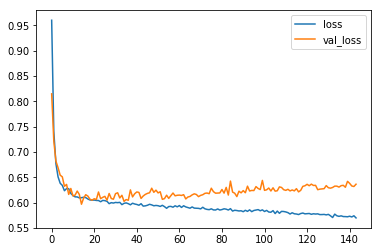

525/525 [==============================] - 177s 338ms/step - loss: 0.5702 - binary_accuracy: 0.7389 - val_loss: 0.6366 - val_binary_accuracy: 0.6951
Epoch 145/300
59/59 [==============================] - 7s 123ms/step - loss: 0.6351 - binary_accuracy: 0.7040


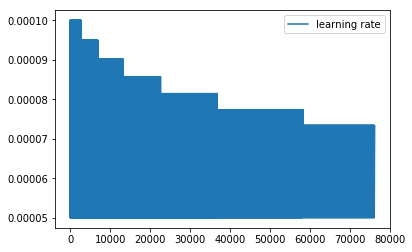


Epoch 00145: val_loss did not improve from 0.59710


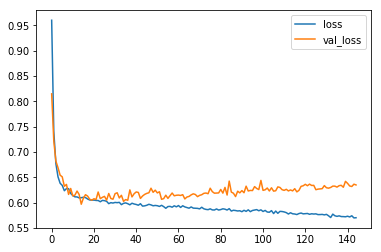

525/525 [==============================] - 177s 338ms/step - loss: 0.5703 - binary_accuracy: 0.7377 - val_loss: 0.6351 - val_binary_accuracy: 0.7040
Epoch 146/300
59/59 [==============================] - 7s 122ms/step - loss: 0.6451 - binary_accuracy: 0.6838


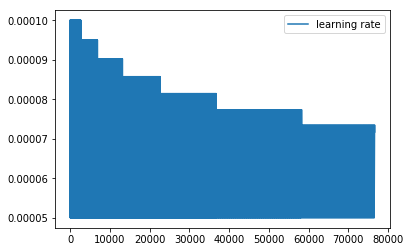


Epoch 00146: val_loss did not improve from 0.59710


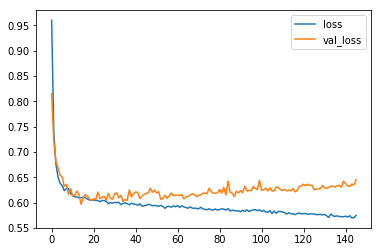

525/525 [==============================] - 178s 338ms/step - loss: 0.5754 - binary_accuracy: 0.7353 - val_loss: 0.6451 - val_binary_accuracy: 0.6838
Epoch 147/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6410 - binary_accuracy: 0.6892


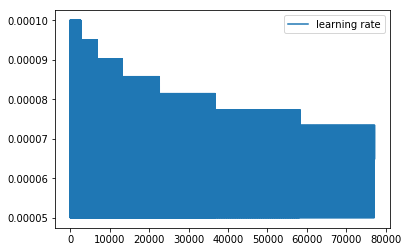


Epoch 00147: val_loss did not improve from 0.59710


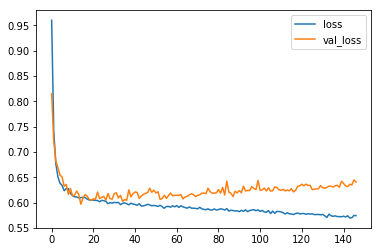

525/525 [==============================] - 178s 340ms/step - loss: 0.5746 - binary_accuracy: 0.7342 - val_loss: 0.6410 - val_binary_accuracy: 0.6892
Epoch 148/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6466 - binary_accuracy: 0.6812


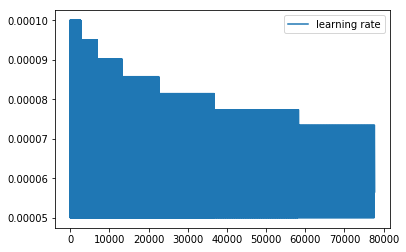


Epoch 00148: val_loss did not improve from 0.59710


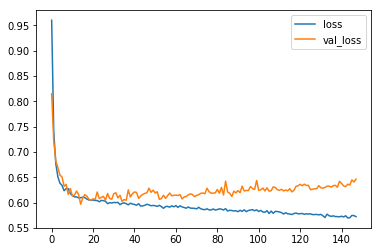

525/525 [==============================] - 177s 338ms/step - loss: 0.5724 - binary_accuracy: 0.7373 - val_loss: 0.6466 - val_binary_accuracy: 0.6812
Epoch 149/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6433 - binary_accuracy: 0.6911


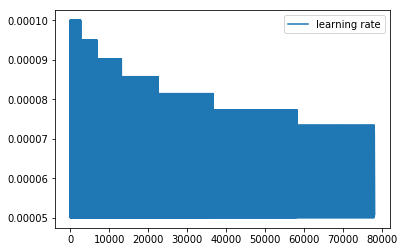


Epoch 00149: val_loss did not improve from 0.59710


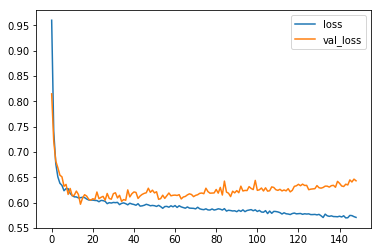

525/525 [==============================] - 177s 338ms/step - loss: 0.5711 - binary_accuracy: 0.7343 - val_loss: 0.6433 - val_binary_accuracy: 0.6911
Epoch 150/300
59/59 [==============================] - 7s 120ms/step - loss: 0.6394 - binary_accuracy: 0.6954


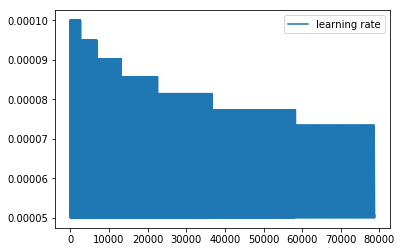


Epoch 00150: val_loss did not improve from 0.59710


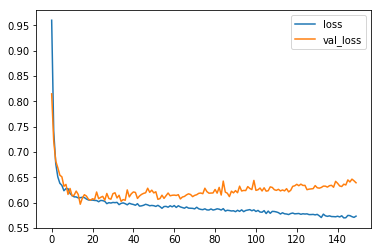

525/525 [==============================] - 177s 338ms/step - loss: 0.5736 - binary_accuracy: 0.7322 - val_loss: 0.6394 - val_binary_accuracy: 0.6954
Epoch 151/300
59/59 [==============================] - 7s 119ms/step - loss: 0.6453 - binary_accuracy: 0.6838


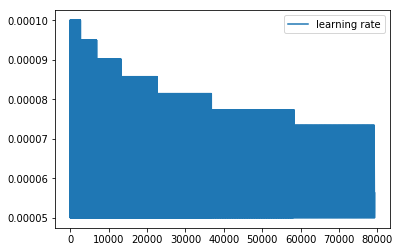


Epoch 00151: val_loss did not improve from 0.59710


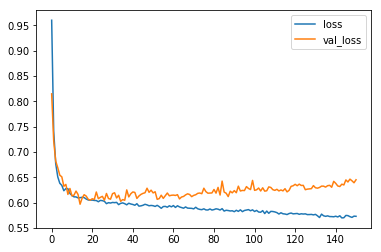

525/525 [==============================] - 177s 337ms/step - loss: 0.5736 - binary_accuracy: 0.7358 - val_loss: 0.6453 - val_binary_accuracy: 0.6838
Epoch 152/300
59/59 [==============================] - 7s 122ms/step - loss: 0.6434 - binary_accuracy: 0.6822


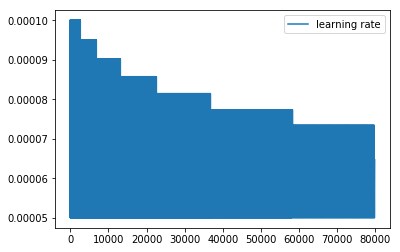


Epoch 00152: val_loss did not improve from 0.59710


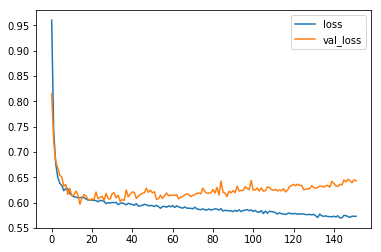

525/525 [==============================] - 178s 338ms/step - loss: 0.5734 - binary_accuracy: 0.7358 - val_loss: 0.6434 - val_binary_accuracy: 0.6822
Epoch 153/300
59/59 [==============================] - 7s 123ms/step - loss: 0.6434 - binary_accuracy: 0.6887


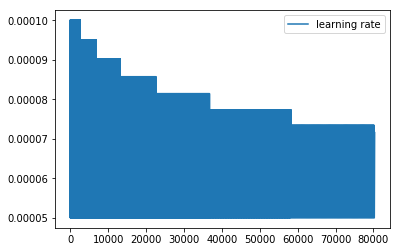


Epoch 00153: val_loss did not improve from 0.59710


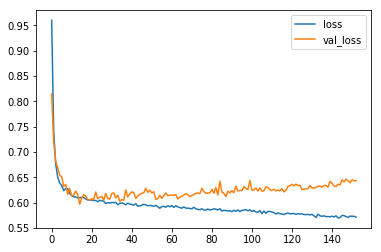

525/525 [==============================] - 178s 338ms/step - loss: 0.5716 - binary_accuracy: 0.7352 - val_loss: 0.6434 - val_binary_accuracy: 0.6887
Epoch 154/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6464 - binary_accuracy: 0.6900


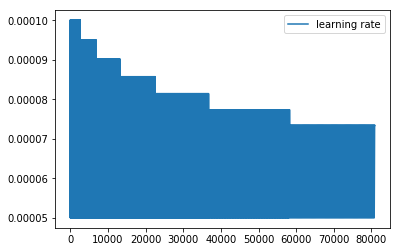


Epoch 00154: val_loss did not improve from 0.59710


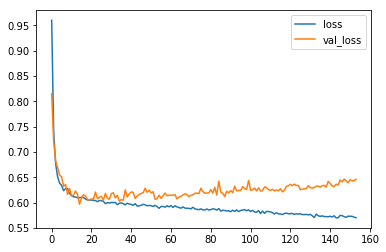

525/525 [==============================] - 178s 339ms/step - loss: 0.5705 - binary_accuracy: 0.7382 - val_loss: 0.6464 - val_binary_accuracy: 0.6900
Epoch 155/300
59/59 [==============================] - 7s 122ms/step - loss: 0.6472 - binary_accuracy: 0.6873


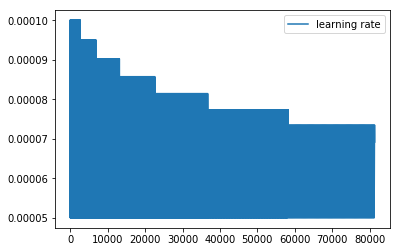


Epoch 00155: val_loss did not improve from 0.59710


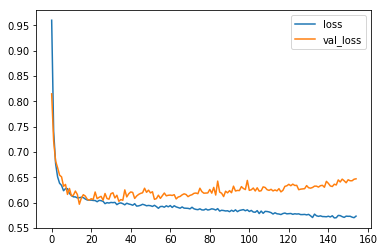

525/525 [==============================] - 177s 338ms/step - loss: 0.5737 - binary_accuracy: 0.7349 - val_loss: 0.6472 - val_binary_accuracy: 0.6873
Epoch 156/300
59/59 [==============================] - 7s 125ms/step - loss: 0.6510 - binary_accuracy: 0.6865


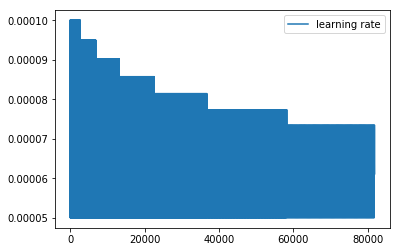


Epoch 00156: val_loss did not improve from 0.59710


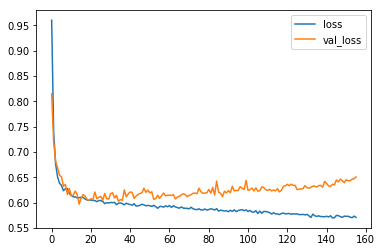

525/525 [==============================] - 180s 342ms/step - loss: 0.5712 - binary_accuracy: 0.7362 - val_loss: 0.6510 - val_binary_accuracy: 0.6865
Epoch 157/300
59/59 [==============================] - 7s 125ms/step - loss: 0.6468 - binary_accuracy: 0.6801


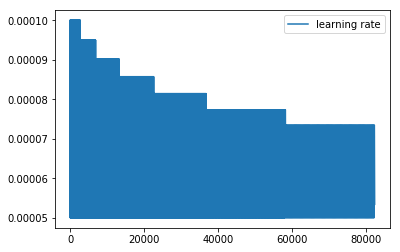


Epoch 00157: val_loss did not improve from 0.59710


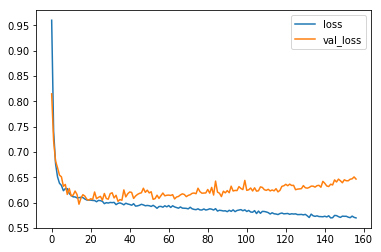

525/525 [==============================] - 183s 349ms/step - loss: 0.5702 - binary_accuracy: 0.7360 - val_loss: 0.6468 - val_binary_accuracy: 0.6801
Epoch 158/300
59/59 [==============================] - 7s 125ms/step - loss: 0.6474 - binary_accuracy: 0.6873


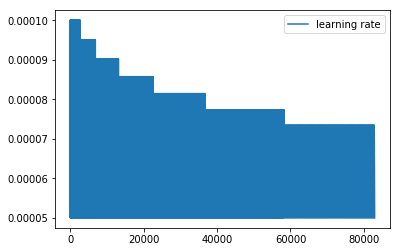


Epoch 00158: val_loss did not improve from 0.59710


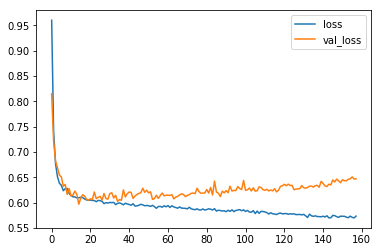

525/525 [==============================] - 183s 349ms/step - loss: 0.5735 - binary_accuracy: 0.7333 - val_loss: 0.6474 - val_binary_accuracy: 0.6873
Epoch 159/300
59/59 [==============================] - 7s 124ms/step - loss: 0.6464 - binary_accuracy: 0.6935


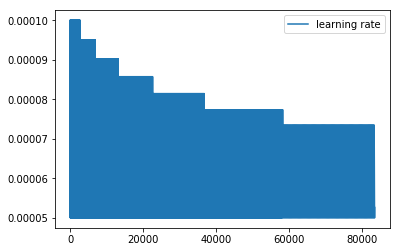


Epoch 00159: val_loss did not improve from 0.59710


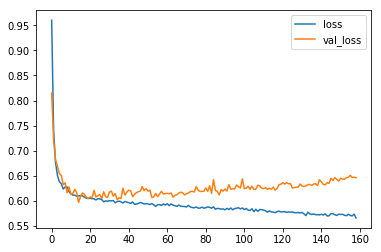

525/525 [==============================] - 184s 350ms/step - loss: 0.5659 - binary_accuracy: 0.7374 - val_loss: 0.6464 - val_binary_accuracy: 0.6935
Epoch 160/300
59/59 [==============================] - 7s 125ms/step - loss: 0.6556 - binary_accuracy: 0.6653


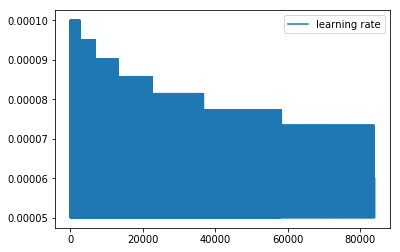


Epoch 00160: val_loss did not improve from 0.59710


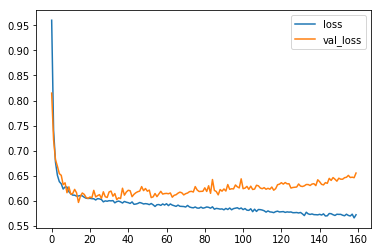

525/525 [==============================] - 185s 352ms/step - loss: 0.5728 - binary_accuracy: 0.7373 - val_loss: 0.6556 - val_binary_accuracy: 0.6653
Epoch 161/300
59/59 [==============================] - 7s 124ms/step - loss: 0.6456 - binary_accuracy: 0.6868


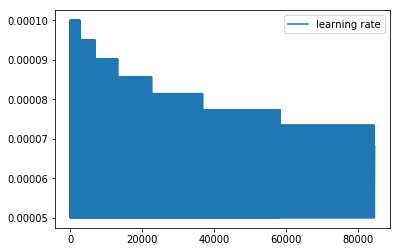


Epoch 00161: val_loss did not improve from 0.59710


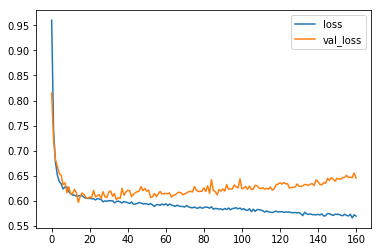

525/525 [==============================] - 185s 352ms/step - loss: 0.5702 - binary_accuracy: 0.7388 - val_loss: 0.6456 - val_binary_accuracy: 0.6868
Epoch 162/300
59/59 [==============================] - 7s 123ms/step - loss: 0.6486 - binary_accuracy: 0.6881


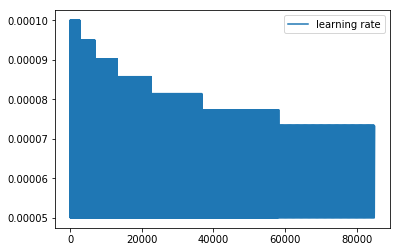


Epoch 00162: val_loss did not improve from 0.59710


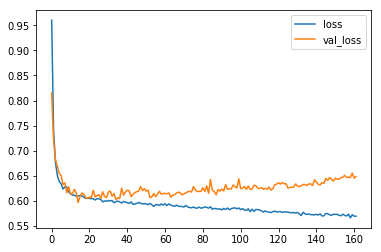

525/525 [==============================] - 183s 349ms/step - loss: 0.5695 - binary_accuracy: 0.7350 - val_loss: 0.6486 - val_binary_accuracy: 0.6881
Epoch 163/300
59/59 [==============================] - 7s 125ms/step - loss: 0.6436 - binary_accuracy: 0.6946


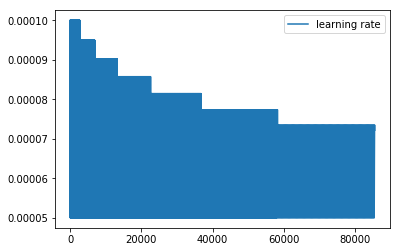


Epoch 00163: val_loss did not improve from 0.59710


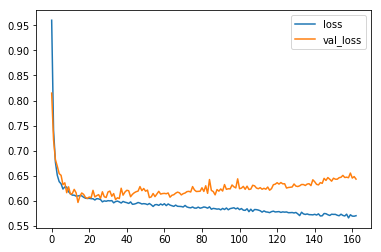

525/525 [==============================] - 184s 351ms/step - loss: 0.5707 - binary_accuracy: 0.7401 - val_loss: 0.6436 - val_binary_accuracy: 0.6946
Epoch 164/300
59/59 [==============================] - 7s 121ms/step - loss: 0.6503 - binary_accuracy: 0.6889


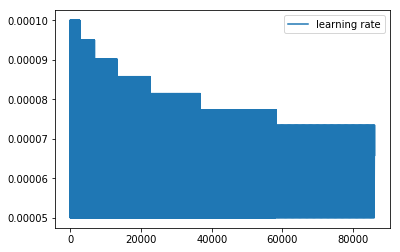


Epoch 00164: val_loss did not improve from 0.59710


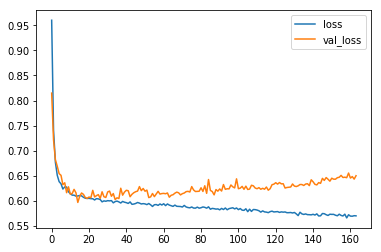

525/525 [==============================] - 184s 350ms/step - loss: 0.5705 - binary_accuracy: 0.7389 - val_loss: 0.6503 - val_binary_accuracy: 0.6889
Epoch 165/300
59/59 [==============================] - 8s 137ms/step - loss: 0.6484 - binary_accuracy: 0.6873


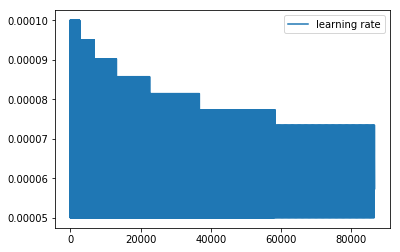


Epoch 00165: val_loss did not improve from 0.59710


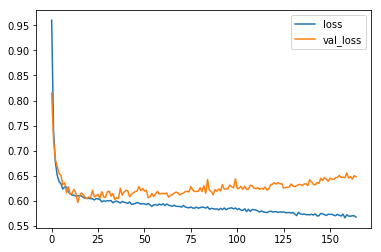

525/525 [==============================] - 188s 359ms/step - loss: 0.5680 - binary_accuracy: 0.7395 - val_loss: 0.6484 - val_binary_accuracy: 0.6873
Epoch 166/300
59/59 [==============================] - 8s 140ms/step - loss: 0.6524 - binary_accuracy: 0.6787


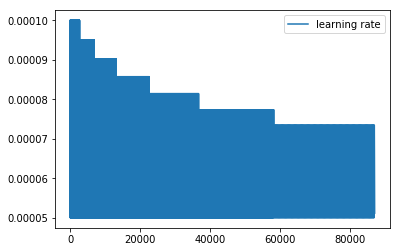


Epoch 00166: val_loss did not improve from 0.59710


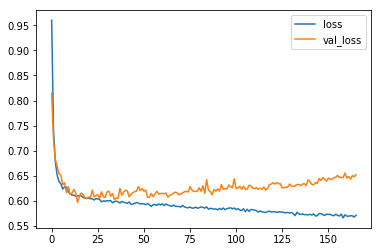

525/525 [==============================] - 187s 356ms/step - loss: 0.5713 - binary_accuracy: 0.7335 - val_loss: 0.6524 - val_binary_accuracy: 0.6787
Epoch 167/300
59/59 [==============================] - 8s 135ms/step - loss: 0.6502 - binary_accuracy: 0.6919


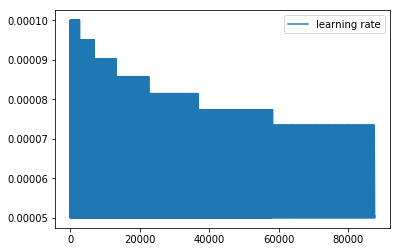


Epoch 00167: val_loss did not improve from 0.59710


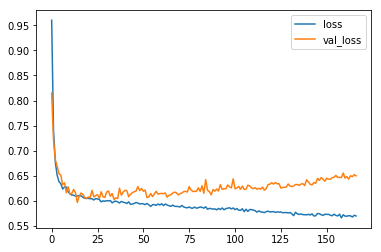

525/525 [==============================] - 187s 357ms/step - loss: 0.5702 - binary_accuracy: 0.7376 - val_loss: 0.6502 - val_binary_accuracy: 0.6919
Epoch 168/300
59/59 [==============================] - 8s 139ms/step - loss: 0.6506 - binary_accuracy: 0.6828


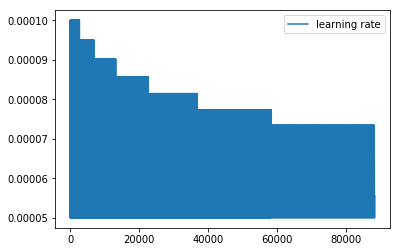


Epoch 00168: val_loss did not improve from 0.59710


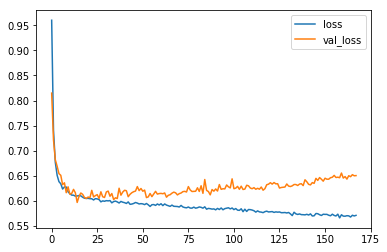

525/525 [==============================] - 187s 357ms/step - loss: 0.5713 - binary_accuracy: 0.7386 - val_loss: 0.6506 - val_binary_accuracy: 0.6828
Epoch 169/300
59/59 [==============================] - 8s 134ms/step - loss: 0.6530 - binary_accuracy: 0.6817


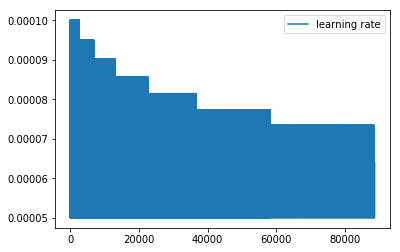


Epoch 00169: val_loss did not improve from 0.59710


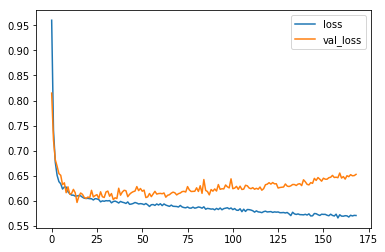

525/525 [==============================] - 187s 357ms/step - loss: 0.5711 - binary_accuracy: 0.7389 - val_loss: 0.6530 - val_binary_accuracy: 0.6817
Epoch 170/300
59/59 [==============================] - 8s 133ms/step - loss: 0.6568 - binary_accuracy: 0.6790


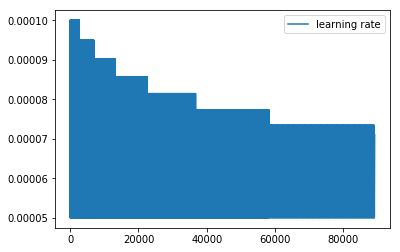


Epoch 00170: val_loss did not improve from 0.59710


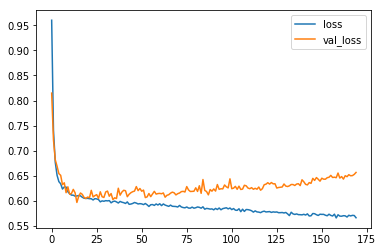

525/525 [==============================] - 187s 357ms/step - loss: 0.5666 - binary_accuracy: 0.7420 - val_loss: 0.6568 - val_binary_accuracy: 0.6790
Epoch 171/300
59/59 [==============================] - 8s 135ms/step - loss: 0.6527 - binary_accuracy: 0.6820


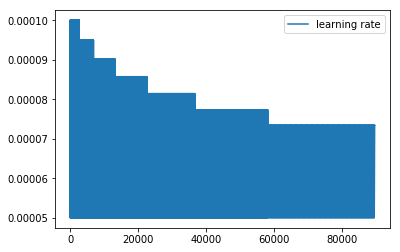


Epoch 00171: val_loss did not improve from 0.59710


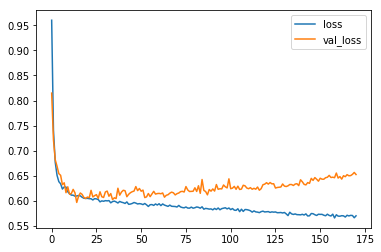

525/525 [==============================] - 187s 356ms/step - loss: 0.5707 - binary_accuracy: 0.7374 - val_loss: 0.6527 - val_binary_accuracy: 0.6820
Epoch 172/300
59/59 [==============================] - 8s 132ms/step - loss: 0.6480 - binary_accuracy: 0.6895


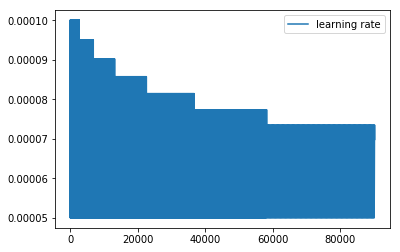


Epoch 00172: val_loss did not improve from 0.59710


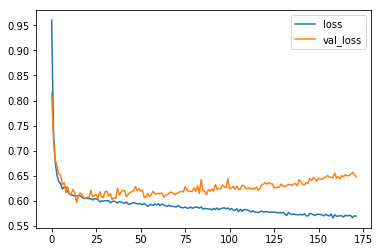

525/525 [==============================] - 186s 354ms/step - loss: 0.5698 - binary_accuracy: 0.7360 - val_loss: 0.6480 - val_binary_accuracy: 0.6895
Epoch 173/300
59/59 [==============================] - 8s 135ms/step - loss: 0.6546 - binary_accuracy: 0.6914


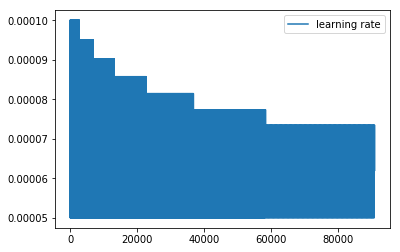


Epoch 00173: val_loss did not improve from 0.59710


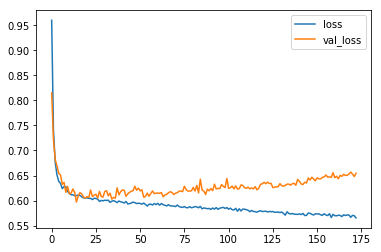

525/525 [==============================] - 187s 356ms/step - loss: 0.5656 - binary_accuracy: 0.7417 - val_loss: 0.6546 - val_binary_accuracy: 0.6914
Epoch 174/300
59/59 [==============================] - 8s 138ms/step - loss: 0.6540 - binary_accuracy: 0.6790


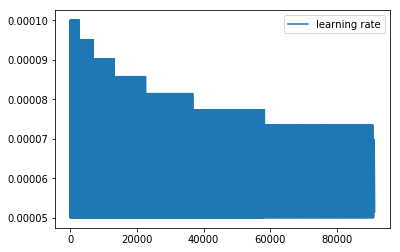


Epoch 00174: val_loss did not improve from 0.59710


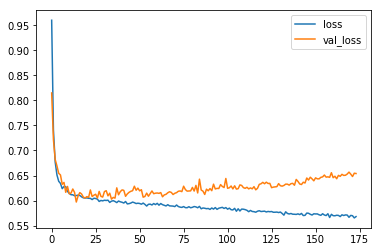

525/525 [==============================] - 190s 362ms/step - loss: 0.5680 - binary_accuracy: 0.7395 - val_loss: 0.6540 - val_binary_accuracy: 0.6790
Epoch 175/300
59/59 [==============================] - 7s 125ms/step - loss: 0.6535 - binary_accuracy: 0.6804


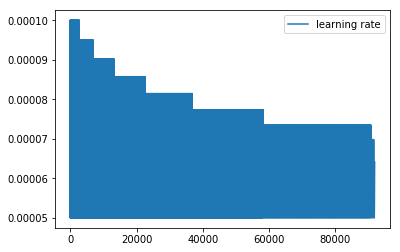


Epoch 00175: val_loss did not improve from 0.59710


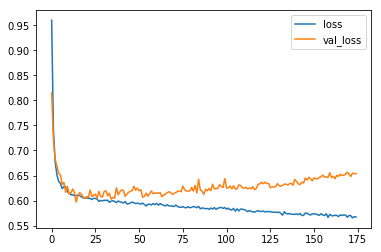

525/525 [==============================] - 185s 353ms/step - loss: 0.5668 - binary_accuracy: 0.7386 - val_loss: 0.6535 - val_binary_accuracy: 0.6804
Epoch 176/300
59/59 [==============================] - 7s 125ms/step - loss: 0.6527 - binary_accuracy: 0.6838


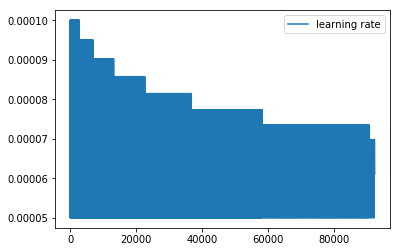


Epoch 00176: val_loss did not improve from 0.59710


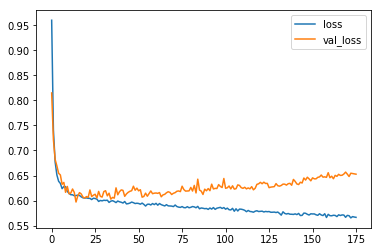

525/525 [==============================] - 184s 350ms/step - loss: 0.5663 - binary_accuracy: 0.7398 - val_loss: 0.6527 - val_binary_accuracy: 0.6838
Epoch 177/300
59/59 [==============================] - 7s 125ms/step - loss: 0.6524 - binary_accuracy: 0.6871


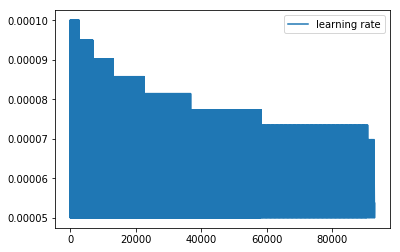


Epoch 00177: val_loss did not improve from 0.59710


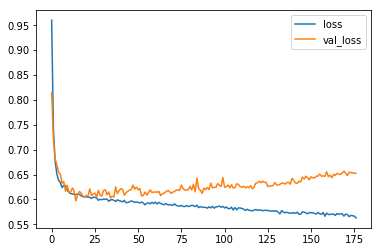

525/525 [==============================] - 184s 350ms/step - loss: 0.5627 - binary_accuracy: 0.7423 - val_loss: 0.6524 - val_binary_accuracy: 0.6871
Epoch 178/300
59/59 [==============================] - 7s 122ms/step - loss: 0.6526 - binary_accuracy: 0.6876


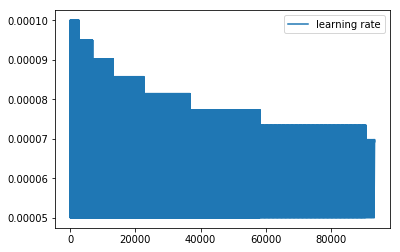


Epoch 00178: val_loss did not improve from 0.59710


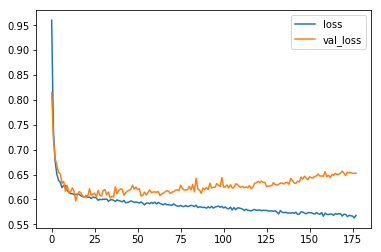

525/525 [==============================] - 185s 352ms/step - loss: 0.5681 - binary_accuracy: 0.7378 - val_loss: 0.6526 - val_binary_accuracy: 0.6876
Epoch 179/300
59/59 [==============================] - 7s 123ms/step - loss: 0.6523 - binary_accuracy: 0.6897


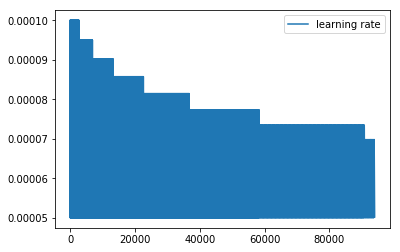


Epoch 00179: val_loss did not improve from 0.59710


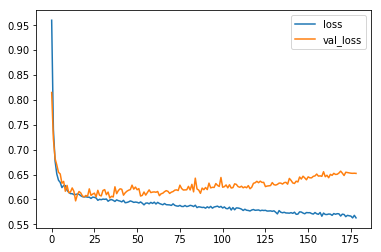

525/525 [==============================] - 185s 352ms/step - loss: 0.5629 - binary_accuracy: 0.7424 - val_loss: 0.6523 - val_binary_accuracy: 0.6897
Epoch 180/300
166/525 [========>.....................] - ETA: 1:59 - loss: 0.5598 - binary_accuracy: 0.7466

FileNotFoundError: [Errno 2] No such file or directory: '/disks/data/paper_projects/DeepCNC/data/imdata_split_90_10/train/0/11793.bmp'

In [25]:
# # Model architecture definition		
# model = Sequential()
# model.add(Convolution2D(32,( 3, 3), input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Convolution2D(64, (3, 3) ) )
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))


# model.add(Flatten())
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1))
# model.add(Activation('sigmoid'))	


# model.compile(loss='binary_crossentropy',
# 			  optimizer='rmsprop',
# 			  metrics=['accuracy'])

# nb_epoch = 5 # 30
# nb_train_samples = 200 # 2048
# nb_validation_samples = 40 # 832
	
    
    
dfROC =  pd.DataFrame(data=None, columns=['AREA_ROC'] )   
dfROC_best =  pd.DataFrame(data=None, columns=['AREA_ROC'] )   
dfROC_train =  pd.DataFrame(data=None, columns=['AREA_ROC'] )   
dfROC_best_train =  pd.DataFrame(data=None, columns=['AREA_ROC'] )   

dfPR  =  pd.DataFrame(data=None, columns=['AREA_PR' ] )
dfPR_best  =  pd.DataFrame(data=None, columns=['AREA_PR' ] )
dfPR_train  =  pd.DataFrame(data=None, columns=['AREA_PR' ] )
dfPR_best_train  =  pd.DataFrame(data=None, columns=['AREA_PR' ] )


dfCM      = pd.DataFrame(data=None, columns=['tp', 'fn' , 'fp' , 'tn'])
dfCM_best = pd.DataFrame(data=None, columns=['tp', 'fn' , 'fp' , 'tn'])
dfCM_train      = pd.DataFrame(data=None, columns=['tp', 'fn' , 'fp' , 'tn'])
dfCM_best_train = pd.DataFrame(data=None, columns=['tp', 'fn' , 'fp' , 'tn'])    

training_histories = []
last_model_performance_histories = []
best_model_performance_histories = []

last_model_performance_histories_trainset = []
best_model_performance_histories_trainset = []


k = 1

print()    
print()    
print(" --------------- Fold:", k, " ---------------")

#print("train fold size:", len(train_index ), "\nValidation fold size:", len(test_index) )

# # get the features and labels for the train set
# train_features = input_features[train_index]
# train_labels   = input_labels[train_index]

# # get the features and labels for the validation set
# test_features = input_features[test_index]
# test_labels   = input_labels[test_index] 

# # feature dimension
# inputSeqLength = len(train_features[0]);
# inputSeqLength = np.array(train_features).shape[1];

# size0 = np.array(train_features).shape[0];
# size1 = np.array(train_features).shape[1];
# print("number of samples in Training: " + str(size0) + "  seq length: " + str(size1))

# size0 = np.array(test_features).shape[0];
# size1 = np.array(test_features).shape[1];
# print("number of samples in Testing : " + str(size0) + "  seq length: " + str(size1))

# size0 = np.array(input_features).shape[0];
# size1 = np.array(input_features).shape[1];
# print("number of samples in used dataset: " + str(size0) + "  seq length: " + str(size1))

print('Building model')

model, config = make_model_2DConv(input_shape)

learning_rate = config['learning_rate']

#     decay_rate = learning_rate / hyper_epoch

adamOpt = Adam(lr = learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad = False)
model.compile(loss='binary_crossentropy', optimizer=adamOpt, metrics=['binary_accuracy']) # 'adam' , metrics=['binary_accuracy', my_pred]

# Adadelta didn't give us good result. we omitted it.
#model.compile(loss='binary_crossentropy', optimizer='Adadelta', metrics=['binary_accuracy']) # 'adam' , metrics=['binary_accuracy', my_pred]

print ( model.summary() )


print('Running at most', hyper_epoch, 'epochs')

print()
print("************************************************************ ")        
print("************** TRAINING START (fold", k, ") **************** ")
# https://machinelearningmastery.com/check-point-deep-learning-models-keras/

fileWeight_BestModel = f"{snapshot_dir}{k}_Weights_bestModel.h5"
#     monitor='val_loss', mode='min'
#     monitor='val_acc', mode='max'
#     monitor='val_fmeasure', mode='max'
checkpoint = ModelCheckpoint(fileWeight_BestModel, monitor='val_loss',mode='auto', save_best_only=True, verbose=1, save_weights_only=True )
#     val_loss,val_binary_accuracy,loss,binary_accuracy
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')

schedule = SGDRScheduler(min_lr = config['SGDRScheduler_config']['min_lr'],
                         max_lr = config['SGDRScheduler_config']['max_lr'],
                         steps_per_epoch = config['SGDRScheduler_config']['steps_per_epoch'],
                         lr_decay = config['SGDRScheduler_config']['lr_decay'],
                         cycle_length = config['SGDRScheduler_config']['cycle_length'],
                         mult_factor = config['SGDRScheduler_config']['mult_factor'])

# for plotting losses        
loss_plotter = PlotLosses()

#history = model.fit(train_features, train_labels, epochs= hyper_epoch, batch_size=hyper_batch_size, shuffle=True, verbose=1, 
#                    validation_data = (test_features, test_labels), class_weight=class_weight , callbacks=[schedule, checkpoint, loss_plotter] )    

history = model.fit_generator(
                    generator = train_generator,
                    steps_per_epoch = num_training_batches,
                    epochs = hyper_epoch,
                    validation_data=validation_generator,
                    validation_steps = num_val_batches, 
                    callbacks=[schedule, checkpoint, loss_plotter],        
                    verbose=1)


training_histories.append(history)

# using validation set fold for validation
#history = model.fit(train_features, train_labels, epochs= hyper_epoch, batch_size=hyper_batch_size, shuffle=True, verbose=1, 
#                    validation_data = (test_features, test_labels), class_weight=class_weight , callbacks=[early_stopping, checkpoint] )  


# save the last iteration's model and weights
fileModel = f'{snapshot_dir}{k}_Model.h5'
model.save(fileModel)
fileWeight = f'{snapshot_dir}{k}_Weights.h5'
model.save_weights(fileWeight)

print("************** TRAINING END (fold", k, ") **************** ")
print("********************************************************** ")        


print("************************************************************************ ")            
print("************** TESTING START (LAST MODEL) (fold", k, ") **************** ")

last_model_weight_file = f'{snapshot_dir}{k}_Weights.h5'
print(last_model_weight_file)
model.load_weights(last_model_weight_file, by_name=False)

test_summary = perform_test(model, test_features, test_labels, dfCM, dfROC, dfPR )
last_model_performance_histories.append(test_summary)    

print("************** TESTING END (LAST MODEL) (fold", k, ") **************** ")
print("************************************************************************ ")            


print("************************************************************************ ")            
print("************** TESTING START (BEST MODEL) (fold", k, ") **************** ")
best_model_weight_file = f"{snapshot_dir}{k}_Weights_bestModel.h5"
print(fileWeight_BestModel)
model.load_weights(best_model_weight_file, by_name=False)

test_summary = perform_test(model, test_features, test_labels, dfCM_best, dfROC_best, dfPR_best )
best_model_performance_histories.append(test_summary)    

print("************** TESTING END  (BEST MODEL) (fold", k, ") **************** ")
print("************************************************************************ ")   


print("************************************************************************ ")            
print("************** TESTING START ON TRAINING SET (LAST MODEL) (fold", k, ") **************** ")
last_model_weight_file = f'{snapshot_dir}{k}_Weights.h5'
print(last_model_weight_file)
model.load_weights(last_model_weight_file, by_name=False)

test_summary = perform_test(model, train_features, train_labels, dfCM_train, dfROC_train, dfPR_train )
last_model_performance_histories_trainset.append(test_summary) 

print("************** TESTING END ON TRAINING SET (LAST MODEL) (fold", k, ") **************** ")
print("************************************************************************ ")

print("************************************************************************ ")            
print("************** TESTING START ON TRAINING SET (BEST MODEL) (fold", k, ") **************** ")
best_model_weight_file = f"{snapshot_dir}{k}_Weights_bestModel.h5"
print(fileWeight_BestModel)
model.load_weights(best_model_weight_file, by_name=False)

test_summary = perform_test(model, train_features, train_labels, dfCM_best_train, dfROC_best_train, dfPR_best_train )
best_model_performance_histories_trainset.append(test_summary)

print("************** TESTING END ON TRAINING SET (BEST MODEL) (fold", k, ") **************** ")
print("************************************************************************ ") 



 
    



In [ ]:
# ########################### Stratified k-fold Cross validation ###############

# # train_features, test_features, train_labels, test_labels = train_test_split(input_features, input_labels,
# #                                                                                 test_size=hyper_test_split,
# #                                                                                 stratify=input_labels,
# #                                                                                 random_state=42)

# dfROC =  pd.DataFrame(data=None, columns=['AREA_ROC'] )   
# dfROC_best =  pd.DataFrame(data=None, columns=['AREA_ROC'] )   
# dfROC_train =  pd.DataFrame(data=None, columns=['AREA_ROC'] )   
# dfROC_best_train =  pd.DataFrame(data=None, columns=['AREA_ROC'] )   

# dfPR  =  pd.DataFrame(data=None, columns=['AREA_PR' ] )
# dfPR_best  =  pd.DataFrame(data=None, columns=['AREA_PR' ] )
# dfPR_train  =  pd.DataFrame(data=None, columns=['AREA_PR' ] )
# dfPR_best_train  =  pd.DataFrame(data=None, columns=['AREA_PR' ] )


# dfCM      = pd.DataFrame(data=None, columns=['tp', 'fn' , 'fp' , 'tn'])
# dfCM_best = pd.DataFrame(data=None, columns=['tp', 'fn' , 'fp' , 'tn'])
# dfCM_train      = pd.DataFrame(data=None, columns=['tp', 'fn' , 'fp' , 'tn'])
# dfCM_best_train = pd.DataFrame(data=None, columns=['tp', 'fn' , 'fp' , 'tn'])    

# training_histories = []
# last_model_performance_histories = []
# best_model_performance_histories = []

# last_model_performance_histories_trainset = []
# best_model_performance_histories_trainset = []


# # skf = StratifiedKFold( n_splits= k_folds , random_state = 23, shuffle=True)
# # print(skf)  
# # k=0


# for train_index, test_index in skf.split(sequences, labels):
#     # fold K
#     k=k+1;
    
#     print()    
#     print()    
#     print(" --------------- Fold:", k, " ---------------")
#     print("train fold size:", len(train_index ), "\nValidation fold size:", len(test_index) )

#     # get the features and labels for the train set
#     train_features = input_features[train_index]
#     train_labels   = input_labels[train_index]
    
#     # get the features and labels for the validation set
#     test_features = input_features[test_index]
#     test_labels   = input_labels[test_index] 

#     # feature dimension
#     inputSeqLength = len(train_features[0]);
#     inputSeqLength = np.array(train_features).shape[1];
    
#     size0 = np.array(train_features).shape[0];
#     size1 = np.array(train_features).shape[1];
#     print("number of samples in Training: " + str(size0) + "  seq length: " + str(size1))

#     size0 = np.array(test_features).shape[0];
#     size1 = np.array(test_features).shape[1];
#     print("number of samples in Testing : " + str(size0) + "  seq length: " + str(size1))

#     size0 = np.array(input_features).shape[0];
#     size1 = np.array(input_features).shape[1];
#     print("number of samples in used dataset: " + str(size0) + "  seq length: " + str(size1))
        
#     print('Building model')

#     model, config = make_model_1DConv()

#     learning_rate = config['learning_rate']

# #     decay_rate = learning_rate / hyper_epoch

#     adamOpt = Adam(lr = learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad = False)
#     model.compile(loss='binary_crossentropy', optimizer=adamOpt, metrics=['binary_accuracy']) # 'adam' , metrics=['binary_accuracy', my_pred]
    
#     # Adadelta didn't give us good result. we omitted it.
#     #model.compile(loss='binary_crossentropy', optimizer='Adadelta', metrics=['binary_accuracy']) # 'adam' , metrics=['binary_accuracy', my_pred]
    
#     print ( model.summary() )
    
    
#     print('Running at most', hyper_epoch, 'epochs')

#     print()
#     print("************************************************************ ")        
#     print("************** TRAINING START (fold", k, ") **************** ")
#     # https://machinelearningmastery.com/check-point-deep-learning-models-keras/
    
#     fileWeight_BestModel = f"{snapshot_dir}{k}_Weights_bestModel.h5"
#     #     monitor='val_loss', mode='min'
#     #     monitor='val_acc', mode='max'
#     #     monitor='val_fmeasure', mode='max'
#     checkpoint = ModelCheckpoint(fileWeight_BestModel, monitor='val_loss',mode='auto', save_best_only=True, verbose=1, save_weights_only=True )
#     #     val_loss,val_binary_accuracy,loss,binary_accuracy
#     early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')

#     schedule = SGDRScheduler(min_lr = config['SGDRScheduler_config']['min_lr'],
#                              max_lr = config['SGDRScheduler_config']['max_lr'],
#                              steps_per_epoch = config['SGDRScheduler_config']['steps_per_epoch'],
#                              lr_decay = config['SGDRScheduler_config']['lr_decay'],
#                              cycle_length = config['SGDRScheduler_config']['cycle_length'],
#                              mult_factor = config['SGDRScheduler_config']['mult_factor'])
    
#     # for plotting losses        
#     loss_plotter = PlotLosses()
    
#     history = model.fit(train_features, train_labels, epochs= hyper_epoch, batch_size=hyper_batch_size, shuffle=True, verbose=1, 
#                         validation_data = (test_features, test_labels), class_weight=class_weight , callbacks=[schedule, checkpoint, loss_plotter] )    
    
#     training_histories.append(history)

#     # using validation set fold for validation
#     #history = model.fit(train_features, train_labels, epochs= hyper_epoch, batch_size=hyper_batch_size, shuffle=True, verbose=1, 
#     #                    validation_data = (test_features, test_labels), class_weight=class_weight , callbacks=[early_stopping, checkpoint] )  
    
    
#     # save the last iteration's model and weights
#     fileModel = f'{snapshot_dir}{k}_Model.h5'
#     model.save(fileModel)
#     fileWeight = f'{snapshot_dir}{k}_Weights.h5'
#     model.save_weights(fileWeight)

#     print("************** TRAINING END (fold", k, ") **************** ")
#     print("********************************************************** ")        

    
#     print("************************************************************************ ")            
#     print("************** TESTING START (LAST MODEL) (fold", k, ") **************** ")
    
#     last_model_weight_file = f'{snapshot_dir}{k}_Weights.h5'
#     print(last_model_weight_file)
#     model.load_weights(last_model_weight_file, by_name=False)

#     test_summary = perform_test(model, test_features, test_labels, dfCM, dfROC, dfPR )
#     last_model_performance_histories.append(test_summary)    
        
#     print("************** TESTING END (LAST MODEL) (fold", k, ") **************** ")
#     print("************************************************************************ ")            
    
    
#     print("************************************************************************ ")            
#     print("************** TESTING START (BEST MODEL) (fold", k, ") **************** ")
#     best_model_weight_file = f"{snapshot_dir}{k}_Weights_bestModel.h5"
#     print(fileWeight_BestModel)
#     model.load_weights(best_model_weight_file, by_name=False)

#     test_summary = perform_test(model, test_features, test_labels, dfCM_best, dfROC_best, dfPR_best )
#     best_model_performance_histories.append(test_summary)    
    
#     print("************** TESTING END  (BEST MODEL) (fold", k, ") **************** ")
#     print("************************************************************************ ")   

    
#     print("************************************************************************ ")            
#     print("************** TESTING START ON TRAINING SET (LAST MODEL) (fold", k, ") **************** ")
#     last_model_weight_file = f'{snapshot_dir}{k}_Weights.h5'
#     print(last_model_weight_file)
#     model.load_weights(last_model_weight_file, by_name=False)

#     test_summary = perform_test(model, train_features, train_labels, dfCM_train, dfROC_train, dfPR_train )
#     last_model_performance_histories_trainset.append(test_summary) 
    
#     print("************** TESTING END ON TRAINING SET (LAST MODEL) (fold", k, ") **************** ")
#     print("************************************************************************ ")
    
#     print("************************************************************************ ")            
#     print("************** TESTING START ON TRAINING SET (BEST MODEL) (fold", k, ") **************** ")
#     best_model_weight_file = f"{snapshot_dir}{k}_Weights_bestModel.h5"
#     print(fileWeight_BestModel)
#     model.load_weights(best_model_weight_file, by_name=False)

#     test_summary = perform_test(model, train_features, train_labels, dfCM_best_train, dfROC_best_train, dfPR_best_train )
#     best_model_performance_histories_trainset.append(test_summary)
    
#     print("************** TESTING END ON TRAINING SET (BEST MODEL) (fold", k, ") **************** ")
#     print("************************************************************************ ")    
    
# ##########################  Split End ###############################

In [ ]:
def test_metrics():
    print("************************************************************************ ")            
    print("************** TESTING START (LAST MODEL) (fold", k, ") **************** ")
    
    last_model_weight_file = f'{ds_dir}{k}_Weights.h5'
    print(last_model_weight_file)
    model.load_weights(last_model_weight_file, by_name=False)

    test_summary = perform_test(model, test_features, test_labels, dfCM, dfROC, dfPR )
    last_model_performance_histories.append(test_summary)    
        
    print("************** TESTING END (LAST MODEL) (fold", k, ") **************** ")
    print("************************************************************************ ")            
    
    
    print("************************************************************************ ")            
    print("************** TESTING START (BEST MODEL) (fold", k, ") **************** ")
    best_model_weight_file = f"{ds_dir}{k}_Weights_bestModel.h5"
    print(fileWeight_BestModel)
    model.load_weights(best_model_weight_file, by_name=False)

    test_summary = perform_test(model, test_features, test_labels, dfCM_best, dfROC_best, dfPR_best )
    best_model_performance_histories.append(test_summary)    
    
    print("************** TESTING END  (BEST MODEL) (fold", k, ") **************** ")
    print("************************************************************************ ")   

    
    print("************************************************************************ ")            
    print("************** TESTING START ON TRAINING SET (LAST MODEL) (fold", k, ") **************** ")
    last_model_weight_file = f'{ds_dir}{k}_Weights.h5'
    print(last_model_weight_file)
    model.load_weights(last_model_weight_file, by_name=False)

    test_summary = perform_test(model, train_features, train_labels, dfCM_train, dfROC_train, dfPR_train )
    last_model_performance_histories_trainset.append(test_summary) 
    
    print("************** TESTING END ON TRAINING SET (LAST MODEL) (fold", k, ") **************** ")
    print("************************************************************************ ")
    
    print("************************************************************************ ")            
    print("************** TESTING START ON TRAINING SET (BEST MODEL) (fold", k, ") **************** ")
    best_model_weight_file = f"{ds_dir}{k}_Weights_bestModel.h5"
    print(fileWeight_BestModel)
    model.load_weights(best_model_weight_file, by_name=False)

    test_summary = perform_test(model, train_features, train_labels, dfCM_best_train, dfROC_best_train, dfPR_best_train )
    best_model_performance_histories_trainset.append(test_summary)
    
    print("************** TESTING END ON TRAINING SET (BEST MODEL) (fold", k, ") **************** ")
    print("************************************************************************ ") 

In [ ]:
def plot_training_histories():
    
    for history in training_histories:
        # Plot training & validation accuracy values
#         plt.plot(history.history['binary_accuracy'])
#         plt.plot(history.history['val_binary_accuracy'])
#         plt.title('Model accuracy')
#         plt.ylabel('Accuracy')
#         plt.xlabel('Epoch')
#         plt.legend(['Train', 'Test'], loc='upper left')
#         plt.show()

        # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()    
        
#plot_training_histories()       

In [ ]:
#
# load a model from file and evaluate its performance
#
#

# dfROC_best_val =  pd.DataFrame(data=None, columns=['AREA_ROC'] )   

# dfPR_best_val  =  pd.DataFrame(data=None, columns=['AREA_PR' ] )

# dfCM_best_val = pd.DataFrame(data=None, columns=['tp', 'fn' , 'fp' , 'tn'])    

# for k in range(1,11):
#     best_model_weight_file = f"{ds_dir}{k}_Weights_bestModel.h5"
#     print("************************* ",k, " **************************")
#     print(fileWeight_BestModel)
#     model.load_weights(best_model_weight_file, by_name=False)

#     perform_test(model, test_features, test_labels, dfCM_best_val, dfROC_best_val, dfPR_best_val )
#     print()
#     print()
    

In [ ]:
# generate loss plots for all the folds along with the corresponding performance metrics
# and write the result to a PDF file

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

with PdfPages('test.pdf') as pdf:
    t = np.arange(0.0, 2.0, 0.01)
    s = 1 + np.sin(2*np.pi*t)
    s = s * 50

    fig = plt.figure(figsize=(12,12))
    n=0
    
    for history in training_histories:
        n += 1
        ax = fig.add_subplot(4,3,n)

        # Plot training & validation loss values
        ax.plot(history.history['loss'])
        ax.plot(history.history['val_loss'])
        ax.yaxis.set_label_text('Loss')
        ax.xaxis.set_label_text('Epoch')
        ax.legend(['Train', 'Test'], loc='upper right')            

    pdf.savefig(fig)

In [ ]:
print('*********** AREA ROC for BEST model *************')

for index, row in dfROC_best.iterrows():
        print(  row['AREA_ROC']  )
        
print( dfROC_best.mean(axis = 0, skipna = True)  )

print('*********** AREA ROC for BEST model END *************')


print('*********** AREA PR for BEST model *************')

for index, row in dfPR_best.iterrows():
        print(  row['AREA_PR']  )
        
print( dfPR_best.mean(axis = 0, skipna = True)  )

print('*********** AREA PR for BEST model END *************')

In [ ]:
print('*********** CV  for last iteration model *************')

for index, row in dfCM.iterrows():
        print(  row['tp'], row['fn'] ,  row['fp'], row['tn']  )

print( dfCM.sum(axis = 0, skipna = True)  )

dfTotal=dfCM.sum(axis = 0, skipna = True) 
total_tp = dfTotal['tp'];
total_fn = dfTotal['fn'];
total_fp = dfTotal['fp'];
total_tn = dfTotal['tn'];
total_all = total_tp + total_fn + total_fp + total_tn;
accuracy1=(total_tp+total_tn)/total_all
sensitivity1 = total_tp/(total_tp+total_fn)
specificity1 = total_tn/(total_fp+total_tn)
if (total_tp)==0:
    precision1 = 0
else:
    precision1 = total_tp / (total_tp + total_fp)

MCC = (total_tp*total_tn - total_fp*total_fn) / np.sqrt(  (total_tp+total_fp)*(total_tp+total_fn)*(total_tn+total_fp)*(total_tn+total_fn)  ) 

print("TOTAL RECORDS IN ALL FOLD OF CV " , total_all)
print(  "Precision : " + str(precision1) + " Sensitivity/Recall: " + str (sensitivity1) + " Specificity: " + str(specificity1 )  + " Accuracy: " + str(accuracy1 ) + " MCC: " + str(MCC ))



print('*********** CV  for best model *************')
for index, row in dfCM_best.iterrows():
        print(  row['tp'], row['fn'] ,  row['fp'], row['tn']  )
        
        
print( dfCM_best.sum(axis = 0, skipna = True)  )

dfTotal=dfCM_best.sum(axis = 0, skipna = True) 
total_tp = dfTotal['tp'];
total_fn = dfTotal['fn'];
total_fp = dfTotal['fp'];
total_tn = dfTotal['tn'];
total_all = total_tp + total_fn + total_fp + total_tn;
accuracy1=(total_tp+total_tn)/total_all
sensitivity1 = total_tp/(total_tp+total_fn)
specificity1 = total_tn/(total_fp+total_tn)
if (total_tp)==0:
    precision1 = 0
else:
    precision1 = total_tp / (total_tp + total_fp)

MCC = (total_tp*total_tn - total_fp*total_fn) / np.sqrt(  (total_tp+total_fp)*(total_tp+total_fn)*(total_tn+total_fp)*(total_tn+total_fn)  ) 

print("TOTAL RECORDS IN ALL FOLD OF CV " , total_all)
print(  "Precision : " + str(precision1) + " Sensitivity/Recall: " + str (sensitivity1) + " Specificity: " + str(specificity1 )  + " Accuracy: " + str(accuracy1 ) + " MCC: " + str(MCC ))


In [ ]:
##########################  PR curve Drawing ###############################

test_label_rep = test_labels
pred_data = predicted_labels
cm1 = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(predicted_labels, axis=1))


print("********* Precision-Recall Curve *********")

average_precision = average_precision_score(np.argmax(test_labels, axis=1), np.argmax(predicted_labels, axis=1))
print('Average Precision (AUPR)' , average_precision)
precision, recall, _ = precision_recall_curve(np.argmax(test_labels, axis=1), np.argmax(predicted_labels, axis=1))


plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

##########################  PR curve Drawing END ###############################

In [ ]:

##########################  ROC curve Drawing START ###############################
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html



print("********* Receiver Operating Curve *********")
print ('AUC: '+str(roc_auc_score( np.argmax(test_labels, axis=1), np.argmax(predicted_labels, axis=1) ) ) )

fpr, tpr, thresholds = roc_curve(  np.argmax(test_labels, axis=1), np.argmax(predicted_labels, axis=1)  )
roc_auc = auc(fpr, tpr)

lw=2;
plt.plot(fpr, tpr, lw=lw, alpha=0.3, label='ROC'  )
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


##########################  ROCcurve Drawing END ###############################

In [ ]:
########################## Cross-validated ROC curve Drawing START ###############################
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py


print(cm)
print(history)

import json
# Get the dictionary containing each metric and the loss for each epoch
#history_dict = history
#print(history_dict['loss'][49])

########################## Cross-validated ROC curve Drawing END ###############################

In [ ]:
def make_model_1DConv():

    # -------------------------------------------------------------------------------------------------------------------------------------
    # ------------------------------------------ sequential definition --------------------------------------------------------------------
    # -------------------------------------------------------------------------------------------------------------------------------------

    def make_seq_cnn_6():
        # regularization: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

        model = Sequential()

        #model.add(Conv1D(filters=32, kernel_size=8 ,input_shape=( inputSeqLength, totalNuclType ))  )
        model.add(Conv1D(filters=32, kernel_size=7 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.4)) # input = 129 * 32
        model.add(MaxPooling1D(pool_size= 2 ))#totalNuclType)) # input = 129 * 32 , output= 32*32 (filter/pool_size* filterTotal)

        #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
        model.add(Conv1D(filters=32, kernel_size=7, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
        model.add(MaxPooling1D(pool_size=2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32

        #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
        model.add(Conv1D(filters=64, kernel_size=5, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
        model.add(MaxPooling1D(pool_size = 2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32    

        #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
        model.add(Conv1D(filters=64, kernel_size = 5, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
        model.add(MaxPooling1D(pool_size = 2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32    

        #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
        model.add(Conv1D(filters=92, kernel_size=3, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
        model.add(MaxPooling1D(pool_size = 2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32    

        #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
        model.add(Conv1D(filters=92, kernel_size=2, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
        model.add(MaxPooling1D(pool_size = 2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32    



        #model.add(Bidirectional(LSTM(16, return_sequences=True)))
        #model.add(Bidirectional(LSTM(16, return_sequences=True, kernel_regularizer=l2(1e-6), recurrent_regularizer=l2(1e-6), bias_regularizer=l2(1e-6)) ))
        #model.add(Dropout(rate = 0.4))    

        model.add(Flatten())

        #model.add(Dense(16))
        #  cite: use weight decay increasing from 0 to 1E-5 at 1200 epochs, to 1E-4 at 2500 epochs, and to 1E-3 at 400 epochs. 
        # […] The surface is smoother and transitions are more gradual
        model.add(Dense(16, kernel_regularizer=l2(0.01) ) )
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.5)) 
        model.add(Dense(2, kernel_regularizer=l2(0.01)))        
        model.add(Activation('softmax'))
        
        SGDRScheduler_config = { 'min_lr':2e-4,
                                 'max_lr':2e-3,
                                 'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
                                 'lr_decay':0.95,
                                 'cycle_length': 5,
                                 'mult_factor': 1.5}
        
        config = {'learning_rate':0.002, 'SGDRScheduler_config': SGDRScheduler_config}
        
        return [model, config]

    # -------------------------------------------------------------------------------------------------------------------------------------
    # ------------------------------------------ sequential definition --------------------------------------------------------------------
    # -------------------------------------------------------------------------------------------------------------------------------------

    def make_seq_cnn_3mer():
        # regularization: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

        model = Sequential()

        #model.add(Conv1D(filters=32, kernel_size=8 ,input_shape=( inputSeqLength, totalNuclType ))  )
        model.add(Conv1D(filters = 92, kernel_size=21, input_shape=( inputSeqLength, totalNuclType ))  )    
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.6)) # input = 129 * 32
        #model.add(MaxPooling1D(pool_size= 2 ))#totalNuclType)) # input = 129 * 32 , output= 32*32 (filter/pool_size* filterTotal)

        
        model.add(Conv1D(filters = 128, kernel_size=11, input_shape=( inputSeqLength, totalNuclType ))  )    
        model.add(Dropout(rate = 0.6)) # input = 129 * 32
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        #model.add(Bidirectional(LSTM(16, return_sequences=True)))
        #model.add(Bidirectional(LSTM(16, return_sequences=True, kernel_regularizer=l2(1e-6), recurrent_regularizer=l2(1e-6), bias_regularizer=l2(1e-6)) ))
        #model.add(Dropout(rate = 0.4))    

        model.add(Flatten())

        #model.add(Dense(16))
        #  cite: use weight decay increasing from 0 to 1E-5 at 1200 epochs, to 1E-4 at 2500 epochs, and to 1E-3 at 400 epochs. 
        # […] The surface is smoother and transitions are more gradual
        #model.add(Dense(16, kernel_regularizer=l2(0.01) ) )
        model.add(Dense(32, kernel_regularizer=l2(0.02)) )
        #model.add(BatchNormalization())    
        model.add(Activation('relu'))
        #model.add(Dropout(rate = 0.3)) 
        #model.add(Dense(2, kernel_regularizer=l2(0.01)))        
        model.add(Dense(2, kernel_regularizer=l2(0.01)))        
        model.add(Activation('softmax'))
        
        SGDRScheduler_config = { 'min_lr':.5e-4,
                                 'max_lr':1e-4,
                                 'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
                                 'lr_decay':0.95,
                                 'cycle_length': 5,
                                 'mult_factor': 1.5}
        
        config = {'learning_rate':0.002, 'SGDRScheduler_config': SGDRScheduler_config}
        
        return [model, config]  
  
  
        -------------------------------------------------------------------------------------------------------------------------------------
    # ------------------------------------------ sequential definition --------------------------------------------------------------------
    # -------------------------------------------------------------------------------------------------------------------------------------

    def make_seq_cnn_3():
        # regularization: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

        model = Sequential()

        #model.add(Conv1D(filters=32, kernel_size=8 ,input_shape=( inputSeqLength, totalNuclType ))  )
        model.add(Conv1D(filters=32, kernel_size=12 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.4)) # input = 129 * 32
        model.add(MaxPooling1D(pool_size= 2 ))#totalNuclType)) # input = 129 * 32 , output= 32*32 (filter/pool_size* filterTotal)

        #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
        model.add(Conv1D(filters=32, kernel_size=12, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.5)) # (32-8)/1  + 1 = 25 , output = 25 *32
        model.add(MaxPooling1D(pool_size=2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32

        #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
        model.add(Conv1D(filters=32, kernel_size=12, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.5)) # (32-8)/1  + 1 = 25 , output = 25 *32
        model.add(MaxPooling1D(pool_size = 2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32    



        #model.add(Bidirectional(LSTM(16, return_sequences=True)))
        #model.add(Bidirectional(LSTM(16, return_sequences=True, kernel_regularizer=l2(1e-6), recurrent_regularizer=l2(1e-6), bias_regularizer=l2(1e-6)) ))
        #model.add(Dropout(rate = 0.4))    

        model.add(Flatten())

        #model.add(Dense(16))
        #  cite: use weight decay increasing from 0 to 1E-5 at 1200 epochs, to 1E-4 at 2500 epochs, and to 1E-3 at 400 epochs. 
        # […] The surface is smoother and transitions are more gradual
        model.add(Dense(16, kernel_regularizer=l2(0.02) ) )
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.6)) 
        model.add(Dense(2, kernel_regularizer=l2(0.01)))        
        model.add(Activation('softmax'))
        
        SGDRScheduler_config = { 'min_lr':2e-4,
                                 'max_lr':1e-3,
                                 'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
                                 'lr_decay':0.95,
                                 'cycle_length': 5,
                                 'mult_factor': 1.5}
        
        config = {'learning_rate':0.002, 'SGDRScheduler_config': SGDRScheduler_config}
        
        return [model, config]
    # -------------------------------------------------------------------------------------------------------------------------------------
    # ------------------------------------------ sequential definition --------------------------------------------------------------------
    # -------------------------------------------------------------------------------------------------------------------------------------

    def make_seq_cnn_blstm():
        # regularization: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

        model = Sequential()

        #model.add(Conv1D(filters=32, kernel_size=8 ,input_shape=( inputSeqLength, totalNuclType ))  )
        model.add(Conv1D(filters=32, kernel_size=12 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.4)) # input = 129 * 32
        model.add(MaxPooling1D(pool_size= 2 ))#totalNuclType)) # input = 129 * 32 , output= 32*32 (filter/pool_size* filterTotal)

        #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
        model.add(Conv1D(filters=32, kernel_size=12, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
        model.add(MaxPooling1D(pool_size=2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32

        #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
        model.add(Conv1D(filters=32, kernel_size=12, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
        model.add(MaxPooling1D(pool_size =2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32    


        #model.add(Bidirectional(LSTM(16, return_sequences=True)))
        model.add(Bidirectional(CuDNNGRU(240, return_sequences=True, kernel_regularizer=l2(4e-3), recurrent_regularizer=l2(6e-3), bias_regularizer=l2(4e-3)) ))
        model.add(Dropout(rate = 0.6))    

        model.add(Flatten())

        #model.add(Dense(16))
        #  cite: use weight decay increasing from 0 to 1E-5 at 1200 epochs, to 1E-4 at 2500 epochs, and to 1E-3 at 400 epochs. 
        # […] The surface is smoother and transitions are more gradual
        model.add(Dense(16, kernel_regularizer=l2(0.01) ) )
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.5)) 
        model.add(Dense(2, kernel_regularizer=l2(0.01)))        
        model.add(Activation('softmax'))
        
#         SGDRScheduler_config = { 'min_lr':2e-4,
#                                  'max_lr':.2e-3,
#                                  'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
#                                  'lr_decay':0.95,
#                                  'cycle_length': 5,
#                                  'mult_factor': 1.5}

#         SGDRScheduler_config = { 'min_lr':5e-4,
#                                  'max_lr':.5e-3,
#                                  'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
#                                  'lr_decay':0.95,
#                                  'cycle_length': 2,
#                                  'mult_factor': 1.5}        


        SGDRScheduler_config = { 'min_lr':2e-4,
                                 'max_lr':.5e-3,
                                 'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
                                 'lr_decay':0.95,
                                 'cycle_length': 2,
                                 'mult_factor': 1.5}        
        
        config = {'learning_rate':0.002, 'SGDRScheduler_config': SGDRScheduler_config}
      
        return [model, config]    
    
    # -------------------------------------------------------------------------------------------------------------------------------------
    # ------------------------------------------ functional definition --------------------------------------------------------------------        
    # -------------------------------------------------------------------------------------------------------------------------------------

    def make_func_inception():
        input_2d = Input(shape = ( inputSeqLength, totalNuclType ))

        def create_inception_module(input_tensor):
            c3 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_tensor)
            c5 = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(input_tensor)
            c8 = Conv1D(filters=32, kernel_size=8, padding='same', activation='relu')(input_tensor)
            #p3 = MaxPooling1D(pool_size=2, strides=1, padding='same')(input_tensor)
            #pool = MaxPooling1D(pool_size = totalNuclType, strides=1, padding='same')(c8)
            inception_module = Concatenate([c3, c5, c8], axis = 2)
            #inception_module = c8

            return inception_module

        #out = Conv1D(filters=32, kernel_size=8)(input_2d)
        #out = Activation('relu')(out)    
        out = create_inception_module(input_2d)
        #out = Dropout(rate = 0.25)(inception_module_01)
        out = Dropout(rate = 0.4)(out)
        out = MaxPooling1D(pool_size = totalNuclType)(out)

        #inception_module_02 = create_inception_module(out)
        #out = Dropout(rate = 0.25)(inception_module_02)

        #out = Conv1D(filters=32, kernel_size=8)(out)
        #out = Activation('relu')(out)    
        out = create_inception_module(out)
        #out = Dropout(rate = 0.25)(inception_module_01)
        out = Dropout(rate = 0.4)(out)
        out = MaxPooling1D(pool_size = totalNuclType)(out)

        out = Conv1D(filters=32, kernel_size=8)(out)
        out = Activation('relu')(out)    
        #inception_module_01 = create_inception_module(input_2d)
        #out = Dropout(rate = 0.25)(inception_module_01)
        out = Dropout(rate = 0.4)(out)
        out = MaxPooling1D(pool_size = totalNuclType)(out)

    #     out = Bidirectional( LSTM(16, return_sequences=True))(out)
    #     out = Bidirectional( LSTM(16, return_sequences=True))(out)    
    #     out = Dropout(rate = 0.25)(out)

        out = Flatten()(out)
        out = Dense(16)(out)
        out = Activation('relu')(out)
        out = Dropout(rate = 0.5)(out)

        out = Dense(2, kernel_regularizer=l2(0.01))(out)

        model = Model(inputs = input_2d, outputs = out)        
    
        SGDRScheduler_config = { 'min_lr':3e-5,
                                 'max_lr':1e-3,
                                 'steps_per_epoch':np.ceil(hyper_epoch/(5*hyper_batch_size)),
                                 'lr_decay':0.95,
                                 'cycle_length':10,
                                 'mult_factor': 1.0}
        
        config = {'learning_rate':0.002, 'SGDRScheduler_config': SGDRScheduler_config}
        
        return [model, config]
    
    
    return make_seq_cnn_3mer()